In [ ]:
#wanting to try again with your small label smoothing if you dont get killed
#compare to the narrowing in run
#if in general its not underfitting could even do it again but up to 0.1
#then using the one that seems the best choose the best dropouts and hidden sizes
#then train 
#then test!!

In [1]:
import os
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchmetrics.classification import MulticlassCohenKappa
from IPython.display import clear_output
import pytorch_lightning as pl
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers.wandb import WandbLogger
import wandb
from x_transformers import ContinuousTransformerWrapper, Encoder
torch.set_float32_matmul_precision('medium')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


/ext3/miniforge3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = '/scratch/npr264/BioDeepL/dreamt/physionet.org/files/dreamt/2.0.0/data_64Hz'

### Lakes Loader

In [3]:
# Helper to safely convert strings to floats
def safe_float(x):
    try:
        return float(x)
    except:
        return np.nan

# Mapping sleep-stage labels to integers
SLEEP_STAGE_MAPPING = {
    "W": 0,    # Wake
    "N1": 1,   # non-REM stage 1
    "N2": 2,   # non-REM stage 2
    "N3": 3,   # non-REM stage 3
    "R": 4,    # REM
    "Missing": -1  # Missing label → ignore
}

# Forward‑fill NaNs in each channel
def forward_fill(x: torch.Tensor) -> torch.Tensor:
    single = False
    if x.dim() == 1:
        x = x.unsqueeze(1)
        single = True
    T, C = x.shape
    for c in range(C):
        if torch.isnan(x[0, c]):
            x[0, c] = 0.0
        for t in range(1, T):
            if torch.isnan(x[t, c]):
                x[t, c] = x[t - 1, c]
    return x.squeeze(1) if single else x

# Numeric columns for the CSV reader
numeric_columns = ['TIMESTAMP', 'BVP', 'ACC_X', 'ACC_Y', 'ACC_Z', 'TEMP', 'EDA', 'HR', 'IBI']
converters = {col: safe_float for col in numeric_columns}


class MixedFreqDataset(Dataset):
    def __init__(self,
                 subjects_list,
                 data_dir,
                 chunk_duration: float = 600,
                 chunk_stride: float = 300,
                 downsample_freq: int = 64,
                 acc_freq: int = 64,
                 feature_columns=None,
                 debug: bool = False):
        """
        Returns for each chunk:
          - non-acceleration features at `downsample_freq`
          - acceleration at `acc_freq`
          - labels at `downsample_freq`
        """
        # choose features (ACC will be computed)
        if feature_columns is None:
            self.feature_columns = ['ACC_X', 'ACC_Y', 'ACC_Z', 'TIMESTAMP', 'BVP', 'TEMP', 'HR', 'IBI']
        else:
            self.feature_columns = feature_columns

        # factors and lengths
        self.downsample     = int(64 // downsample_freq)
        self.downsample_acc = int(64 // acc_freq)
        self.chunk_length      = int(chunk_duration * downsample_freq)
        self.chunk_length_acc  = int(chunk_duration * acc_freq)
        self.stride            = int(chunk_stride * downsample_freq)
        # to align non‐acc → acc indices
        self.ratio = acc_freq / downsample_freq
        # which columns to keep *besides* ACC
        self.non_acc_idxs = [
            i for i, c in enumerate(self.feature_columns)
            if c not in ['ACC_X', 'ACC_Y', 'ACC_Z']
        ]

        self.chunks = []
        for SID in subjects_list:
            path = os.path.join(data_dir, f"{SID}_whole_df.csv")
            if not os.path.exists(path):
                if debug:
                    print(f"[WARN] Missing file for {SID}, skipping")
                continue

            # 1) load
            df = pd.read_csv(path,
                             dtype={'Sleep_Stage': 'category'},
                             converters=converters,
                             low_memory=True)
            if debug:
                print(f"[INFO] {SID}: {len(df)} rows loaded")

            # 2) compute, normalize, & downsample ACC
            # df['ACC'] = np.sqrt(
            #     df['ACC_X']**2 + df['ACC_Y']**2 + df['ACC_Z']**2
            # )
            if self.downsample_acc != 1:
                df = df.iloc[::self.downsample_acc].reset_index(drop=True)
                if debug:
                    print(f"[DEBUG] {SID}: ACC ↓ to {int(64/self.downsample_acc)} Hz → {len(df)} rows")
            df_acc = (df[['ACC_X', 'ACC_Y', 'ACC_Z']] - df[['ACC_X', 'ACC_Y', 'ACC_Z']].mean()) / df[['ACC_X', 'ACC_Y', 'ACC_Z']].std()
            acc_arr = df_acc.to_numpy(dtype=np.float32)
            # acc_x_arr = df['ACC_X'].values.astype(np.float32)
            # acc_x_arr = (acc_arr - acc_arr.mean()) / acc_arr.std()
            # acc_y_arr = df['ACC_Y'].values.astype(np.float32)
            # acc_y_arr = (acc_arr - acc_arr.mean()) / acc_arr.std()
            # acc_z_arr = df['ACC_Z'].values.astype(np.float32)
            # acc_z_arr = (acc_arr - acc_arr.mean()) / acc_arr.std()



            # 3) downsample *all* channels for non‐acc view
            df = df.iloc[::self.downsample].reset_index(drop=True)
            if debug:
                print(f"[DEBUG] {SID}: non-ACC ↓ to {int(64/self.downsample)} Hz → {len(df)} rows")

            # 4) drop preparation phase, map labels
            df = df[df['Sleep_Stage'] != 'P']
            df['Sleep_Stage'] = df['Sleep_Stage'].astype(str).str.strip()
            labels_arr = (
                df['Sleep_Stage']
                  .map(SLEEP_STAGE_MAPPING)
                  .fillna(-1)
                  .astype(int)
                  .to_numpy()
            )
            # 5) normalize features
            for c in self.feature_columns:
                df[c] = (df[c] - df[c].mean()) / df[c].std() # normalizing per subject, should we do globally?

            # 6) assemble feature matrix
            data_arr = df[self.feature_columns].values.astype(np.float32)

            # 7) pad short records
            T = data_arr.shape[0]
            if T < self.chunk_length:
                pad = self.chunk_length - T
                data_arr   = np.vstack([data_arr,
                                        np.full((pad, data_arr.shape[1]), np.nan,
                                                dtype=np.float32)])
                labels_arr = np.concatenate(
                    [labels_arr, np.full((pad,), -1, dtype=int)]
                )
                T = self.chunk_length

            # 8) slice into overlapping chunks
            for start in range(0, T - self.chunk_length + 1, self.stride):
                end       = start + self.chunk_length
                start_acc = int(start * self.ratio)
                end_acc   = start_acc + self.chunk_length_acc

                non_acc_chunk = forward_fill(torch.tensor(data_arr[start:end, self.non_acc_idxs]))
                acc_chunk     = forward_fill(torch.tensor(acc_arr[start_acc:end_acc, :]))
                label_chunk   = labels_arr[start:end]

                self.chunks.append({
                    'non_acc': non_acc_chunk,
                    'acc':     acc_chunk,
                    'labels':  label_chunk
                })

        if debug:
            print(f"[INFO] Built {len(self.chunks)} total chunks")

    def __len__(self):
        return len(self.chunks)

    def __getitem__(self, idx):
        c = self.chunks[idx]
        non_acc = c['non_acc']
        acc     = c['acc']
        labels  = c['labels']

        # forward‑fill each
        non_acc = non_acc
        #print(acc.shape, acc.unsqueeze(1).shape)
        acc     = acc

        return non_acc, acc, labels

In [4]:

dtype_dict = {
    'TIMESTAMP': np.float32,
    'BVP': np.float32,
    'ACC_X': np.float32,
    'ACC_Y': np.float32,
    'ACC_Z': np.float32,
    'TEMP': np.float32,
    'EDA': np.float32,
    'HR': np.float32,
    'IBI': np.float32,
    'Sleep_Stage': 'category',
    'Obstructive_Apnea': 'Int64', 
    'Central_Apnea': 'Int64',
    'Hypopnea': 'Int64',
    'Multiple_Events': 'Int64'
}

numeric_columns = [
    'TIMESTAMP', 'BVP', 'ACC_X', 'ACC_Y', 'ACC_Z', 'TEMP',
    'EDA', 'HR', 'IBI'
]
converters = {col: safe_float for col in numeric_columns}
'''
max_length = 0
for file in os.listdir(datadir_64Hz):
    if file.endswith('_whole_df.csv'):
        df = pd.read_csv(
            os.path.join(datadir_64Hz, file),
            dtype={'Sleep_Stage': 'category'},
            converters=converters,
            low_memory=True
        )
        max_length = max(max_length, len(df))
print(f"Max sequence length: {max_length}")
'''
max_length = 2493810

participant_info_df = pd.read_csv('/scratch/npr264/BioDeepL/dreamt/physionet.org/files/dreamt/2.0.0/participant_info.csv')
subjects_all = participant_info_df['SID']

subjects_all_shuffled = participant_info_df['SID'].sample(frac=1, random_state=42).reset_index(drop=True)
subjects_train = subjects_all_shuffled[:int(len(subjects_all_shuffled)*0.8)]
subjects_val = subjects_all_shuffled[int(len(subjects_all_shuffled)*0.8):int(len(subjects_all_shuffled)*0.9)]
subjects_test = subjects_all_shuffled[int(len(subjects_all_shuffled)*0.9):]
print(f"number of subjects in train: {len(subjects_train)}")
print(f"number of subjects in val: {len(subjects_val)}")
print(f"number of subjects in test: {len(subjects_test)}")

# overwrite with smaller dataset for development (20% of original)
fraction = 0.3
subjects_train_small = subjects_train[:int(len(subjects_train)*fraction)]
subjects_val_small = subjects_val[:int(len(subjects_val)*fraction)]
subjects_test_small = subjects_test[:int(len(subjects_test)*fraction)]
print(f"number of subjects in small train: {len(subjects_train_small)}")
print(f"number of subjects in small val: {len(subjects_val_small)}")
print(f"number of subjects in small test: {len(subjects_test_small)}")

number of subjects in train: 80
number of subjects in val: 10
number of subjects in test: 10
number of subjects in small train: 24
number of subjects in small val: 3
number of subjects in small test: 3


In [25]:
non_acc_freq = 0.2
acc_freq = 32
chunk_duration = 6000 # chunk duration in seconds
chunk_stride = 3000
train_dataset_mixed = MixedFreqDataset(subjects_list=subjects_train,
                                 data_dir=data_dir,
                                 chunk_duration=chunk_duration,
                                 chunk_stride=chunk_stride,
                                 downsample_freq=non_acc_freq, # downsample to 8Hz
                                 acc_freq=acc_freq,
                                 debug=False)
print(f"Total samples in train dataset: {len(train_dataset_mixed)}")
val_dataset_mixed = MixedFreqDataset(subjects_list=subjects_val,
                                 data_dir=data_dir,
                                 chunk_duration=chunk_duration,
                                 chunk_stride=chunk_stride,
                                 downsample_freq=non_acc_freq, # downsample to 8Hz
                                 acc_freq=acc_freq,
                                 debug=False)
print(f"Total samples in val dataset: {len(val_dataset_mixed)}")
test_dataset_mixed = MixedFreqDataset(subjects_list=subjects_test,
                                 data_dir=data_dir,
                                 chunk_duration=chunk_duration,
                                 chunk_stride=chunk_stride,
                                 downsample_freq=non_acc_freq, # downsample to 8Hz
                                 acc_freq=acc_freq,
                                 debug=False)
print(f"Total samples in test dataset: {len(test_dataset_mixed)}")

# train_dataset_mixed_small = MixedFreqDataset(subjects_list=subjects_train_small,
#                                  data_dir=datadir_64Hz,
#                                  chunk_duration=chunk_duration,
#                                  chunk_stride=chunk_stride,
#                                  downsample_freq=non_acc_freq, # downsample to 8Hz
#                                  acc_freq=acc_freq,
#                                  debug=False)
# print(f"Total samples in train dataset small: {len(train_dataset_mixed_small)}")
# val_dataset_mixed_small = MixedFreqDataset(subjects_list=subjects_val_small,
#                                  data_dir=datadir_64Hz,
#                                  chunk_duration=chunk_duration,
#                                  chunk_stride=chunk_stride,
#                                  downsample_freq=non_acc_freq, # downsample to 8Hz
#                                  acc_freq=acc_freq,
#                                  debug=False)
# print(f"Total samples in val dataset small: {len(val_dataset_mixed_small)}")
# test_dataset_mixed_small = MixedFreqDataset(subjects_list=subjects_test_small,
#                                  data_dir=datadir_64Hz,
#                                  chunk_duration=chunk_duration,
#                                  chunk_stride=chunk_stride,
#                                  downsample_freq=non_acc_freq, # downsample to 8Hz
#                                  acc_freq=acc_freq,
#                                  debug=False)
# print(f"Total samples in test dataset small: {len(test_dataset_mixed_small)}")

Total samples in train dataset: 202
Total samples in val dataset: 28
Total samples in test dataset: 27


In [26]:
torch.save(train_dataset_mixed, f'/scratch/npr264/BioDeepL/project/datasets/LAKE_fixed_train_{chunk_duration}s.pt')
torch.save(val_dataset_mixed, f'/scratch/npr264/BioDeepL/project/datasets/LAKE_fixed_val_{chunk_duration}s.pt')
torch.save(test_dataset_mixed, f'/scratch/npr264/BioDeepL/project/datasets/LAKE_fixed_test_{chunk_duration}s.pt')

### Loading in and class weights

In [5]:
chunk_duration = 6000
train_dataset_mixed = torch.load(f'/scratch/npr264/BioDeepL/project/datasets/LAKE_fixed_train_{chunk_duration}s.pt')
val_dataset_mixed = torch.load(f'/scratch/npr264/BioDeepL/project/datasets/LAKE_fixed_val_{chunk_duration}s.pt')
weight_tensor = torch.load(f'/scratch/npr264/BioDeepL/project/datasets/LAKE_fixed_train_{chunk_duration}s_weights.pth')

/state/partition1/job-59767959/ipykernel_1447652/2336768176.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_dataset_mixed = torch.load(f'/scratch/npr264/BioDeepL/p

In [31]:
# get class weights for weighted loss
all_labels = []
for batch in DataLoader(train_dataset_mixed, batch_size=1):
    labels = batch[2].numpy()
    all_labels.extend(labels.flatten())
all_labels = np.array(all_labels)
valid_labels = all_labels[all_labels != -1]
classes = np.arange(5)
class_counts = Counter(valid_labels)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=valid_labels
)
print(f"Class counts: {class_counts}")
print(f"Class weights: {class_weights}")

Class counts: Counter({np.int64(2): 130966, np.int64(0): 53092, np.int64(1): 24376, np.int64(4): 24240, np.int64(3): 9372})
Class weights: [0.91179839 1.98593699 0.36963181 5.1653009  1.99707921]


In [32]:
weight_tensor = torch.tensor(class_weights, dtype=torch.float32)
torch.save(weight_tensor, f'/scratch/npr264/BioDeepL/project/datasets/LAKE_fixed_train_{chunk_duration}s_weights.pth')

In [ ]:
#batch is a list with 3 elements
#non_acc, acc, labels
batch[0].shape, batch[1].shape

### Your Model 

#### Acc Models

In [6]:
def extract_features(acc, window_size=160):
    # acc: [batch_size, seq_len, 3]
    batch_size, seq_len, dims = acc.shape
    assert seq_len % window_size == 0, "seq_len must be divisible by window_size"

    # Reshape: [batch_size, seq_len // window_size, window_size, 3]
    acc = acc.view(batch_size, seq_len // window_size, window_size, dims)

    # Compute features along the window dimension (dim=2)
    mean = acc.mean(dim=2)
    abs_mean = acc.abs().mean(dim=2)
    max_val = acc.max(dim=2).values
    min_val = acc.min(dim=2).values
    range_val = max_val - min_val
    var = acc.var(dim=2, unbiased=False)
    rms = torch.sqrt((acc ** 2).mean(dim=2))
    iqr = torch.quantile(acc, 0.75, dim=2) - torch.quantile(acc, 0.25, dim=2)
    q25 = torch.quantile(acc, 0.25, dim=2)
    q50 = torch.quantile(acc, 0.50, dim=2)
    q75 = torch.quantile(acc, 0.75, dim=2)

    # Concatenate all features along the last dimension
    features = torch.cat([
        mean, abs_mean, max_val, min_val, range_val, var, rms, iqr, q25, q50, q75
    ], dim=-1)  # shape: [batch_size, seq_len // 160, 33]

    return features

In [7]:
class DeepACTINeT(nn.Module):
    def __init__(self, cnn_output_channels, dropout=0.25):
        super(DeepACTINeT, self).__init__()
        # Define the layers as per the structure provided
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=16, kernel_size=512, stride=2)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=256, stride=2)
        self.conv3 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=256, stride=2)
        self.conv4 = nn.Conv1d(in_channels=16, out_channels=cnn_output_channels, kernel_size=32, stride=2)
        
        self.dropout = nn.Dropout(dropout)
        self.batch_norm1 = nn.BatchNorm1d(16)
        self.batch_norm2 = nn.BatchNorm1d(16)
        self.batch_norm3 = nn.BatchNorm1d(16)
        self.batch_norm4 = nn.BatchNorm1d(cnn_output_channels)
        
        # self.fc1 = nn.Linear(16, 64)  # Adjust input size based on final pooled size
        # self.fc2 = nn.Linear(64, 10)  # Replace 10 with the number of output classes
    
    def forward(self, x):
        assert not torch.isnan(x).any(), "NaN detected in CNN input"
        print(x.shape)
        x = x.permute(0,2, 1) #flip channels and num samples [batch, ch, num samples]

        initial_samples = x.shape[2]
        #print(initial_samples)
        #you want to end up with one every 5 seconds 
        final_samples = initial_samples // (32*5)
        #print(final_samples)

        
        #print(f'start shape {x.shape}')
        x = F.relu(self.conv1(x))
        #print(f"Input shape after conv1: {x.shape}")
        x = self.dropout(x)
        #print(f"Input shape after, dropout: {x.shape}")
        x = self.batch_norm1(x)
        #print(f"Input shape after conv1,dropout,batchnorm: {x.shape}")
        x = F.max_pool1d(x, kernel_size=2, stride = 2)
        #print(f"Input shape after maxpool: {x.shape}")
        
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = self.batch_norm2(x)
        #print(f"Input shape after conv2: {x.shape}")
        
        x = F.relu(self.conv3(x))
        x = self.dropout(x)
        x = self.batch_norm3(x)
        #print(f"Input shape after conv3: {x.shape}")
        
        x = F.max_pool1d(x, kernel_size=2, stride = 2)
        #print(f"Input shape after maxpool: {x.shape}")
        
        x = F.relu(self.conv4(x))
        x = self.dropout(x)
        x = self.batch_norm4(x)
        #print(f"before avg pooling shape: {x.shape}")

        x = F.adaptive_avg_pool1d(x, final_samples)
        #print(f"Final output shape: {x.shape}")
        
        return x


#### LSTM model 

In [8]:
#change so it understands embedding predim

In [44]:
#acc_preprocess = "ActiNet" or "Manual"
class SleepStager(pl.LightningModule):
    def __init__(self,
                non_acc_dim:         int,
                acc_preprocess = "ActiNet",
                RNN_type = "GRU",
                bidirectional = True,
                has_hidden2 = True,
                cnn_output_channels: int = 16,
                dropout_embed:   float = 0.25,
                dropout_rnn: float = 0.25,
                dropout_hidden2: float= 0.25,
                pre_rnn_embedding_size: int = 16,
                rnn_hidden_size:   int = 128,
                hidden_size2:       int = 64,
                num_sleep_stages:   int = 5,
                lr:                  float = 1e-3,
                weight_tensor:      torch.Tensor = None,
                label_smoothing:   float = 0.0,
                debug:            bool = False, special = False):
        super().__init__()
        # self.save_hyperparameters()
        if acc_preprocess == "ActiNet":
            self.mode = "ActiNet"
            self.acc_processing = DeepACTINeT(cnn_output_channels)
            self.acc_channels = cnn_output_channels
        elif acc_preprocess == "Manual":
            self.mode = "Manual"
            self.acc_processing = extract_features
            self.acc_channels = 33
        else:
            raise ValueError("ActiNet or Manual are the only valid options")
        #add non linearity to the bvp and temp before lstm 
        self.RNN_type = RNN_type
        self.non_acc_dim = non_acc_dim
        self.has_hidden2 = has_hidden2
        self.embeddingLayer = nn.Linear(self.non_acc_dim, pre_rnn_embedding_size)
        self.cnn_output_channels = cnn_output_channels

        self.pre_rnn_embedding_size = pre_rnn_embedding_size
        #self.pre_lstm_embedding_size = 3

        self.rnn_hidden_size = rnn_hidden_size
        self.hidden_size2 = hidden_size2

        self.dropout_embed = nn.Dropout(p=dropout_embed)
        self.dropout_rnn = dropout_rnn
        self.dropout_hidden2 = nn.Dropout(p=dropout_hidden2)

        self.rnn_input_size = self.pre_rnn_embedding_size + self.acc_channels
        self.rnn_hidden_size = rnn_hidden_size

        if self.RNN_type == "GRU":
            rnn = nn.GRU
        elif self.RNN_type == "LSTM":
            rnn = nn.LSTM
        else:
            raise Exception("[Error] Unknown RnnType. Currently supported: RnnType.GRU=1, RnnType.LSTM=2")

        self.rnn = rnn(input_size=self.rnn_input_size,
                            hidden_size=self.rnn_hidden_size,
                            dropout = self.dropout_rnn,
                            num_layers = 2,
                            bias = True,
                            batch_first=False,
                            bidirectional = bidirectional)
        #From paper 
        if bidirectional:
            bidirectional_int = 2
        else:
            bidirectional_int = 1

       
        self.hidden2 = nn.Linear(rnn_hidden_size*bidirectional_int, hidden_size2)
        if self.has_hidden2:
            classifier_in = hidden_size2
        else:
            classifier_in = rnn_hidden_size*bidirectional_int
        self.classifier = nn.Linear(classifier_in, num_sleep_stages)
    
        self.train_criterion = nn.CrossEntropyLoss(weight=weight_tensor, ignore_index=-1, label_smoothing=label_smoothing)
        self.val_criterion = nn.CrossEntropyLoss(weight=weight_tensor, ignore_index=-1)
        
        self.lr        = lr
        self.debug      = debug
        self.kappa = MulticlassCohenKappa(num_classes=num_sleep_stages)
        self.special = special


        
        
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        #self.outputLayer = nn.Linear(self.hidden_size*self.seq_len, self.output_size)

    def forward(self, acc, non_acc):
        """
        non_acc: (batch, non_acc_length, non_acc_dim)
        acc:     (batch, acc_length)  or  (batch, acc_length, 1)
        returns:
          y_hat (output_length, batch, num_sleep_stages)
        """
        if self.special == True:
            print("[SPECIAL MODE] Truncating non_acc")
            non_acc = non_acc[:, :7793, :]
            print(f"Truncated non_acc shape: {non_acc.shape}")

        # ensure ACC has a channel dim
        if acc.dim() == 2:
            acc = acc.unsqueeze(-1)          # now (batch, T, 1)
        
        # 1) ACC → CNN → (batch, num_cnn_feats, cnn_output_length)
        acc_feats = self.acc_processing(acc)
        
        if self.debug:
            print(f"[DEBUG] ACC CNN output shape: {acc_feats.shape}") # (batch, num_cnn_feats, cnn_output_length)
            print(f"[DEBUG] NON_ACC input shape: {non_acc.shape}") # (batch, non_acc_length, non_acc_dim)
        
        #embed the non_acc data 
        emb_non_acc = self.embeddingLayer(non_acc)
        emb_non_acc = self.dropout_embed(emb_non_acc)
        #emb_non_acc = non_acc
        # 3) build LSTM input: (T', batch, feature_dim)
        
        if self.mode == "ActiNet":
            a = acc_feats.permute(2, 0, 1)        # (lstm_seq_len, batch, cnn_output_features)
        elif self.mode == "Manual":
            a = acc_feats.permute(1,0,2)
        b = emb_non_acc.permute(1, 0, 2)       # (lstm_seq_len, batch, non_acc_dim)

        if self.debug:
            print(f"[DEBUG] ACC CNN reshaped shape: {a.shape}") # (batch, num_cnn_feats, cnn_output_length)
            print(f"[DEBUG] NON_ACC reshaped shape: {b.shape}") # (batch, non_acc_length, non_acc_dim)
       
        rnn_in = torch.cat([a, b], dim = 2)    # (lstm_seq_len, batch, C_cnn + D_nonacc)
        # without batch_first = true, LSTM input shape is (seq_len, batch_size, features)

#  [DEBUG] ACC CNN output shape: torch.Size([16, 1200, 33])
# [DEBUG] NON_ACC input shape: torch.Size([16, 1200, 3])
# [DEBUG] ACC CNN reshaped shape: torch.Size([33, 16, 1200])
# [DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 8])


        if self.debug:
            print(f"[DEBUG] RNN input shape: {rnn_in.shape}")
            print(f"[DEBUG] RNN hidden size: {self.rnn_hidden_size}")
    
        # # 4) LSTM + classifier
        # hidden = self.init_hidden(lstm_in.shape[1],self.lstm_hidden_size).to(device)
        # cell = self.init_hidden(lstm_in.shape[1],self.lstm_hidden_size).to(device)
        # if self.debug:
        #     print(f"[DEBUG] LSTM hidden shape: {hidden.shape}")
        # output,(hidden, cell) = self.lstm(lstm_in, (hidden, cell))
        # if self.debug:
        #     print(f"[DEBUG] LSTM output shape: {output.shape}")
        output,_ = self.rnn(rnn_in)

        if self.has_hidden2:
            output = self.hidden2(output)
            output = self.dropout_hidden2(output)
        if self.debug:
            print(f"[DEBUG] hidden2 shape: {output.shape}")
        y_hat = self.classifier(output)     # (lstm_seq_len, batch, num_sleep_stages)
        if self.debug:
            print(f"[DEBUG] Classifier output shape: {y_hat.shape}")
        return y_hat
        
    def init_hidden(self, batch_size, hidden):
        #print(f"[DEBUG] LSTM hidden size within init_hidden: {self.lstm_hidden_size}")
        return torch.randn(2,batch_size,hidden).to(device)
    
    def training_step(self, batch, batch_idx):
        non_acc, acc,labels = batch
        #acc, non_acc = data['acc_data'], data['tempbvp_data']
        if self.special == True:
            non_acc = non_acc[:,:7793,:]
            labels = labels[:, :7793]
        '''
        non_acc: (batch, non_acc_length, non_acc_dim)
        acc:     (batch, acc_length)  or  (batch, acc_length, 1)
        labels:  (batch, non_acc_length)
        '''
        y_hat = self(acc, non_acc)            # (lstm_seq_len, batch, num_sleep_stages)
        y_hat = y_hat.permute(1, 0, 2)        # (batch, lstm_seq_len, num_sleep_stages)
    
    
        # flatten
        batch_size, output_length, num_sleep_stages = y_hat.shape
        y_hat_flat = y_hat.reshape(batch_size * output_length, num_sleep_stages)
        labels_flat  = labels.reshape(batch_size * output_length)
        
        # calculate loss
        loss = self.train_criterion(y_hat_flat, labels_flat)
    
        self.log('train_loss', loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_idx,special = False):
        non_acc, acc, labels = batch
        #acc, non_acc = data['acc_data'], data['tempbvp_data']
        if self.special == True:
            non_acc = non_acc[:,:7793,:]
            labels = labels[:, :7793]
            
        '''
        non_acc: (batch, non_acc_length, non_acc_dim)
        acc:     (batch, acc_length)  or  (batch, acc_length, 1)
        labels:  (batch, non_acc_length)
        '''
        y_hat = self(acc, non_acc)            # (lstm_seq_len, batch, num_sleep_stages)
        y_hat = y_hat.permute(1, 0, 2)        # (batch, lstm_seq_len, num_sleep_stages)
    
        # flatten
        batch_size, output_length, num_sleep_stages = y_hat.shape
        y_hat_flat = y_hat.reshape(batch_size * output_length, num_sleep_stages)
        labels_flat  = labels.reshape(batch_size * output_length)
        
        # calculate loss
        loss = self.val_criterion(y_hat_flat, labels_flat)
    
        # calculate accuracy
        predictions = torch.argmax(y_hat_flat, dim=1)
        mask = labels_flat != -1
        masked_preds = predictions[mask]
        masked_labels = labels_flat[mask]
        if masked_labels.numel() > 0:
            acc = (masked_preds == masked_labels).float().mean().item()
        else:
            acc = 0.0
    
        # calculate cohen's kappa
        mask = labels_flat != -1
        y_valid = labels_flat[mask]
        preds_valid = predictions[mask]
        if y_valid.numel() > 0:
            ckappa = self.kappa.update(preds_valid, y_valid)
        else:
            ckappa = torch.tensor(0.0, device=self.device)

        
    
        # log metrics
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc",  acc,  prog_bar=True)
        #self.log("val_cohen_kappa", ckappa, prog_bar=True)
    
        
        return {"val_loss": loss, "val_acc": acc}
        
    def on_validation_epoch_end(self):
        k = self.kappa.compute()
        self.log("val_cohen_kappa", torch.nan_to_num(k,0.0), prog_bar=True)
        self.kappa.reset()
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.3, patience=2, verbose=True, min_lr=1e-6
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss',  # must match your validation metric
                'interval': 'epoch',
                'frequency': 1
            }
        }


### Testing

In [12]:
temp_dataset = MixedFreqDataset(subjects_list=["S003"],
                                 data_dir=data_dir,
                                 chunk_duration=6000,
                                 chunk_stride=3000,
                                 downsample_freq=0.2, 
                                 acc_freq=32,
                                 debug=False)

Index(['TIMESTAMP', 'BVP', 'ACC_X', 'ACC_Y', 'ACC_Z', 'TEMP', 'EDA', 'HR',
       'IBI', 'Sleep_Stage', 'Obstructive_Apnea', 'Central_Apnea', 'Hypopnea',
       'Multiple_Events'],
      dtype='object')


In [ ]:
temp_dataset[0]

In [59]:
temp_non_acc, temp_acc, temp_labels = train_dataset_mixed[0]
print(f"Non-acc shape: {temp_non_acc.shape}")
print(f"ACC shape: {temp_acc.shape}")
print(f"Labels shape: {temp_labels.shape}")

# CNN_model = ACCFeatureExtractorCNN(output_channels=16)
# CNN_model.eval()
# cnn_output = CNN_model(temp_acc.unsqueeze(0).unsqueeze(2)) # add batch and channel dimensions
# print(f"Output shape: {cnn_output.shape} (batch_size, cnn_output_channels, epoch_samples)")
# print(f"CNN downsampling factor: {temp_acc.shape[0] / cnn_output.shape[2]}")

model = SleepStager(
    non_acc_dim=temp_non_acc.shape[1],
    RNN_type = 'GRU',
    cnn_output_channels=16,
    rnn_hidden_size=64,
    num_sleep_stages=5,
    lr=1e-3,
    debug=True
)
model = model.to(device)
out = model(temp_acc.unsqueeze(0).to(device),temp_non_acc.unsqueeze(0).to(device))

Non-acc shape: torch.Size([1200, 5])
ACC shape: torch.Size([192000, 3])
Labels shape: (1200,)
torch.Size([1, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([1, 16, 1200])
[DEBUG] NON_ACC input shape: torch.Size([1, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 1, 16])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 1, 16])
[DEBUG] RNN input shape: torch.Size([1200, 1, 32])
[DEBUG] RNN hidden size: 64
[DEBUG] hidden2 shape: torch.Size([1200, 1, 64])
[DEBUG] Classifier output shape: torch.Size([1200, 1, 5])


### Running

#### no longer using 

In [61]:
wandb_logger = WandbLogger(project="acc_aware_model")
import optuna
accelerator = "gpu" if torch.cuda.is_available() else "cpu"
# weight_tensor = torch.tensor(class_weights, dtype=torch.float32)

def objective(trial):
    # Sample hyperparameters
    dropout_embed = trial.suggest_float('dropout_embed', 0.1, 0.5)
    dropout_rnn = trial.suggest_float('dropout_rnn', 0.1, 0.5)
    rnn_type = trial.suggest_categorical("rnn_type", ["GRU", "LSTM"])
    dropout_hidden2 = trial.suggest_float('dropout_hidden2', 0.1, 0.5)
    pre_rnn_size = trial.suggest_categorical("pre_rnn_embedding_size", [8, 16, 32, 64, 128])
    rnn_hidden_size = trial.suggest_categorical("rnn_hidden_size", [32, 64, 128, 256])
    #lstm_hidden_size = 128
    #learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    learning_rate = 1e-3
    hidden_size2 = trial.suggest_categorical("hidden_size2", [16, 32, 64, 128, 256])
    acc_preprocess = trial.suggest_categorical("acc_preprocess", ["Manual", "ActiNet"])
    # Conditional logic for acc_preprocess-specific parameters
    # if acc_preprocess == "ActiNet":
    #     cnn_output_channels = trial.suggest_categorical("cnn_output_channels", [8, 16, 32, 64])
    # else:
    #     cnn_output_channels = None  # Not relevant for "Manual"
    # segment_len = trial.suggest_categorical("segment_len", [300,1200,3600,10800])
    cnn_output_channels = 64
    segment_len = chunk_duration
    wandb_logger = WandbLogger(name=f"lakeloader_{rnn_type}_{acc_preprocess}_chunk{segment_len}_cnn{cnn_output_channels}_dropoutembed{dropout_embed}_dropoutRNN{dropout_rnn}__dropouthidden2{dropout_hidden2}_prelhs{pre_rnn_size}_Lhs_{rnn_hidden_size}lr_{learning_rate}hs_{hidden_size2}", project="sleep_stager")
    checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='checkpoints/',
    filename='best-checkpoint',
    save_top_k=1,
    mode='min'
    )
    early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=True,
    mode='min'
    )
    trainer = pl.Trainer(
    max_epochs=10,
    devices=1,
    accelerator=accelerator,
    logger=wandb_logger,
    callbacks=[checkpoint_callback, early_stop_callback],
    log_every_n_steps=2,
    )
    model = SleepStager(non_acc_dim = 5,
                        acc_preprocess = acc_preprocess,
                        RNN_type = RNN_type,
                        dropout_embed = dropout_embed,
                        dropout_rnn = dropout_rnn,
                        dropout_hidden2 = dropout_hidden2,
    cnn_output_channels=cnn_output_channels,
    pre_rnn_embedding_size= pre_rnn_size,
                rnn_hidden_size= rnn_hidden_size,
                hidden_size2 = hidden_size2,
                lr = learning_rate,
                weight_tensor=weight_tensor.to(device),
                debug= True)
    # train_dataset_optuna, val_dataset_optuna = get_datasets(segment_len, segment_len/2)
    train_loader = DataLoader(train_dataset_mixed, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset_mixed, batch_size=16, shuffle=False)
    trainer.fit(model, train_loader, val_loader)
    wandb.finish()
    return trainer.callback_metrics["val_loss"].item()

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)
best_trial = study.best_trial
print("Best trial:")
print(f"  Value: {best_trial.value}")
print("  Params:")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

#best_cnn_output_channels = best_trial.params["cnn_output_channels"]
#best_cnn_output_channels = 16
best_rnn_hidden_size = best_trial.params["rnn_hidden_size"]
best_pre_rnn_size_size = best_trial.params["pre_rnn_embedding_size"]
#best_learning_rate = best_trial.params["learning_rate"]
best_hidden2_size =  best_trial.params["hidden_size2"]

[I 2025-04-24 16:46:16,929] A new study created in memory with name: no-name-0ef8daf9-256d-41bb-8180-a34ba10694bd
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/npr264/DeepLearning/project/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 188 K  | train
1 | embeddingLayer  | Linear               | 768    | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | LSTM                 | 2.5 M  | train
5 | hidden2         | Linear               | 8.2 K  | train
6 | classifier      | Linear               | 85     | train
7 | criterion       |

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 128])
[DEBUG] RNN input shape: torch.Size([1200, 16, 192])
[DEBUG] RNN hidden size: 256
[DEBUG] hidden2 shape: torch.Size([1200, 16, 16])
[DEBUG] Classifier output shape: torch.Size([1200, 16, 5])
Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  7.06it/s]

/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


torch.Size([12, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([12, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([12, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 12, 64])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 12, 128])
[DEBUG] RNN input shape: torch.Size([1200, 12, 192])
[DEBUG] RNN hidden size: 256
[DEBUG] hidden2 shape: torch.Size([1200, 12, 16])
[DEBUG] Classifier output shape: torch.Size([1200, 12, 5])
                                                                           

/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0:   0%|          | 0/13 [00:00<?, ?it/s] torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 128])
[DEBUG] RNN input shape: torch.Size([1200, 16, 192])
[DEBUG] RNN hidden size: 256
[DEBUG] hidden2 shape: torch.Size([1200, 16, 16])
[DEBUG] Classifier output shape: torch.Size([1200, 16, 5])
Epoch 0:   8%|▊         | 1/13 [00:00<00:03,  3.29it/s, v_num=wmzp, train_loss_step=1.630]torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 128])
[DEBUG] RNN input shape: torch.Size([1200, 16, 192])
[DEBUG] RNN hidden size: 256
[DEBUG] hidden2 shape: torch.Size([1200, 16, 16])
[DEBUG] Classifier ou

Metric val_loss improved. New best score: 1.530


Epoch 1:   0%|          | 0/13 [00:00<?, ?it/s, v_num=wmzp, train_loss_step=1.610, val_loss=1.530, val_acc=0.151, val_cohen_kappa=0.0521, train_loss_epoch=1.570]         torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 128])
[DEBUG] RNN input shape: torch.Size([1200, 16, 192])
[DEBUG] RNN hidden size: 256
[DEBUG] hidden2 shape: torch.Size([1200, 16, 16])
[DEBUG] Classifier output shape: torch.Size([1200, 16, 5])
Epoch 1:   8%|▊         | 1/13 [00:00<00:03,  3.27it/s, v_num=wmzp, train_loss_step=1.480, val_loss=1.530, val_acc=0.151, val_cohen_kappa=0.0521, train_loss_epoch=1.570]torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.516


Epoch 2:   0%|          | 0/13 [00:00<?, ?it/s, v_num=wmzp, train_loss_step=1.570, val_loss=1.520, val_acc=0.264, val_cohen_kappa=0.0951, train_loss_epoch=1.530]         torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 128])
[DEBUG] RNN input shape: torch.Size([1200, 16, 192])
[DEBUG] RNN hidden size: 256
[DEBUG] hidden2 shape: torch.Size([1200, 16, 16])
[DEBUG] Classifier output shape: torch.Size([1200, 16, 5])
Epoch 2:   8%|▊         | 1/13 [00:00<00:03,  3.40it/s, v_num=wmzp, train_loss_step=1.480, val_loss=1.520, val_acc=0.264, val_cohen_kappa=0.0951, train_loss_epoch=1.530]torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 1.486


Epoch 3:   0%|          | 0/13 [00:00<?, ?it/s, v_num=wmzp, train_loss_step=1.670, val_loss=1.490, val_acc=0.222, val_cohen_kappa=0.0957, train_loss_epoch=1.520]         torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 128])
[DEBUG] RNN input shape: torch.Size([1200, 16, 192])
[DEBUG] RNN hidden size: 256
[DEBUG] hidden2 shape: torch.Size([1200, 16, 16])
[DEBUG] Classifier output shape: torch.Size([1200, 16, 5])
Epoch 3:   8%|▊         | 1/13 [00:00<00:03,  3.37it/s, v_num=wmzp, train_loss_step=1.500, val_loss=1.490, val_acc=0.222, val_cohen_kappa=0.0957, train_loss_epoch=1.520]torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.486. Signaling Trainer to stop.


Epoch 7: 100%|██████████| 13/13 [00:04<00:00,  3.24it/s, v_num=wmzp, train_loss_step=1.380, val_loss=1.640, val_acc=0.238, val_cohen_kappa=0.0762, train_loss_epoch=1.410]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇████
train_loss_epoch,█▆▆▄▄▅▃▁
train_loss_step,▆▆▇▅▄▄█▆▆▅▅▅▅▅▄▃▅▃▄▄▂▄▁▃▅▁▅▂▆▆▄▆▂▃▄▃▂▂▅▂
trainer/global_step,▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
val_acc,▁█▅▅▅▇▅▆
val_cohen_kappa,▁██▄▆█▆▅
val_loss,▃▂▁▇▅▂▃█
epoch,7
train_loss_epoch,1.41263
train_loss_step,1.38491
trainer/global_step,103


[I 2025-04-24 16:46:51,629] Trial 0 finished with value: 1.6421955823898315 and parameters: {'dropout_embed': 0.2084229996243769, 'dropout_rnn': 0.49959458218373043, 'rnn_type': 'LSTM', 'dropout_hidden2': 0.26652876792464675, 'pre_rnn_embedding_size': 128, 'rnn_hidden_size': 256, 'hidden_size2': 16, 'acc_preprocess': 'ActiNet'}. Best is trial 0 with value: 1.6421955823898315.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/npr264/DeepLearning/project/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 192    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 37.8 K | train
4 | hidden2         | Linear               | 8.3 K  | train
5 | classifier      | Linear               | 645    | train
6 | criterion       | CrossEntropyLoss     | 0      | train
7 | kappa           |

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s][DEBUG] ACC CNN output shape: torch.Size([16, 1200, 33])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 33])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 32])
[DEBUG] RNN input shape: torch.Size([1200, 16, 65])
[DEBUG] RNN hidden size: 32
[DEBUG] hidden2 shape: torch.Size([1200, 16, 128])
[DEBUG] Classifier output shape: torch.Size([1200, 16, 5])
Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 31.16it/s][DEBUG] ACC CNN output shape: torch.Size([12, 1200, 33])
[DEBUG] NON_ACC input shape: torch.Size([12, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 12, 33])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 12, 32])
[DEBUG] RNN input shape: torch.Size([1200, 12, 65])
[DEBUG] RNN hidden size: 32
[DEBUG] hidden2 shape: torch.Size([1200, 12, 128])
[DEBUG] Classifier output shape: torch.Size([1200, 12, 5])
                  

/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0:   0%|          | 0/13 [00:00<?, ?it/s] [DEBUG] ACC CNN output shape: torch.Size([16, 1200, 33])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 33])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 32])
[DEBUG] RNN input shape: torch.Size([1200, 16, 65])
[DEBUG] RNN hidden size: 32
[DEBUG] hidden2 shape: torch.Size([1200, 16, 128])
[DEBUG] Classifier output shape: torch.Size([1200, 16, 5])
Epoch 0:   8%|▊         | 1/13 [00:00<00:00, 17.79it/s, v_num=96d5, train_loss_step=1.640][DEBUG] ACC CNN output shape: torch.Size([16, 1200, 33])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 33])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 32])
[DEBUG] RNN input shape: torch.Size([1200, 16, 65])
[DEBUG] RNN hidden size: 32
[DEBUG] hidden2 shape: torch.Size([1200, 16, 128])
[DEBUG] Classifier output shape: torch.Size([1200, 16, 5])
Epoch 0:  15%|█▌      

Metric val_loss improved. New best score: 1.564


Epoch 1:   0%|          | 0/13 [00:00<?, ?it/s, v_num=96d5, train_loss_step=1.600, val_loss=1.560, val_acc=0.228, val_cohen_kappa=0.0639, train_loss_epoch=1.610]         [DEBUG] ACC CNN output shape: torch.Size([16, 1200, 33])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 33])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 32])
[DEBUG] RNN input shape: torch.Size([1200, 16, 65])
[DEBUG] RNN hidden size: 32
[DEBUG] hidden2 shape: torch.Size([1200, 16, 128])
[DEBUG] Classifier output shape: torch.Size([1200, 16, 5])
Epoch 1:   8%|▊         | 1/13 [00:00<00:00, 16.81it/s, v_num=96d5, train_loss_step=1.580, val_loss=1.560, val_acc=0.228, val_cohen_kappa=0.0639, train_loss_epoch=1.610][DEBUG] ACC CNN output shape: torch.Size([16, 1200, 33])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 33])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 32])
[DEBUG] RNN

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 1.535


Epoch 2:   0%|          | 0/13 [00:00<?, ?it/s, v_num=96d5, train_loss_step=1.500, val_loss=1.530, val_acc=0.192, val_cohen_kappa=0.0584, train_loss_epoch=1.550]         [DEBUG] ACC CNN output shape: torch.Size([16, 1200, 33])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 33])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 32])
[DEBUG] RNN input shape: torch.Size([1200, 16, 65])
[DEBUG] RNN hidden size: 32
[DEBUG] hidden2 shape: torch.Size([1200, 16, 128])
[DEBUG] Classifier output shape: torch.Size([1200, 16, 5])
Epoch 2:   8%|▊         | 1/13 [00:00<00:00, 13.79it/s, v_num=96d5, train_loss_step=1.570, val_loss=1.530, val_acc=0.192, val_cohen_kappa=0.0584, train_loss_epoch=1.550][DEBUG] ACC CNN output shape: torch.Size([16, 1200, 33])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 33])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 32])
[DEBUG] RNN

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.524


Epoch 6:   0%|          | 0/13 [00:00<?, ?it/s, v_num=96d5, train_loss_step=1.440, val_loss=1.520, val_acc=0.240, val_cohen_kappa=0.0756, train_loss_epoch=1.490]         [DEBUG] ACC CNN output shape: torch.Size([16, 1200, 33])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 33])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 32])
[DEBUG] RNN input shape: torch.Size([1200, 16, 65])
[DEBUG] RNN hidden size: 32
[DEBUG] hidden2 shape: torch.Size([1200, 16, 128])
[DEBUG] Classifier output shape: torch.Size([1200, 16, 5])
Epoch 6:   8%|▊         | 1/13 [00:00<00:00, 13.08it/s, v_num=96d5, train_loss_step=1.360, val_loss=1.520, val_acc=0.240, val_cohen_kappa=0.0756, train_loss_epoch=1.490][DEBUG] ACC CNN output shape: torch.Size([16, 1200, 33])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 33])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 32])
[DEBUG] RNN

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.512


Epoch 7:   0%|          | 0/13 [00:00<?, ?it/s, v_num=96d5, train_loss_step=1.550, val_loss=1.510, val_acc=0.245, val_cohen_kappa=0.0865, train_loss_epoch=1.480]         [DEBUG] ACC CNN output shape: torch.Size([16, 1200, 33])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 33])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 32])
[DEBUG] RNN input shape: torch.Size([1200, 16, 65])
[DEBUG] RNN hidden size: 32
[DEBUG] hidden2 shape: torch.Size([1200, 16, 128])
[DEBUG] Classifier output shape: torch.Size([1200, 16, 5])
Epoch 7:   8%|▊         | 1/13 [00:00<00:00, 13.50it/s, v_num=96d5, train_loss_step=1.540, val_loss=1.510, val_acc=0.245, val_cohen_kappa=0.0865, train_loss_epoch=1.480][DEBUG] ACC CNN output shape: torch.Size([16, 1200, 33])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 33])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 32])
[DEBUG] RNN

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.506


Epoch 9:   0%|          | 0/13 [00:00<?, ?it/s, v_num=96d5, train_loss_step=1.450, val_loss=1.510, val_acc=0.252, val_cohen_kappa=0.0937, train_loss_epoch=1.470]         [DEBUG] ACC CNN output shape: torch.Size([16, 1200, 33])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 33])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 32])
[DEBUG] RNN input shape: torch.Size([1200, 16, 65])
[DEBUG] RNN hidden size: 32
[DEBUG] hidden2 shape: torch.Size([1200, 16, 128])
[DEBUG] Classifier output shape: torch.Size([1200, 16, 5])
Epoch 9:   8%|▊         | 1/13 [00:00<00:00, 17.23it/s, v_num=96d5, train_loss_step=1.430, val_loss=1.510, val_acc=0.252, val_cohen_kappa=0.0937, train_loss_epoch=1.470][DEBUG] ACC CNN output shape: torch.Size([16, 1200, 33])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 33])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 32])
[DEBUG] RNN

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 13/13 [00:00<00:00, 13.78it/s, v_num=96d5, train_loss_step=1.430, val_loss=1.530, val_acc=0.258, val_cohen_kappa=0.0947, train_loss_epoch=1.470]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇█
train_loss_epoch,█▅▄▃▂▂▂▂▁▁
train_loss_step,▇█▇▇▅▄▄▅▅▃▆▄█▄▆▃▇▅▅▆▃▄▃▂▇▃▆▆▁▃▅▅▄▅▄▂▂▄▃▂
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
val_acc,▅▁▅▆▇▆▆█▇█
val_cohen_kappa,▂▁▃▄▇▄▆███
val_loss,█▄▆▇▅▃▂▃▁▄
epoch,9
train_loss_epoch,1.46772
train_loss_step,1.42664
trainer/global_step,129


[I 2025-04-24 16:47:02,163] Trial 1 finished with value: 1.5334441661834717 and parameters: {'dropout_embed': 0.2760006341928313, 'dropout_rnn': 0.3532520867426304, 'rnn_type': 'GRU', 'dropout_hidden2': 0.3813859984456426, 'pre_rnn_embedding_size': 32, 'rnn_hidden_size': 32, 'hidden_size2': 128, 'acc_preprocess': 'Manual'}. Best is trial 1 with value: 1.5334441661834717.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/npr264/DeepLearning/project/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 188 K  | train
1 | embeddingLayer  | Linear               | 768    | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | LSTM                 | 82.9 K | train
5 | hidden2         | Linear               | 8.3 K  | train
6 | classifier      | Linear               | 645    | train
7 | criterion       |

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 128])
[DEBUG] RNN input shape: torch.Size([1200, 16, 192])
[DEBUG] RNN hidden size: 32
[DEBUG] hidden2 shape: torch.Size([1200, 16, 128])
[DEBUG] Classifier output shape: torch.Size([1200, 16, 5])
Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 15.65it/s]torch.Size([12, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([12, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([12, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 12, 64])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 12, 128])
[DEBUG] RNN input shape: torch.Size([1200, 12, 192])
[DEBUG] RNN hidden size: 32
[DEBUG] hidden2 shape: torch.Size([1200, 12, 128])
[DEBUG] Classifie

/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0:   0%|          | 0/13 [00:00<?, ?it/s] torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 128])
[DEBUG] RNN input shape: torch.Size([1200, 16, 192])
[DEBUG] RNN hidden size: 32
[DEBUG] hidden2 shape: torch.Size([1200, 16, 128])
[DEBUG] Classifier output shape: torch.Size([1200, 16, 5])
Epoch 0:   8%|▊         | 1/13 [00:00<00:02,  4.90it/s, v_num=q0xb, train_loss_step=1.610]torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 128])
[DEBUG] RNN input shape: torch.Size([1200, 16, 192])
[DEBUG] RNN hidden size: 32
[DEBUG] hidden2 shape: torch.Size([1200, 16, 128])
[DEBUG] Classifier ou

Metric val_loss improved. New best score: 1.588


Epoch 1:   0%|          | 0/13 [00:00<?, ?it/s, v_num=q0xb, train_loss_step=1.580, val_loss=1.590, val_acc=0.241, val_cohen_kappa=0.0472, train_loss_epoch=1.600]         torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 128])
[DEBUG] RNN input shape: torch.Size([1200, 16, 192])
[DEBUG] RNN hidden size: 32
[DEBUG] hidden2 shape: torch.Size([1200, 16, 128])
[DEBUG] Classifier output shape: torch.Size([1200, 16, 5])
Epoch 1:   8%|▊         | 1/13 [00:00<00:02,  4.66it/s, v_num=q0xb, train_loss_step=1.590, val_loss=1.590, val_acc=0.241, val_cohen_kappa=0.0472, train_loss_epoch=1.600]torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_

Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 1.536


Epoch 2:   0%|          | 0/13 [00:00<?, ?it/s, v_num=q0xb, train_loss_step=1.550, val_loss=1.540, val_acc=0.262, val_cohen_kappa=0.103, train_loss_epoch=1.560]         torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 128])
[DEBUG] RNN input shape: torch.Size([1200, 16, 192])
[DEBUG] RNN hidden size: 32
[DEBUG] hidden2 shape: torch.Size([1200, 16, 128])
[DEBUG] Classifier output shape: torch.Size([1200, 16, 5])
Epoch 2:   8%|▊         | 1/13 [00:00<00:02,  4.82it/s, v_num=q0xb, train_loss_step=1.500, val_loss=1.540, val_acc=0.262, val_cohen_kappa=0.103, train_loss_epoch=1.560]torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_AC

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.536. Signaling Trainer to stop.


Epoch 6: 100%|██████████| 13/13 [00:02<00:00,  4.77it/s, v_num=q0xb, train_loss_step=1.370, val_loss=1.610, val_acc=0.222, val_cohen_kappa=0.0731, train_loss_epoch=1.420]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██████
train_loss_epoch,█▆▄▄▃▂▁
train_loss_step,███▇█▇▇▇▆▅▆▆▆▅▄▅▆▆▃▁▇▆▁▆▂▃▃▄▆▄▄▅▅▁▃▂▂▅▄▁
trainer/global_step,▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
val_acc,▅█▃▆▅▁▂
val_cohen_kappa,▁█▇█▄▄▄
val_loss,▄▁▃▄█▆▅
epoch,6
train_loss_epoch,1.42021
train_loss_step,1.39282
trainer/global_step,90


[I 2025-04-24 16:47:23,084] Trial 2 finished with value: 1.6115459203720093 and parameters: {'dropout_embed': 0.12863491964539944, 'dropout_rnn': 0.2909595736883991, 'rnn_type': 'LSTM', 'dropout_hidden2': 0.23569724106399184, 'pre_rnn_embedding_size': 128, 'rnn_hidden_size': 32, 'hidden_size2': 128, 'acc_preprocess': 'ActiNet'}. Best is trial 1 with value: 1.5334441661834717.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/npr264/DeepLearning/project/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 188 K  | train
1 | embeddingLayer  | Linear               | 96     | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | LSTM                 | 54.3 K | train
5 | hidden2         | Linear               | 4.2 K  | train
6 | classifier      | Linear               | 325    | train
7 | criterion       |

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 16])
[DEBUG] RNN input shape: torch.Size([1200, 16, 80])
[DEBUG] RNN hidden size: 32
[DEBUG] hidden2 shape: torch.Size([1200, 16, 64])
[DEBUG] Classifier output shape: torch.Size([1200, 16, 5])
Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 16.41it/s]torch.Size([12, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([12, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([12, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 12, 64])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 12, 16])
[DEBUG] RNN input shape: torch.Size([1200, 12, 80])
[DEBUG] RNN hidden size: 32
[DEBUG] hidden2 shape: torch.Size([1200, 12, 64])
[DEBUG] Classifier outp

/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0:   0%|          | 0/13 [00:00<?, ?it/s] torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 16])
[DEBUG] RNN input shape: torch.Size([1200, 16, 80])
[DEBUG] RNN hidden size: 32
[DEBUG] hidden2 shape: torch.Size([1200, 16, 64])
[DEBUG] Classifier output shape: torch.Size([1200, 16, 5])
Epoch 0:   8%|▊         | 1/13 [00:00<00:02,  4.76it/s, v_num=s5d0, train_loss_step=1.610]torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 16])
[DEBUG] RNN input shape: torch.Size([1200, 16, 80])
[DEBUG] RNN hidden size: 32
[DEBUG] hidden2 shape: torch.Size([1200, 16, 64])
[DEBUG] Classifier output s

Metric val_loss improved. New best score: 1.598


Epoch 1:   0%|          | 0/13 [00:00<?, ?it/s, v_num=s5d0, train_loss_step=1.630, val_loss=1.600, val_acc=0.210, val_cohen_kappa=0.0438, train_loss_epoch=1.610]         torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 16])
[DEBUG] RNN input shape: torch.Size([1200, 16, 80])
[DEBUG] RNN hidden size: 32
[DEBUG] hidden2 shape: torch.Size([1200, 16, 64])
[DEBUG] Classifier output shape: torch.Size([1200, 16, 5])
Epoch 1:   8%|▊         | 1/13 [00:00<00:02,  4.78it/s, v_num=s5d0, train_loss_step=1.610, val_loss=1.600, val_acc=0.210, val_cohen_kappa=0.0438, train_loss_epoch=1.610]torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_ACC

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 1.572


Epoch 2:   0%|          | 0/13 [00:00<?, ?it/s, v_num=s5d0, train_loss_step=1.590, val_loss=1.570, val_acc=0.236, val_cohen_kappa=0.0938, train_loss_epoch=1.600]         torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 16])
[DEBUG] RNN input shape: torch.Size([1200, 16, 80])
[DEBUG] RNN hidden size: 32
[DEBUG] hidden2 shape: torch.Size([1200, 16, 64])
[DEBUG] Classifier output shape: torch.Size([1200, 16, 5])
Epoch 2:   8%|▊         | 1/13 [00:00<00:02,  4.70it/s, v_num=s5d0, train_loss_step=1.560, val_loss=1.570, val_acc=0.236, val_cohen_kappa=0.0938, train_loss_epoch=1.600]torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_ACC

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.572


Epoch 3:   0%|          | 0/13 [00:00<?, ?it/s, v_num=s5d0, train_loss_step=1.550, val_loss=1.570, val_acc=0.249, val_cohen_kappa=0.0818, train_loss_epoch=1.580]         torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 16])
[DEBUG] RNN input shape: torch.Size([1200, 16, 80])
[DEBUG] RNN hidden size: 32
[DEBUG] hidden2 shape: torch.Size([1200, 16, 64])
[DEBUG] Classifier output shape: torch.Size([1200, 16, 5])
Epoch 3:   8%|▊         | 1/13 [00:00<00:02,  4.61it/s, v_num=s5d0, train_loss_step=1.550, val_loss=1.570, val_acc=0.249, val_cohen_kappa=0.0818, train_loss_epoch=1.580]torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_ACC

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.572. Signaling Trainer to stop.


Epoch 7: 100%|██████████| 13/13 [00:02<00:00,  4.64it/s, v_num=s5d0, train_loss_step=1.510, val_loss=1.690, val_acc=0.236, val_cohen_kappa=0.0724, train_loss_epoch=1.470]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
train_loss_epoch,█▇▆▅▅▃▂▁
train_loss_step,█████▇▇▇▇▇▇▇▇▇▆▆▅▆▆▆▆▆▆▆▆▇▆▇▆▂▅▄▅▄▅▂▄▁▁▅
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇████
val_acc,▁▅▆▂▇▁█▅
val_cohen_kappa,▁▇▆▆▄▄█▅
val_loss,▃▁▁▁▃▆▅█
epoch,7
train_loss_epoch,1.46547
train_loss_step,1.51062
trainer/global_step,103


[I 2025-04-24 16:47:46,899] Trial 3 finished with value: 1.6890332698822021 and parameters: {'dropout_embed': 0.144243401373538, 'dropout_rnn': 0.308223701458898, 'rnn_type': 'LSTM', 'dropout_hidden2': 0.22096457332884112, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 32, 'hidden_size2': 64, 'acc_preprocess': 'ActiNet'}. Best is trial 1 with value: 1.5334441661834717.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/npr264/DeepLearning/project/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 188 K  | train
1 | embeddingLayer  | Linear               | 96     | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | LSTM                 | 610 K  | train
5 | hidden2         | Linear               | 4.1 K  | train
6 | classifier      | Linear               | 85     | train
7 | criterion       |

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 16])
[DEBUG] RNN input shape: torch.Size([1200, 16, 80])
[DEBUG] RNN hidden size: 128
[DEBUG] hidden2 shape: torch.Size([1200, 16, 16])
[DEBUG] Classifier output shape: torch.Size([1200, 16, 5])
Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 13.76it/s]torch.Size([12, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([12, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([12, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 12, 64])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 12, 16])
[DEBUG] RNN input shape: torch.Size([1200, 12, 80])
[DEBUG] RNN hidden size: 128
[DEBUG] hidden2 shape: torch.Size([1200, 12, 16])
[DEBUG] Classifier ou

/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0:   0%|          | 0/13 [00:00<?, ?it/s] torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 16])
[DEBUG] RNN input shape: torch.Size([1200, 16, 80])
[DEBUG] RNN hidden size: 128
[DEBUG] hidden2 shape: torch.Size([1200, 16, 16])
[DEBUG] Classifier output shape: torch.Size([1200, 16, 5])
Epoch 0:   8%|▊         | 1/13 [00:00<00:02,  4.45it/s, v_num=6712, train_loss_step=1.620]torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 16])
[DEBUG] RNN input shape: torch.Size([1200, 16, 80])
[DEBUG] RNN hidden size: 128
[DEBUG] hidden2 shape: torch.Size([1200, 16, 16])
[DEBUG] Classifier output

Metric val_loss improved. New best score: 1.613


Epoch 1:   0%|          | 0/13 [00:00<?, ?it/s, v_num=6712, train_loss_step=1.630, val_loss=1.610, val_acc=0.235, val_cohen_kappa=0.038, train_loss_epoch=1.610]         torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 16])
[DEBUG] RNN input shape: torch.Size([1200, 16, 80])
[DEBUG] RNN hidden size: 128
[DEBUG] hidden2 shape: torch.Size([1200, 16, 16])
[DEBUG] Classifier output shape: torch.Size([1200, 16, 5])
Epoch 1:   8%|▊         | 1/13 [00:00<00:02,  4.31it/s, v_num=6712, train_loss_step=1.590, val_loss=1.610, val_acc=0.235, val_cohen_kappa=0.038, train_loss_epoch=1.610]torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_ACC 

Metric val_loss improved by 0.053 >= min_delta = 0.0. New best score: 1.560


Epoch 2:   0%|          | 0/13 [00:00<?, ?it/s, v_num=6712, train_loss_step=1.530, val_loss=1.560, val_acc=0.230, val_cohen_kappa=0.096, train_loss_epoch=1.580]         torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 16])
[DEBUG] RNN input shape: torch.Size([1200, 16, 80])
[DEBUG] RNN hidden size: 128
[DEBUG] hidden2 shape: torch.Size([1200, 16, 16])
[DEBUG] Classifier output shape: torch.Size([1200, 16, 5])
Epoch 2:   8%|▊         | 1/13 [00:00<00:02,  4.22it/s, v_num=6712, train_loss_step=1.580, val_loss=1.560, val_acc=0.230, val_cohen_kappa=0.096, train_loss_epoch=1.580]torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_ACC 

Metric val_loss improved by 0.047 >= min_delta = 0.0. New best score: 1.513


Epoch 4:   0%|          | 0/13 [00:00<?, ?it/s, v_num=6712, train_loss_step=1.600, val_loss=1.510, val_acc=0.219, val_cohen_kappa=0.0823, train_loss_epoch=1.530]         torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 16])
[DEBUG] RNN input shape: torch.Size([1200, 16, 80])
[DEBUG] RNN hidden size: 128
[DEBUG] hidden2 shape: torch.Size([1200, 16, 16])
[DEBUG] Classifier output shape: torch.Size([1200, 16, 5])
Epoch 4:   8%|▊         | 1/13 [00:00<00:02,  4.22it/s, v_num=6712, train_loss_step=1.550, val_loss=1.510, val_acc=0.219, val_cohen_kappa=0.0823, train_loss_epoch=1.530]torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_AC

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.513. Signaling Trainer to stop.


Epoch 8: 100%|██████████| 13/13 [00:03<00:00,  4.14it/s, v_num=6712, train_loss_step=1.530, val_loss=1.540, val_acc=0.256, val_cohen_kappa=0.107, train_loss_epoch=1.440]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇█████
train_loss_epoch,█▇▆▅▄▃▂▁▁
train_loss_step,▇▇▇▇▇▇█▆▇▆▇▆▆▇▆▅▆▅▇▅▅▅▅▆▂▆▃▅▅▃▆▅▃▃▄▁▅▂▄▃
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
val_acc,▅▅▁▃▂▃▆▅█
val_cohen_kappa,▁▇▅▆▅▆▇▆█
val_loss,█▄▇▁▂▅▂▄▃
epoch,8
train_loss_epoch,1.44418
train_loss_step,1.4193
trainer/global_step,116


[I 2025-04-24 16:48:16,669] Trial 4 finished with value: 1.5396071672439575 and parameters: {'dropout_embed': 0.24913372431721392, 'dropout_rnn': 0.452808060080122, 'rnn_type': 'LSTM', 'dropout_hidden2': 0.4117484826657233, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 128, 'hidden_size2': 16, 'acc_preprocess': 'ActiNet'}. Best is trial 1 with value: 1.5334441661834717.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/npr264/DeepLearning/project/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 188 K  | train
1 | embeddingLayer  | Linear               | 48     | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 127 K  | train
5 | hidden2         | Linear               | 4.1 K  | train
6 | classifier      | Linear               | 165    | train
7 | criterion       |

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 8])
[DEBUG] RNN input shape: torch.Size([1200, 16, 72])
[DEBUG] RNN hidden size: 64
[DEBUG] hidden2 shape: torch.Size([1200, 16, 32])
[DEBUG] Classifier output shape: torch.Size([1200, 16, 5])
Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 16.32it/s]torch.Size([12, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([12, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([12, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 12, 64])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 12, 8])
[DEBUG] RNN input shape: torch.Size([1200, 12, 72])
[DEBUG] RNN hidden size: 64
[DEBUG] hidden2 shape: torch.Size([1200, 12, 32])
[DEBUG] Classifier output

/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0:   0%|          | 0/13 [00:00<?, ?it/s] torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 8])
[DEBUG] RNN input shape: torch.Size([1200, 16, 72])
[DEBUG] RNN hidden size: 64
[DEBUG] hidden2 shape: torch.Size([1200, 16, 32])
[DEBUG] Classifier output shape: torch.Size([1200, 16, 5])
Epoch 0:   8%|▊         | 1/13 [00:00<00:02,  4.78it/s, v_num=ycp6, train_loss_step=1.620]torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 8])
[DEBUG] RNN input shape: torch.Size([1200, 16, 72])
[DEBUG] RNN hidden size: 64
[DEBUG] hidden2 shape: torch.Size([1200, 16, 32])
[DEBUG] Classifier output sha

Metric val_loss improved. New best score: 1.640


Epoch 1:   0%|          | 0/13 [00:00<?, ?it/s, v_num=ycp6, train_loss_step=1.610, val_loss=1.640, val_acc=0.226, val_cohen_kappa=0.0494, train_loss_epoch=1.620]         torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 8])
[DEBUG] RNN input shape: torch.Size([1200, 16, 72])
[DEBUG] RNN hidden size: 64
[DEBUG] hidden2 shape: torch.Size([1200, 16, 32])
[DEBUG] Classifier output shape: torch.Size([1200, 16, 5])
Epoch 1:   8%|▊         | 1/13 [00:00<00:02,  4.59it/s, v_num=ycp6, train_loss_step=1.620, val_loss=1.640, val_acc=0.226, val_cohen_kappa=0.0494, train_loss_epoch=1.620]torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_ACC 

Metric val_loss improved by 0.091 >= min_delta = 0.0. New best score: 1.549


Epoch 2:   0%|          | 0/13 [00:00<?, ?it/s, v_num=ycp6, train_loss_step=1.580, val_loss=1.550, val_acc=0.195, val_cohen_kappa=0.0884, train_loss_epoch=1.600]         torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 8])
[DEBUG] RNN input shape: torch.Size([1200, 16, 72])
[DEBUG] RNN hidden size: 64
[DEBUG] hidden2 shape: torch.Size([1200, 16, 32])
[DEBUG] Classifier output shape: torch.Size([1200, 16, 5])
Epoch 2:   8%|▊         | 1/13 [00:00<00:02,  4.75it/s, v_num=ycp6, train_loss_step=1.540, val_loss=1.550, val_acc=0.195, val_cohen_kappa=0.0884, train_loss_epoch=1.600]torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_ACC 

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.548


Epoch 6:   0%|          | 0/13 [00:00<?, ?it/s, v_num=ycp6, train_loss_step=1.590, val_loss=1.550, val_acc=0.236, val_cohen_kappa=0.0818, train_loss_epoch=1.520]         torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 8])
[DEBUG] RNN input shape: torch.Size([1200, 16, 72])
[DEBUG] RNN hidden size: 64
[DEBUG] hidden2 shape: torch.Size([1200, 16, 32])
[DEBUG] Classifier output shape: torch.Size([1200, 16, 5])
Epoch 6:   8%|▊         | 1/13 [00:00<00:02,  4.63it/s, v_num=ycp6, train_loss_step=1.440, val_loss=1.550, val_acc=0.236, val_cohen_kappa=0.0818, train_loss_epoch=1.520]torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_ACC 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 13/13 [00:02<00:00,  4.72it/s, v_num=ycp6, train_loss_step=1.480, val_loss=1.630, val_acc=0.208, val_cohen_kappa=0.0584, train_loss_epoch=1.480]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇████
train_loss_epoch,█▇▆▅▅▃▂▂▂▁
train_loss_step,▆▅▆█▅▆▅▅▅▅▆▄▆▄▅▅▄▅▅▅▄▃▅▅▆▆▅▅▄▁▃▅▃▅▅▃▂▃▃▃
trainer/global_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇████
val_acc,▅▁▁▄█▆▃▅▇▃
val_cohen_kappa,▁▇▅▃▆▆▄▇█▂
val_loss,█▁▂▃▁▁▃█▇▇
epoch,9
train_loss_epoch,1.4759
train_loss_step,1.48396
trainer/global_step,129


[I 2025-04-24 16:48:46,191] Trial 5 finished with value: 1.6315248012542725 and parameters: {'dropout_embed': 0.17468497297849955, 'dropout_rnn': 0.18703932966163828, 'rnn_type': 'GRU', 'dropout_hidden2': 0.30210689494587295, 'pre_rnn_embedding_size': 8, 'rnn_hidden_size': 64, 'hidden_size2': 32, 'acc_preprocess': 'ActiNet'}. Best is trial 1 with value: 1.5334441661834717.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/npr264/DeepLearning/project/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 188 K  | train
1 | embeddingLayer  | Linear               | 96     | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 1.7 M  | train
5 | hidden2         | Linear               | 8.2 K  | train
6 | classifier      | Linear               | 85     | train
7 | criterion       |

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 16])
[DEBUG] RNN input shape: torch.Size([1200, 16, 80])
[DEBUG] RNN hidden size: 256
[DEBUG] hidden2 shape: torch.Size([1200, 16, 16])
[DEBUG] Classifier output shape: torch.Size([1200, 16, 5])
Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  9.92it/s]

/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


torch.Size([12, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([12, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([12, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 12, 64])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 12, 16])
[DEBUG] RNN input shape: torch.Size([1200, 12, 80])
[DEBUG] RNN hidden size: 256
[DEBUG] hidden2 shape: torch.Size([1200, 12, 16])
[DEBUG] Classifier output shape: torch.Size([1200, 12, 5])
                                                                           

/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0:   0%|          | 0/13 [00:00<?, ?it/s] torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 16])
[DEBUG] RNN input shape: torch.Size([1200, 16, 80])
[DEBUG] RNN hidden size: 256
[DEBUG] hidden2 shape: torch.Size([1200, 16, 16])
[DEBUG] Classifier output shape: torch.Size([1200, 16, 5])
Epoch 0:   8%|▊         | 1/13 [00:00<00:03,  3.35it/s, v_num=csiz, train_loss_step=1.600]torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 16])
[DEBUG] RNN input shape: torch.Size([1200, 16, 80])
[DEBUG] RNN hidden size: 256
[DEBUG] hidden2 shape: torch.Size([1200, 16, 16])
[DEBUG] Classifier output

Metric val_loss improved. New best score: 1.568


Epoch 1:   0%|          | 0/13 [00:00<?, ?it/s, v_num=csiz, train_loss_step=1.600, val_loss=1.570, val_acc=0.320, val_cohen_kappa=0.0968, train_loss_epoch=1.610]         torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 16])
[DEBUG] RNN input shape: torch.Size([1200, 16, 80])
[DEBUG] RNN hidden size: 256
[DEBUG] hidden2 shape: torch.Size([1200, 16, 16])
[DEBUG] Classifier output shape: torch.Size([1200, 16, 5])
Epoch 1:   8%|▊         | 1/13 [00:00<00:03,  3.48it/s, v_num=csiz, train_loss_step=1.620, val_loss=1.570, val_acc=0.320, val_cohen_kappa=0.0968, train_loss_epoch=1.610]torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_AC

Metric val_loss improved by 0.061 >= min_delta = 0.0. New best score: 1.507


Epoch 3:   0%|          | 0/13 [00:00<?, ?it/s, v_num=csiz, train_loss_step=1.580, val_loss=1.510, val_acc=0.218, val_cohen_kappa=0.0783, train_loss_epoch=1.530]         torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 16])
[DEBUG] RNN input shape: torch.Size([1200, 16, 80])
[DEBUG] RNN hidden size: 256
[DEBUG] hidden2 shape: torch.Size([1200, 16, 16])
[DEBUG] Classifier output shape: torch.Size([1200, 16, 5])
Epoch 3:   8%|▊         | 1/13 [00:00<00:03,  3.46it/s, v_num=csiz, train_loss_step=1.520, val_loss=1.510, val_acc=0.218, val_cohen_kappa=0.0783, train_loss_epoch=1.530]torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_AC

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.507. Signaling Trainer to stop.


Epoch 7: 100%|██████████| 13/13 [00:03<00:00,  3.31it/s, v_num=csiz, train_loss_step=1.430, val_loss=1.560, val_acc=0.275, val_cohen_kappa=0.119, train_loss_epoch=1.450]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
train_loss_epoch,█▆▅▄▃▃▂▁
train_loss_step,▆█▅▇▆▇▆▅▆▅▄▆▅▅▄▅▆▇▃▆▃▃▅▅▅▃▂▄▅▇▄▁▂▅▃▂▂▆▄▃
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇███
val_acc,█▁▂▄▃▄▄▅
val_cohen_kappa,▅▁▂▄▂▃▇█
val_loss,██▁▃█▅▅▇
epoch,7
train_loss_epoch,1.45289
train_loss_step,1.42585
trainer/global_step,103


[I 2025-04-24 16:49:19,431] Trial 6 finished with value: 1.5618689060211182 and parameters: {'dropout_embed': 0.2790344963103067, 'dropout_rnn': 0.4095563523175004, 'rnn_type': 'GRU', 'dropout_hidden2': 0.21421899126436866, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 256, 'hidden_size2': 16, 'acc_preprocess': 'ActiNet'}. Best is trial 1 with value: 1.5334441661834717.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/npr264/DeepLearning/project/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 768    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 693 K  | train
4 | hidden2         | Linear               | 65.8 K | train
5 | classifier      | Linear               | 1.3 K  | train
6 | criterion       | CrossEntropyLoss     | 0      | train
7 | kappa           |

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s][DEBUG] ACC CNN output shape: torch.Size([16, 1200, 33])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 33])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 128])
[DEBUG] RNN input shape: torch.Size([1200, 16, 161])
[DEBUG] RNN hidden size: 128
[DEBUG] hidden2 shape: torch.Size([1200, 16, 256])
[DEBUG] Classifier output shape: torch.Size([1200, 16, 5])
Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 22.30it/s][DEBUG] ACC CNN output shape: torch.Size([12, 1200, 33])
[DEBUG] NON_ACC input shape: torch.Size([12, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 12, 33])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 12, 128])
[DEBUG] RNN input shape: torch.Size([1200, 12, 161])
[DEBUG] RNN hidden size: 128
[DEBUG] hidden2 shape: torch.Size([1200, 12, 256])
[DEBUG] Classifier output shape: torch.Size([1200, 12, 5])
            

/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0:   0%|          | 0/13 [00:00<?, ?it/s] [DEBUG] ACC CNN output shape: torch.Size([16, 1200, 33])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 33])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 128])
[DEBUG] RNN input shape: torch.Size([1200, 16, 161])
[DEBUG] RNN hidden size: 128
[DEBUG] hidden2 shape: torch.Size([1200, 16, 256])
[DEBUG] Classifier output shape: torch.Size([1200, 16, 5])
Epoch 0:   8%|▊         | 1/13 [00:00<00:01, 11.44it/s, v_num=6y3x, train_loss_step=1.610][DEBUG] ACC CNN output shape: torch.Size([16, 1200, 33])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 33])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 128])
[DEBUG] RNN input shape: torch.Size([1200, 16, 161])
[DEBUG] RNN hidden size: 128
[DEBUG] hidden2 shape: torch.Size([1200, 16, 256])
[DEBUG] Classifier output shape: torch.Size([1200, 16, 5])
Epoch 0:  15%|█▌

Metric val_loss improved. New best score: 1.515


Epoch 1:   0%|          | 0/13 [00:00<?, ?it/s, v_num=6y3x, train_loss_step=1.500, val_loss=1.510, val_acc=0.245, val_cohen_kappa=0.0888, train_loss_epoch=1.570]         [DEBUG] ACC CNN output shape: torch.Size([16, 1200, 33])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 33])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 128])
[DEBUG] RNN input shape: torch.Size([1200, 16, 161])
[DEBUG] RNN hidden size: 128
[DEBUG] hidden2 shape: torch.Size([1200, 16, 256])
[DEBUG] Classifier output shape: torch.Size([1200, 16, 5])
Epoch 1:   8%|▊         | 1/13 [00:00<00:01,  9.87it/s, v_num=6y3x, train_loss_step=1.580, val_loss=1.510, val_acc=0.245, val_cohen_kappa=0.0888, train_loss_epoch=1.570][DEBUG] ACC CNN output shape: torch.Size([16, 1200, 33])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 33])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 128])
[DEBUG]

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.515. Signaling Trainer to stop.


Epoch 5: 100%|██████████| 13/13 [00:01<00:00,  9.55it/s, v_num=6y3x, train_loss_step=1.360, val_loss=1.690, val_acc=0.256, val_cohen_kappa=0.0864, train_loss_epoch=1.380]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▁▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇███████
train_loss_epoch,█▅▅▄▂▁
train_loss_step,██▇▇▆▇▇█▆▆▅▅▅▆▆█▅▆▇▃▅▄▆▇▁▄▄▃▆▃▂▃▃▅▁▂▂▅▃
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
val_acc,▅▇▇▁█▆
val_cohen_kappa,▄▅▁▁█▄
val_loss,▁▂▄▄▂█
epoch,5
train_loss_epoch,1.38353
train_loss_step,1.36354
trainer/global_step,77


[I 2025-04-24 16:49:28,796] Trial 7 finished with value: 1.6897367238998413 and parameters: {'dropout_embed': 0.1837394715339225, 'dropout_rnn': 0.33024051167213925, 'rnn_type': 'LSTM', 'dropout_hidden2': 0.15079390591681252, 'pre_rnn_embedding_size': 128, 'rnn_hidden_size': 128, 'hidden_size2': 256, 'acc_preprocess': 'Manual'}. Best is trial 1 with value: 1.5334441661834717.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/npr264/DeepLearning/project/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 188 K  | train
1 | embeddingLayer  | Linear               | 192    | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | LSTM                 | 626 K  | train
5 | hidden2         | Linear               | 4.1 K  | train
6 | classifier      | Linear               | 85     | train
7 | criterion       |

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 32])
[DEBUG] RNN input shape: torch.Size([1200, 16, 96])
[DEBUG] RNN hidden size: 128
[DEBUG] hidden2 shape: torch.Size([1200, 16, 16])
[DEBUG] Classifier output shape: torch.Size([1200, 16, 5])
Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 13.83it/s]

/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


torch.Size([12, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([12, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([12, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 12, 64])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 12, 32])
[DEBUG] RNN input shape: torch.Size([1200, 12, 96])
[DEBUG] RNN hidden size: 128
[DEBUG] hidden2 shape: torch.Size([1200, 12, 16])
[DEBUG] Classifier output shape: torch.Size([1200, 12, 5])
                                                                           

/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0:   0%|          | 0/13 [00:00<?, ?it/s] torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 32])
[DEBUG] RNN input shape: torch.Size([1200, 16, 96])
[DEBUG] RNN hidden size: 128
[DEBUG] hidden2 shape: torch.Size([1200, 16, 16])
[DEBUG] Classifier output shape: torch.Size([1200, 16, 5])
Epoch 0:   8%|▊         | 1/13 [00:00<00:02,  4.17it/s, v_num=sv72, train_loss_step=1.630]torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 32])
[DEBUG] RNN input shape: torch.Size([1200, 16, 96])
[DEBUG] RNN hidden size: 128
[DEBUG] hidden2 shape: torch.Size([1200, 16, 16])
[DEBUG] Classifier output

Metric val_loss improved. New best score: 1.546


Epoch 1:   0%|          | 0/13 [00:00<?, ?it/s, v_num=sv72, train_loss_step=1.590, val_loss=1.550, val_acc=0.158, val_cohen_kappa=0.0491, train_loss_epoch=1.600]         torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 32])
[DEBUG] RNN input shape: torch.Size([1200, 16, 96])
[DEBUG] RNN hidden size: 128
[DEBUG] hidden2 shape: torch.Size([1200, 16, 16])
[DEBUG] Classifier output shape: torch.Size([1200, 16, 5])
Epoch 1:   8%|▊         | 1/13 [00:00<00:02,  4.24it/s, v_num=sv72, train_loss_step=1.570, val_loss=1.550, val_acc=0.158, val_cohen_kappa=0.0491, train_loss_epoch=1.600]torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_AC

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 1.529


Epoch 2:   0%|          | 0/13 [00:00<?, ?it/s, v_num=sv72, train_loss_step=1.600, val_loss=1.530, val_acc=0.219, val_cohen_kappa=0.0693, train_loss_epoch=1.570]         torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 32])
[DEBUG] RNN input shape: torch.Size([1200, 16, 96])
[DEBUG] RNN hidden size: 128
[DEBUG] hidden2 shape: torch.Size([1200, 16, 16])
[DEBUG] Classifier output shape: torch.Size([1200, 16, 5])
Epoch 2:   8%|▊         | 1/13 [00:00<00:03,  3.90it/s, v_num=sv72, train_loss_step=1.430, val_loss=1.530, val_acc=0.219, val_cohen_kappa=0.0693, train_loss_epoch=1.570]torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_AC

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.525


Epoch 5:   0%|          | 0/13 [00:00<?, ?it/s, v_num=sv72, train_loss_step=1.530, val_loss=1.530, val_acc=0.223, val_cohen_kappa=0.0829, train_loss_epoch=1.510]         torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 32])
[DEBUG] RNN input shape: torch.Size([1200, 16, 96])
[DEBUG] RNN hidden size: 128
[DEBUG] hidden2 shape: torch.Size([1200, 16, 16])
[DEBUG] Classifier output shape: torch.Size([1200, 16, 5])
Epoch 5:   8%|▊         | 1/13 [00:00<00:02,  4.20it/s, v_num=sv72, train_loss_step=1.480, val_loss=1.530, val_acc=0.223, val_cohen_kappa=0.0829, train_loss_epoch=1.510]torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_AC

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 1.512


Epoch 6:   0%|          | 0/13 [00:00<?, ?it/s, v_num=sv72, train_loss_step=1.560, val_loss=1.510, val_acc=0.206, val_cohen_kappa=0.0759, train_loss_epoch=1.500]         torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 32])
[DEBUG] RNN input shape: torch.Size([1200, 16, 96])
[DEBUG] RNN hidden size: 128
[DEBUG] hidden2 shape: torch.Size([1200, 16, 16])
[DEBUG] Classifier output shape: torch.Size([1200, 16, 5])
Epoch 6:   8%|▊         | 1/13 [00:00<00:02,  4.48it/s, v_num=sv72, train_loss_step=1.400, val_loss=1.510, val_acc=0.206, val_cohen_kappa=0.0759, train_loss_epoch=1.500]torch.Size([16, 192000, 3])
[DEBUG] ACC CNN output shape: torch.Size([16, 64, 1200])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 64])
[DEBUG] NON_AC

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 13/13 [00:03<00:00,  4.18it/s, v_num=sv72, train_loss_step=1.450, val_loss=1.600, val_acc=0.259, val_cohen_kappa=0.0883, train_loss_epoch=1.420]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▂▂▃▃▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇████
train_loss_epoch,█▇▆▅▅▄▄▃▂▁
train_loss_step,████▇▅▇▅▄▆▆▆▆▆▅▅▆▅▇▅▅▆▅▆▄▅▄▄▅▅▁▃▄▄▄▃▄▄▃▄
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
val_acc,▁▄▂▆▅▄█▃█▇
val_cohen_kappa,▁▄▂▅▅▄█▄▆▆
val_loss,▄▂▄▄▂▁▄▃██
epoch,9
train_loss_epoch,1.42419
train_loss_step,1.45424
trainer/global_step,129


[I 2025-04-24 16:50:02,040] Trial 8 finished with value: 1.5986931324005127 and parameters: {'dropout_embed': 0.2655605034196028, 'dropout_rnn': 0.32089226196980813, 'rnn_type': 'LSTM', 'dropout_hidden2': 0.4255737481218128, 'pre_rnn_embedding_size': 32, 'rnn_hidden_size': 128, 'hidden_size2': 16, 'acc_preprocess': 'ActiNet'}. Best is trial 1 with value: 1.5334441661834717.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/npr264/DeepLearning/project/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 192    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 1.7 M  | train
4 | hidden2         | Linear               | 32.8 K | train
5 | classifier      | Linear               | 325    | train
6 | criterion       | CrossEntropyLoss     | 0      | train
7 | kappa           |

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s][DEBUG] ACC CNN output shape: torch.Size([16, 1200, 33])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 33])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 32])
[DEBUG] RNN input shape: torch.Size([1200, 16, 65])
[DEBUG] RNN hidden size: 256
[DEBUG] hidden2 shape: torch.Size([1200, 16, 64])
[DEBUG] Classifier output shape: torch.Size([1200, 16, 5])
Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 14.85it/s][DEBUG] ACC CNN output shape: torch.Size([12, 1200, 33])
[DEBUG] NON_ACC input shape: torch.Size([12, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 12, 33])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 12, 32])
[DEBUG] RNN input shape: torch.Size([1200, 12, 65])
[DEBUG] RNN hidden size: 256
[DEBUG] hidden2 shape: torch.Size([1200, 12, 64])
[DEBUG] Classifier output shape: torch.Size([1200, 12, 5])
Sanity Checking Da

/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0:   0%|          | 0/13 [00:00<?, ?it/s] [DEBUG] ACC CNN output shape: torch.Size([16, 1200, 33])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 33])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 32])
[DEBUG] RNN input shape: torch.Size([1200, 16, 65])
[DEBUG] RNN hidden size: 256
[DEBUG] hidden2 shape: torch.Size([1200, 16, 64])
[DEBUG] Classifier output shape: torch.Size([1200, 16, 5])
Epoch 0:   8%|▊         | 1/13 [00:00<00:01,  6.75it/s, v_num=9m3g, train_loss_step=1.620][DEBUG] ACC CNN output shape: torch.Size([16, 1200, 33])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 33])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 32])
[DEBUG] RNN input shape: torch.Size([1200, 16, 65])
[DEBUG] RNN hidden size: 256
[DEBUG] hidden2 shape: torch.Size([1200, 16, 64])
[DEBUG] Classifier output shape: torch.Size([1200, 16, 5])
Epoch 0:  15%|█▌      

Metric val_loss improved. New best score: 1.562


Epoch 1:   0%|          | 0/13 [00:00<?, ?it/s, v_num=9m3g, train_loss_step=1.600, val_loss=1.560, val_acc=0.278, val_cohen_kappa=0.0943, train_loss_epoch=1.600]         [DEBUG] ACC CNN output shape: torch.Size([16, 1200, 33])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 33])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 32])
[DEBUG] RNN input shape: torch.Size([1200, 16, 65])
[DEBUG] RNN hidden size: 256
[DEBUG] hidden2 shape: torch.Size([1200, 16, 64])
[DEBUG] Classifier output shape: torch.Size([1200, 16, 5])
Epoch 1:   8%|▊         | 1/13 [00:00<00:01,  6.56it/s, v_num=9m3g, train_loss_step=1.560, val_loss=1.560, val_acc=0.278, val_cohen_kappa=0.0943, train_loss_epoch=1.600][DEBUG] ACC CNN output shape: torch.Size([16, 1200, 33])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 33])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 32])
[DEBUG] RNN

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.540


Epoch 2:   0%|          | 0/13 [00:00<?, ?it/s, v_num=9m3g, train_loss_step=1.550, val_loss=1.540, val_acc=0.261, val_cohen_kappa=0.0871, train_loss_epoch=1.530]         [DEBUG] ACC CNN output shape: torch.Size([16, 1200, 33])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 33])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 32])
[DEBUG] RNN input shape: torch.Size([1200, 16, 65])
[DEBUG] RNN hidden size: 256
[DEBUG] hidden2 shape: torch.Size([1200, 16, 64])
[DEBUG] Classifier output shape: torch.Size([1200, 16, 5])
Epoch 2:   8%|▊         | 1/13 [00:00<00:01,  6.58it/s, v_num=9m3g, train_loss_step=1.490, val_loss=1.540, val_acc=0.261, val_cohen_kappa=0.0871, train_loss_epoch=1.530][DEBUG] ACC CNN output shape: torch.Size([16, 1200, 33])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 33])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 32])
[DEBUG] RNN

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 1.512


Epoch 3:   0%|          | 0/13 [00:00<?, ?it/s, v_num=9m3g, train_loss_step=1.550, val_loss=1.510, val_acc=0.242, val_cohen_kappa=0.0825, train_loss_epoch=1.520]         [DEBUG] ACC CNN output shape: torch.Size([16, 1200, 33])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 33])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 32])
[DEBUG] RNN input shape: torch.Size([1200, 16, 65])
[DEBUG] RNN hidden size: 256
[DEBUG] hidden2 shape: torch.Size([1200, 16, 64])
[DEBUG] Classifier output shape: torch.Size([1200, 16, 5])
Epoch 3:   8%|▊         | 1/13 [00:00<00:01,  6.27it/s, v_num=9m3g, train_loss_step=1.500, val_loss=1.510, val_acc=0.242, val_cohen_kappa=0.0825, train_loss_epoch=1.520][DEBUG] ACC CNN output shape: torch.Size([16, 1200, 33])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 33])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 32])
[DEBUG] RNN

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 1.483


Epoch 4:   0%|          | 0/13 [00:00<?, ?it/s, v_num=9m3g, train_loss_step=1.630, val_loss=1.480, val_acc=0.239, val_cohen_kappa=0.0997, train_loss_epoch=1.510]         [DEBUG] ACC CNN output shape: torch.Size([16, 1200, 33])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 33])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 32])
[DEBUG] RNN input shape: torch.Size([1200, 16, 65])
[DEBUG] RNN hidden size: 256
[DEBUG] hidden2 shape: torch.Size([1200, 16, 64])
[DEBUG] Classifier output shape: torch.Size([1200, 16, 5])
Epoch 4:   8%|▊         | 1/13 [00:00<00:01,  6.17it/s, v_num=9m3g, train_loss_step=1.580, val_loss=1.480, val_acc=0.239, val_cohen_kappa=0.0997, train_loss_epoch=1.510][DEBUG] ACC CNN output shape: torch.Size([16, 1200, 33])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 33])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 32])
[DEBUG] RNN

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 1.445


Epoch 6:   0%|          | 0/13 [00:00<?, ?it/s, v_num=9m3g, train_loss_step=1.420, val_loss=1.440, val_acc=0.335, val_cohen_kappa=0.174, train_loss_epoch=1.470]         [DEBUG] ACC CNN output shape: torch.Size([16, 1200, 33])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 33])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 32])
[DEBUG] RNN input shape: torch.Size([1200, 16, 65])
[DEBUG] RNN hidden size: 256
[DEBUG] hidden2 shape: torch.Size([1200, 16, 64])
[DEBUG] Classifier output shape: torch.Size([1200, 16, 5])
Epoch 6:   8%|▊         | 1/13 [00:00<00:01,  6.89it/s, v_num=9m3g, train_loss_step=1.480, val_loss=1.440, val_acc=0.335, val_cohen_kappa=0.174, train_loss_epoch=1.470][DEBUG] ACC CNN output shape: torch.Size([16, 1200, 33])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 33])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 32])
[DEBUG] RNN i

Metric val_loss improved by 0.110 >= min_delta = 0.0. New best score: 1.335


Epoch 8:   0%|          | 0/13 [00:00<?, ?it/s, v_num=9m3g, train_loss_step=1.340, val_loss=1.340, val_acc=0.345, val_cohen_kappa=0.188, train_loss_epoch=1.420]         [DEBUG] ACC CNN output shape: torch.Size([16, 1200, 33])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 33])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 32])
[DEBUG] RNN input shape: torch.Size([1200, 16, 65])
[DEBUG] RNN hidden size: 256
[DEBUG] hidden2 shape: torch.Size([1200, 16, 64])
[DEBUG] Classifier output shape: torch.Size([1200, 16, 5])
Epoch 8:   8%|▊         | 1/13 [00:00<00:01,  6.41it/s, v_num=9m3g, train_loss_step=1.310, val_loss=1.340, val_acc=0.345, val_cohen_kappa=0.188, train_loss_epoch=1.420][DEBUG] ACC CNN output shape: torch.Size([16, 1200, 33])
[DEBUG] NON_ACC input shape: torch.Size([16, 1200, 5])
[DEBUG] ACC CNN reshaped shape: torch.Size([1200, 16, 33])
[DEBUG] NON_ACC reshaped shape: torch.Size([1200, 16, 32])
[DEBUG] RNN i

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 13/13 [00:02<00:00,  5.97it/s, v_num=9m3g, train_loss_step=1.280, val_loss=1.390, val_acc=0.331, val_cohen_kappa=0.171, train_loss_epoch=1.380]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇███
train_loss_epoch,█▆▅▅▅▄▃▂▂▁
train_loss_step,▇█▆▇▆▅▅▆▆▆▆▅▆▄▅▄▅▆▄▆▄▅▅▅▅▄▃▇▃▅▂▅▂▃▃▅▁▄▄▁
trainer/global_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
val_acc,▃▂▁▁▃▇▅██▇
val_cohen_kappa,▂▁▁▂▂▇▄█▆▇
val_loss,█▇▆▆▇▄▅▁▅▃
epoch,9
train_loss_epoch,1.37796
train_loss_step,1.28322
trainer/global_step,129


[I 2025-04-24 16:50:24,694] Trial 9 finished with value: 1.394819974899292 and parameters: {'dropout_embed': 0.1251144505336658, 'dropout_rnn': 0.2401306050164038, 'rnn_type': 'GRU', 'dropout_hidden2': 0.20880341816818493, 'pre_rnn_embedding_size': 32, 'rnn_hidden_size': 256, 'hidden_size2': 64, 'acc_preprocess': 'Manual'}. Best is trial 9 with value: 1.394819974899292.


Best trial:
  Value: 1.394819974899292
  Params:
    dropout_embed: 0.1251144505336658
    dropout_rnn: 0.2401306050164038
    rnn_type: GRU
    dropout_hidden2: 0.20880341816818493
    pre_rnn_embedding_size: 32
    rnn_hidden_size: 256
    hidden_size2: 64
    acc_preprocess: Manual


In [ ]:
dropout_embed = trial.suggest_float('dropout_embed', 0.1, 0.5)
dropout_rnn = trial.suggest_float('dropout_rnn', 0.1, 0.5)
rnn_type = trial.suggest_categorical("rnn_type", ["GRU", "LSTM"])
dropout_hidden2 = trial.suggest_float('dropout_hidden2', 0.1, 0.5)
pre_rnn_size = trial.suggest_categorical("pre_rnn_embedding_size", [8, 16, 32, 64, 128])
rnn_hidden_size = trial.suggest_categorical("rnn_hidden_size", [32, 64, 128, 256])
#lstm_hidden_size = 128
#learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
learning_rate = 1e-3
hidden_size2 = trial.suggest_categorical("hidden_size2", [16, 32, 64, 128, 256])
acc_preprocess = trial.suggest_categorical("acc_preprocess", ["Manual", "ActiNet"])

In [64]:
#best_cnn_output_channels = best_trial.params["cnn_output_channels"]
best_rnn_hidden_size = best_trial.params["rnn_hidden_size"]
best_pre_rnn_size = best_trial.params["pre_rnn_embedding_size"]
#best_learning_rate = best_trial.params["learning_rate"]
best_hidden2_size =  best_trial.params["hidden_size2"]

best_dropout_embed = best_trial.params["dropout_embed"]
best_dropout_rnn = best_trial.params["dropout_rnn"]
best_rnn_type = best_trial.params["rnn_type"]
best_acc_preprocess = best_trial.params["acc_preprocess"]
best_dropout_hidden2 = best_trial.params["dropout_hidden2"]
best_hidden2_size =  best_trial.params["hidden_size2"]
learning_rate = 1e-3


In [68]:
best_rnn_hidden_size,best_pre_rnn_size,best_hidden2_size,best_dropout_embed,best_dropout_rnn,best_rnn_type,best_acc_preprocess,best_dropout_hidden2,best_hidden2_size

(128,
 32,
 8,
 0.1251144505336658,
 0.2401306050164038,
 'GRU',
 'Manual',
 0.20880341816818493,
 8)

In [65]:
best_pre_rnn_size

32

#### using

In [30]:
## optunaing with the GRU a little more
#wandb_logger = WandbLogger(project="hidden_tuning")
import optuna
accelerator = "gpu" if torch.cuda.is_available() else "cpu"
# weight_tensor = torch.tensor(class_weights, dtype=torch.float32)

def objective(trial):
    # Sample hyperparameters
    dropout_embed = trial.suggest_float('dropout_embed', 0.1, 0.55)
    dropout_rnn = trial.suggest_float('dropout_rnn', 0.1, 0.55)
    #rnn_type = "GRU"
    #label_smoothing = trial.suggest_float("label_smoothing", 0.0, 0.1)
    #pre_rnn_size = trial.suggest_categorical("pre_rnn_embedding_size", [8, 16, 32, 64])
    #rnn_hidden_size = trial.suggest_categorical("rnn_hidden_size", [16, 32, 64, 128])
    #lstm_hidden_size = 128
    #learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    #learning_rate = 1e-3
    #acc_preprocess = trial.suggest_categorical("acc_preprocess", ["Manual", "ActiNet"])
    #batch_size = trial.suggest_categorical("batch_size", [2, 4, 8, 16])
    #bidirectional = trial.suggest_categorical("bidirectional", [True, False])
    #has_hidden2 = trial.suggest_categorical("has_hidden2", [True, False])
    #Conditional logic for acc_preprocess-specific parameters
    # if acc_preprocess == "ActiNet":
    #     cnn_output_channels = trial.suggest_categorical("cnn_output_channels", [8, 16, 32, 64])
    #     cnn_name_piece = f"_cnn{cnn_output_channels}"
    # else:
    #     cnn_output_channels = None  # Not relevant for "Manual"
    #     cnn_name_piece = ""
    #hidden_size2 = trial.suggest_categorical("hidden_size2", [8, 16, 32, 64])
    dropout_hidden2 = trial.suggest_float('dropout_hidden2', 0.1, 0.55)
    #hidden_name_piece = f"hs_{hidden_size2}_dropouthidden2{dropout_hidden2}"
    # else:
    #     hidden_name_piece = ""
    #     #needs a number
    #     dropout_hidden2 = 0.0
    #     #doesnt matter just give it a number
    #     hidden_size2 = 4
    # segment_len = trial.suggest_categorical("segment_len", [300,1200,3600,10800])
    # cnn_output_channels = 64
    segment_len = chunk_duration
    name = f"dropoutembed{dropout_embed}_dropoutRNN{dropout_rnn}_dropouthidden2{dropout_hidden2}"
    wandb_logger = WandbLogger(name, project = "dropouts")
    checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='checkpoints/',
    filename='best-checkpoint',
    save_top_k=1,
    mode='min'
    )
    early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=True,
    mode='min'
    )
    trainer = pl.Trainer(
    max_epochs=20,
    devices=1,
    accelerator=accelerator,
    logger=wandb_logger,
    callbacks=[checkpoint_callback, early_stop_callback],
    log_every_n_steps=2,
    )
    model = SleepStager(non_acc_dim = 5,
                        acc_preprocess = "Manual",
                        RNN_type = "GRU",
                        bidirectional = True,
                        dropout_embed = dropout_embed,
                        dropout_rnn = dropout_rnn,
                        dropout_hidden2 = dropout_hidden2,
    pre_rnn_embedding_size= 32,
                rnn_hidden_size= 128,
                        hidden_size2= 16,
                lr = 1e-3,
                weight_tensor=weight_tensor.to(device),
                debug= False)
    # train_dataset_optuna, val_dataset_optuna = get_datasets(segment_len, segment_len/2)
    train_loader = DataLoader(train_dataset_mixed, batch_size=4, shuffle=True)
    val_loader = DataLoader(val_dataset_mixed, batch_size=4, shuffle=False)
    trainer.fit(model, train_loader, val_loader)
    wandb.finish()
    return trainer.callback_metrics["val_loss"].item()

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
best_trial = study.best_trial
print("Best trial:")
print(f"  Value: {best_trial.value}")
print("  Params:")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

#best_cnn_output_channels = best_trial.params["cnn_output_channels"]
best_rnn_hidden_size = best_trial.params["rnn_hidden_size"]
best_pre_rnn_size = best_trial.params["pre_rnn_embedding_size"]
best_learning_rate = best_trial.params["learning_rate"]
best_hidden2_size =  best_trial.params["hidden_size2"]
#best_bidirectional = best_trial.params["bidirectional"]
best_dropout_embed = best_trial.params["dropout_embed"]
best_dropout_rnn = best_trial.params["dropout_rnn"]
#best_rnn_type = best_trial.params["RNN_type"]
#best_acc_preprocess = best_trial.params["acc_preprocess"]
best_dropout_hidden2 = best_trial.params["dropout_hidden2"]
#best_hidden2_size =  best_trial.params["hidden_size2"]
#best_batch_size =  best_trial.params["batch_size"]
#best_hidden2 =  best_trial.params["has_hidden2"]
#best_label_smoothing = best_trial.params["label_smoothing"]

[I 2025-04-25 14:31:33,006] A new study created in memory with name: no-name-59ad017f-ceef-462f-8b63-b398a14641de
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/npr264/DeepLearning/project/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 192    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 446 K  | train
4 | hidden2         | Linear               | 4.1 K  | train
5 | classifier      | Linear               | 85     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | val_criterion   |

/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 51/51 [00:01<00:00, 35.67it/s, v_num=n3gv, train_loss_step=1.660]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 51/51 [00:01<00:00, 31.80it/s, v_num=n3gv, train_loss_step=1.660, val_loss=1.540, val_acc=0.249, val_cohen_kappa=0.0696, train_loss_epoch=1.590]

Metric val_loss improved. New best score: 1.537


Epoch 1: 100%|██████████| 51/51 [00:01<00:00, 38.56it/s, v_num=n3gv, train_loss_step=1.580, val_loss=1.540, val_acc=0.249, val_cohen_kappa=0.0696, train_loss_epoch=1.590]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 51/51 [00:01<00:00, 36.90it/s, v_num=n3gv, train_loss_step=1.590, val_loss=1.540, val_acc=0.244, val_cohen_kappa=0.0775, train_loss_epoch=1.560]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 51/51 [00:01<00:00, 33.08it/s, v_num=n3gv, train_loss_step=1.590, val_loss=1.510, val_acc=0.290, val_cohen_kappa=0.111, train_loss_epoch=1.530] 

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 1.512


Epoch 3: 100%|██████████| 51/51 [00:01<00:00, 37.37it/s, v_num=n3gv, train_loss_step=1.660, val_loss=1.510, val_acc=0.290, val_cohen_kappa=0.111, train_loss_epoch=1.530]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 51/51 [00:01<00:00, 33.24it/s, v_num=n3gv, train_loss_step=1.660, val_loss=1.510, val_acc=0.315, val_cohen_kappa=0.110, train_loss_epoch=1.500]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.511


Epoch 4: 100%|██████████| 51/51 [00:01<00:00, 35.78it/s, v_num=n3gv, train_loss_step=1.330, val_loss=1.510, val_acc=0.315, val_cohen_kappa=0.110, train_loss_epoch=1.500]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 51/51 [00:01<00:00, 31.96it/s, v_num=n3gv, train_loss_step=1.330, val_loss=1.430, val_acc=0.248, val_cohen_kappa=0.135, train_loss_epoch=1.480]

Metric val_loss improved by 0.079 >= min_delta = 0.0. New best score: 1.432


Epoch 5: 100%|██████████| 51/51 [00:01<00:00, 34.51it/s, v_num=n3gv, train_loss_step=1.490, val_loss=1.430, val_acc=0.248, val_cohen_kappa=0.135, train_loss_epoch=1.480]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 51/51 [00:01<00:00, 36.87it/s, v_num=n3gv, train_loss_step=1.320, val_loss=1.430, val_acc=0.315, val_cohen_kappa=0.169, train_loss_epoch=1.460]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 51/51 [00:01<00:00, 33.11it/s, v_num=n3gv, train_loss_step=1.320, val_loss=1.400, val_acc=0.350, val_cohen_kappa=0.172, train_loss_epoch=1.410]

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 1.405


Epoch 7: 100%|██████████| 51/51 [00:01<00:00, 36.34it/s, v_num=n3gv, train_loss_step=1.680, val_loss=1.400, val_acc=0.350, val_cohen_kappa=0.172, train_loss_epoch=1.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 51/51 [00:01<00:00, 32.55it/s, v_num=n3gv, train_loss_step=1.680, val_loss=1.350, val_acc=0.323, val_cohen_kappa=0.185, train_loss_epoch=1.380]

Metric val_loss improved by 0.051 >= min_delta = 0.0. New best score: 1.353


Epoch 8: 100%|██████████| 51/51 [00:01<00:00, 38.45it/s, v_num=n3gv, train_loss_step=1.460, val_loss=1.350, val_acc=0.323, val_cohen_kappa=0.185, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 51/51 [00:01<00:00, 34.02it/s, v_num=n3gv, train_loss_step=1.460, val_loss=1.340, val_acc=0.312, val_cohen_kappa=0.184, train_loss_epoch=1.330]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 1.340


Epoch 9: 100%|██████████| 51/51 [00:01<00:00, 38.35it/s, v_num=n3gv, train_loss_step=1.180, val_loss=1.340, val_acc=0.312, val_cohen_kappa=0.184, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 51/51 [00:01<00:00, 36.78it/s, v_num=n3gv, train_loss_step=1.300, val_loss=1.370, val_acc=0.361, val_cohen_kappa=0.191, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 51/51 [00:01<00:00, 37.34it/s, v_num=n3gv, train_loss_step=0.969, val_loss=1.380, val_acc=0.346, val_cohen_kappa=0.199, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 51/51 [00:01<00:00, 33.34it/s, v_num=n3gv, train_loss_step=0.969, val_loss=1.420, val_acc=0.344, val_cohen_kappa=0.186, train_loss_epoch=1.140]

Monitored metric val_loss did not improve in the last 3 records. Best score: 1.340. Signaling Trainer to stop.


Epoch 11: 100%|██████████| 51/51 [00:01<00:00, 33.28it/s, v_num=n3gv, train_loss_step=0.969, val_loss=1.420, val_acc=0.344, val_cohen_kappa=0.186, train_loss_epoch=1.140]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████
train_loss_epoch,█▇▇▇▆▆▅▅▄▃▂▁
train_loss_step,▇▆▆▇▇▆▆█▅▇▇▅▅█▆▇▇▆▇▆▆▅▄▆█▇▅▄▁▃▂▇▃▃▂▃▆▂▃▃
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇██
val_acc,▁▁▄▅▁▅▇▆▅█▇▇
val_cohen_kappa,▁▁▃▃▅▆▇▇▇██▇
val_loss,██▇▇▄▄▃▁▁▂▂▄
epoch,11
train_loss_epoch,1.13609
train_loss_step,0.96927
trainer/global_step,611


[I 2025-04-25 14:31:53,273] Trial 0 finished with value: 1.418357014656067 and parameters: {'dropout_embed': 0.35530065498303165, 'dropout_rnn': 0.3977002470324459, 'dropout_hidden2': 0.23178240571751663}. Best is trial 0 with value: 1.418357014656067.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/npr264/DeepLearning/project/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 192    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 446 K  | train
4 | hidden2         | Linear               | 4.1 K  | train
5 | classifier      | Linear               | 85     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | val_criterion   |

/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 51/51 [00:01<00:00, 36.19it/s, v_num=taqz, train_loss_step=1.510]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 51/51 [00:01<00:00, 32.42it/s, v_num=taqz, train_loss_step=1.510, val_loss=1.550, val_acc=0.278, val_cohen_kappa=0.0885, train_loss_epoch=1.590]

Metric val_loss improved. New best score: 1.555


Epoch 1: 100%|██████████| 51/51 [00:01<00:00, 36.70it/s, v_num=taqz, train_loss_step=1.350, val_loss=1.550, val_acc=0.278, val_cohen_kappa=0.0885, train_loss_epoch=1.590]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 51/51 [00:01<00:00, 32.66it/s, v_num=taqz, train_loss_step=1.350, val_loss=1.490, val_acc=0.183, val_cohen_kappa=0.0687, train_loss_epoch=1.550]

Metric val_loss improved by 0.061 >= min_delta = 0.0. New best score: 1.494


Epoch 2: 100%|██████████| 51/51 [00:01<00:00, 38.27it/s, v_num=taqz, train_loss_step=1.480, val_loss=1.490, val_acc=0.183, val_cohen_kappa=0.0687, train_loss_epoch=1.550]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 51/51 [00:01<00:00, 34.84it/s, v_num=taqz, train_loss_step=1.530, val_loss=1.510, val_acc=0.289, val_cohen_kappa=0.117, train_loss_epoch=1.550] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 51/51 [00:01<00:00, 36.14it/s, v_num=taqz, train_loss_step=1.530, val_loss=1.530, val_acc=0.288, val_cohen_kappa=0.130, train_loss_epoch=1.520]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 51/51 [00:01<00:00, 32.18it/s, v_num=taqz, train_loss_step=1.530, val_loss=1.480, val_acc=0.339, val_cohen_kappa=0.148, train_loss_epoch=1.500]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.485


Epoch 5: 100%|██████████| 51/51 [00:01<00:00, 36.82it/s, v_num=taqz, train_loss_step=1.280, val_loss=1.480, val_acc=0.339, val_cohen_kappa=0.148, train_loss_epoch=1.500]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 51/51 [00:01<00:00, 32.89it/s, v_num=taqz, train_loss_step=1.280, val_loss=1.400, val_acc=0.363, val_cohen_kappa=0.198, train_loss_epoch=1.470]

Metric val_loss improved by 0.085 >= min_delta = 0.0. New best score: 1.399


Epoch 6: 100%|██████████| 51/51 [00:01<00:00, 36.52it/s, v_num=taqz, train_loss_step=1.350, val_loss=1.400, val_acc=0.363, val_cohen_kappa=0.198, train_loss_epoch=1.470]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 51/51 [00:01<00:00, 38.66it/s, v_num=taqz, train_loss_step=1.350, val_loss=1.400, val_acc=0.363, val_cohen_kappa=0.211, train_loss_epoch=1.440]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 51/51 [00:01<00:00, 37.40it/s, v_num=taqz, train_loss_step=1.850, val_loss=1.430, val_acc=0.293, val_cohen_kappa=0.150, train_loss_epoch=1.430]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 51/51 [00:01<00:00, 33.33it/s, v_num=taqz, train_loss_step=1.850, val_loss=1.350, val_acc=0.357, val_cohen_kappa=0.200, train_loss_epoch=1.390]

Metric val_loss improved by 0.047 >= min_delta = 0.0. New best score: 1.352


Epoch 9: 100%|██████████| 51/51 [00:01<00:00, 36.04it/s, v_num=taqz, train_loss_step=1.350, val_loss=1.350, val_acc=0.357, val_cohen_kappa=0.200, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 51/51 [00:01<00:00, 36.55it/s, v_num=taqz, train_loss_step=1.370, val_loss=1.430, val_acc=0.370, val_cohen_kappa=0.200, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 51/51 [00:01<00:00, 36.16it/s, v_num=taqz, train_loss_step=1.190, val_loss=1.380, val_acc=0.347, val_cohen_kappa=0.189, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 51/51 [00:01<00:00, 32.23it/s, v_num=taqz, train_loss_step=1.190, val_loss=1.400, val_acc=0.404, val_cohen_kappa=0.214, train_loss_epoch=1.280]

Monitored metric val_loss did not improve in the last 3 records. Best score: 1.352. Signaling Trainer to stop.


Epoch 11: 100%|██████████| 51/51 [00:01<00:00, 32.18it/s, v_num=taqz, train_loss_step=1.190, val_loss=1.400, val_acc=0.404, val_cohen_kappa=0.214, train_loss_epoch=1.280]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▂▂▂▂▂▂▃▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█████
train_loss_epoch,█▇▇▆▆▅▅▄▃▂▂▁
train_loss_step,▇▇▆▇▇▄█▇▆▅▆▅▅▆▄▇▆▇▄▅▆▅▆▆▃▅▆▆▂▅▃▅▅▃▁▄▃▅▄▃
trainer/global_step,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
val_acc,▄▁▄▄▆▇▇▄▇▇▆█
val_cohen_kappa,▂▁▃▄▅▇█▅▇▇▇█
val_loss,█▆▇▇▆▃▃▄▁▄▂▃
epoch,11
train_loss_epoch,1.28104
train_loss_step,1.18775
trainer/global_step,611


[I 2025-04-25 14:32:13,453] Trial 1 finished with value: 1.40479576587677 and parameters: {'dropout_embed': 0.27077356836961475, 'dropout_rnn': 0.4975738764519704, 'dropout_hidden2': 0.43202244464837636}. Best is trial 1 with value: 1.40479576587677.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/npr264/DeepLearning/project/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 192    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 446 K  | train
4 | hidden2         | Linear               | 4.1 K  | train
5 | classifier      | Linear               | 85     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | val_criterion   |

/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 51/51 [00:01<00:00, 36.61it/s, v_num=ksga, train_loss_step=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 51/51 [00:01<00:00, 32.50it/s, v_num=ksga, train_loss_step=1.400, val_loss=1.590, val_acc=0.310, val_cohen_kappa=0.0916, train_loss_epoch=1.590]

Metric val_loss improved. New best score: 1.592


Epoch 1: 100%|██████████| 51/51 [00:01<00:00, 36.16it/s, v_num=ksga, train_loss_step=1.460, val_loss=1.590, val_acc=0.310, val_cohen_kappa=0.0916, train_loss_epoch=1.590]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 51/51 [00:01<00:00, 37.26it/s, v_num=ksga, train_loss_step=1.440, val_loss=1.600, val_acc=0.211, val_cohen_kappa=0.0593, train_loss_epoch=1.550]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 51/51 [00:01<00:00, 33.28it/s, v_num=ksga, train_loss_step=1.440, val_loss=1.510, val_acc=0.326, val_cohen_kappa=0.138, train_loss_epoch=1.550] 

Metric val_loss improved by 0.080 >= min_delta = 0.0. New best score: 1.512


Epoch 3: 100%|██████████| 51/51 [00:01<00:00, 37.45it/s, v_num=ksga, train_loss_step=1.460, val_loss=1.510, val_acc=0.326, val_cohen_kappa=0.138, train_loss_epoch=1.550]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 51/51 [00:01<00:00, 36.30it/s, v_num=ksga, train_loss_step=1.500, val_loss=1.520, val_acc=0.323, val_cohen_kappa=0.135, train_loss_epoch=1.520]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 51/51 [00:01<00:00, 32.24it/s, v_num=ksga, train_loss_step=1.500, val_loss=1.440, val_acc=0.247, val_cohen_kappa=0.113, train_loss_epoch=1.500]

Metric val_loss improved by 0.067 >= min_delta = 0.0. New best score: 1.445


Epoch 5: 100%|██████████| 51/51 [00:01<00:00, 36.01it/s, v_num=ksga, train_loss_step=1.500, val_loss=1.440, val_acc=0.247, val_cohen_kappa=0.113, train_loss_epoch=1.500]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 51/51 [00:01<00:00, 37.24it/s, v_num=ksga, train_loss_step=1.480, val_loss=1.460, val_acc=0.316, val_cohen_kappa=0.159, train_loss_epoch=1.480]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 51/51 [00:01<00:00, 32.99it/s, v_num=ksga, train_loss_step=1.480, val_loss=1.420, val_acc=0.313, val_cohen_kappa=0.156, train_loss_epoch=1.460]

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 1.422


Epoch 7: 100%|██████████| 51/51 [00:01<00:00, 36.86it/s, v_num=ksga, train_loss_step=1.080, val_loss=1.420, val_acc=0.313, val_cohen_kappa=0.156, train_loss_epoch=1.460]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 51/51 [00:01<00:00, 32.92it/s, v_num=ksga, train_loss_step=1.080, val_loss=1.420, val_acc=0.334, val_cohen_kappa=0.175, train_loss_epoch=1.420]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.416


Epoch 8: 100%|██████████| 51/51 [00:01<00:00, 37.66it/s, v_num=ksga, train_loss_step=1.580, val_loss=1.420, val_acc=0.334, val_cohen_kappa=0.175, train_loss_epoch=1.420]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 51/51 [00:01<00:00, 33.35it/s, v_num=ksga, train_loss_step=1.580, val_loss=1.410, val_acc=0.304, val_cohen_kappa=0.165, train_loss_epoch=1.390]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.412


Epoch 9: 100%|██████████| 51/51 [00:01<00:00, 37.50it/s, v_num=ksga, train_loss_step=1.570, val_loss=1.410, val_acc=0.304, val_cohen_kappa=0.165, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 51/51 [00:01<00:00, 37.47it/s, v_num=ksga, train_loss_step=1.200, val_loss=1.410, val_acc=0.313, val_cohen_kappa=0.169, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 51/51 [00:01<00:00, 33.45it/s, v_num=ksga, train_loss_step=1.200, val_loss=1.350, val_acc=0.357, val_cohen_kappa=0.208, train_loss_epoch=1.300]

Metric val_loss improved by 0.064 >= min_delta = 0.0. New best score: 1.348


Epoch 11: 100%|██████████| 51/51 [00:01<00:00, 37.06it/s, v_num=ksga, train_loss_step=1.260, val_loss=1.350, val_acc=0.357, val_cohen_kappa=0.208, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 51/51 [00:01<00:00, 36.69it/s, v_num=ksga, train_loss_step=1.310, val_loss=1.550, val_acc=0.333, val_cohen_kappa=0.180, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 51/51 [00:01<00:00, 35.92it/s, v_num=ksga, train_loss_step=0.848, val_loss=1.540, val_acc=0.344, val_cohen_kappa=0.190, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 51/51 [00:01<00:00, 31.91it/s, v_num=ksga, train_loss_step=0.848, val_loss=1.580, val_acc=0.421, val_cohen_kappa=0.219, train_loss_epoch=1.120]

Monitored metric val_loss did not improve in the last 3 records. Best score: 1.348. Signaling Trainer to stop.


Epoch 13: 100%|██████████| 51/51 [00:01<00:00, 31.87it/s, v_num=ksga, train_loss_step=0.848, val_loss=1.580, val_acc=0.421, val_cohen_kappa=0.219, train_loss_epoch=1.120]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇█████
train_loss_epoch,█▇▇▇▇▆▆▅▅▄▄▃▂▁
train_loss_step,▇▆▆▆▆▅▅▅▆▆█▅▄▆▅▆▅▆▇▆▆▅▄▄▅▄▅▄▄▂▅▃▂▁▂▃▄▃▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇██
val_acc,▄▁▅▅▂▄▄▅▄▄▆▅▅█
val_cohen_kappa,▂▁▄▄▃▅▅▆▆▆█▆▇█
val_loss,██▆▆▄▄▃▃▃▃▁▆▆▇
epoch,13
train_loss_epoch,1.12282
train_loss_step,0.84767
trainer/global_step,713


[I 2025-04-25 14:32:36,755] Trial 2 finished with value: 1.5751579999923706 and parameters: {'dropout_embed': 0.2759251710364789, 'dropout_rnn': 0.5127446889713969, 'dropout_hidden2': 0.4010715688771267}. Best is trial 1 with value: 1.40479576587677.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/npr264/DeepLearning/project/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 192    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 446 K  | train
4 | hidden2         | Linear               | 4.1 K  | train
5 | classifier      | Linear               | 85     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | val_criterion   |

/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 51/51 [00:01<00:00, 37.14it/s, v_num=9dij, train_loss_step=1.460]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 51/51 [00:01<00:00, 33.22it/s, v_num=9dij, train_loss_step=1.460, val_loss=1.600, val_acc=0.265, val_cohen_kappa=0.0893, train_loss_epoch=1.580]

Metric val_loss improved. New best score: 1.600


Epoch 1: 100%|██████████| 51/51 [00:01<00:00, 35.21it/s, v_num=9dij, train_loss_step=1.470, val_loss=1.600, val_acc=0.265, val_cohen_kappa=0.0893, train_loss_epoch=1.580]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 51/51 [00:01<00:00, 31.57it/s, v_num=9dij, train_loss_step=1.470, val_loss=1.510, val_acc=0.236, val_cohen_kappa=0.101, train_loss_epoch=1.550] 

Metric val_loss improved by 0.095 >= min_delta = 0.0. New best score: 1.505


Epoch 2: 100%|██████████| 51/51 [00:01<00:00, 37.68it/s, v_num=9dij, train_loss_step=1.420, val_loss=1.510, val_acc=0.236, val_cohen_kappa=0.101, train_loss_epoch=1.550]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 51/51 [00:01<00:00, 33.61it/s, v_num=9dij, train_loss_step=1.420, val_loss=1.480, val_acc=0.290, val_cohen_kappa=0.116, train_loss_epoch=1.530]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.483


Epoch 3: 100%|██████████| 51/51 [00:01<00:00, 36.89it/s, v_num=9dij, train_loss_step=1.480, val_loss=1.480, val_acc=0.290, val_cohen_kappa=0.116, train_loss_epoch=1.530]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 51/51 [00:01<00:00, 37.53it/s, v_num=9dij, train_loss_step=1.730, val_loss=1.500, val_acc=0.339, val_cohen_kappa=0.153, train_loss_epoch=1.490]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 51/51 [00:01<00:00, 33.51it/s, v_num=9dij, train_loss_step=1.730, val_loss=1.420, val_acc=0.297, val_cohen_kappa=0.155, train_loss_epoch=1.480]

Metric val_loss improved by 0.063 >= min_delta = 0.0. New best score: 1.419


Epoch 5: 100%|██████████| 51/51 [00:01<00:00, 37.26it/s, v_num=9dij, train_loss_step=1.210, val_loss=1.420, val_acc=0.297, val_cohen_kappa=0.155, train_loss_epoch=1.480]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 51/51 [00:01<00:00, 35.61it/s, v_num=9dij, train_loss_step=1.350, val_loss=1.450, val_acc=0.319, val_cohen_kappa=0.147, train_loss_epoch=1.450]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 51/51 [00:01<00:00, 31.76it/s, v_num=9dij, train_loss_step=1.350, val_loss=1.390, val_acc=0.306, val_cohen_kappa=0.161, train_loss_epoch=1.400]

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 1.393


Epoch 7: 100%|██████████| 51/51 [00:01<00:00, 36.74it/s, v_num=9dij, train_loss_step=1.430, val_loss=1.390, val_acc=0.306, val_cohen_kappa=0.161, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 51/51 [00:01<00:00, 36.19it/s, v_num=9dij, train_loss_step=1.280, val_loss=1.500, val_acc=0.258, val_cohen_kappa=0.123, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 51/51 [00:01<00:00, 36.61it/s, v_num=9dij, train_loss_step=1.110, val_loss=1.420, val_acc=0.326, val_cohen_kappa=0.145, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 51/51 [00:01<00:00, 32.62it/s, v_num=9dij, train_loss_step=1.110, val_loss=1.470, val_acc=0.347, val_cohen_kappa=0.170, train_loss_epoch=1.260]

Monitored metric val_loss did not improve in the last 3 records. Best score: 1.393. Signaling Trainer to stop.


Epoch 9: 100%|██████████| 51/51 [00:01<00:00, 32.57it/s, v_num=9dij, train_loss_step=1.110, val_loss=1.470, val_acc=0.347, val_cohen_kappa=0.170, train_loss_epoch=1.260]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇██████
train_loss_epoch,█▇▇▆▆▅▄▃▃▁
train_loss_step,██▆▅▇▆▇▇█▅▅▇▆▇▆▇▅▇▅▆▇▄▂▂▄▆▂▅▂▄▇▃▁▆▃▄▄▂▆▄
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
val_acc,▃▁▄▇▅▆▅▂▇█
val_cohen_kappa,▁▂▃▇▇▆▇▄▆█
val_loss,█▅▄▄▂▃▁▅▂▄
epoch,9
train_loss_epoch,1.25973
train_loss_step,1.10607
trainer/global_step,509


[I 2025-04-25 14:32:53,835] Trial 3 finished with value: 1.4704116582870483 and parameters: {'dropout_embed': 0.44845518799114503, 'dropout_rnn': 0.11826499947248988, 'dropout_hidden2': 0.11681968478383177}. Best is trial 1 with value: 1.40479576587677.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/npr264/DeepLearning/project/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 192    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 446 K  | train
4 | hidden2         | Linear               | 4.1 K  | train
5 | classifier      | Linear               | 85     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | val_criterion   |

/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 51/51 [00:01<00:00, 35.87it/s, v_num=i2sx, train_loss_step=1.570]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 51/51 [00:01<00:00, 31.85it/s, v_num=i2sx, train_loss_step=1.570, val_loss=1.610, val_acc=0.282, val_cohen_kappa=0.0714, train_loss_epoch=1.600]

Metric val_loss improved. New best score: 1.609


Epoch 1: 100%|██████████| 51/51 [00:01<00:00, 38.12it/s, v_num=i2sx, train_loss_step=1.480, val_loss=1.610, val_acc=0.282, val_cohen_kappa=0.0714, train_loss_epoch=1.600]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 51/51 [00:01<00:00, 33.73it/s, v_num=i2sx, train_loss_step=1.480, val_loss=1.550, val_acc=0.301, val_cohen_kappa=0.111, train_loss_epoch=1.570] 

Metric val_loss improved by 0.059 >= min_delta = 0.0. New best score: 1.550


Epoch 2: 100%|██████████| 51/51 [00:01<00:00, 37.57it/s, v_num=i2sx, train_loss_step=1.520, val_loss=1.550, val_acc=0.301, val_cohen_kappa=0.111, train_loss_epoch=1.570]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 51/51 [00:01<00:00, 33.54it/s, v_num=i2sx, train_loss_step=1.520, val_loss=1.500, val_acc=0.265, val_cohen_kappa=0.0888, train_loss_epoch=1.540]

Metric val_loss improved by 0.047 >= min_delta = 0.0. New best score: 1.503


Epoch 3: 100%|██████████| 51/51 [00:01<00:00, 36.29it/s, v_num=i2sx, train_loss_step=1.560, val_loss=1.500, val_acc=0.265, val_cohen_kappa=0.0888, train_loss_epoch=1.540]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 51/51 [00:01<00:00, 37.02it/s, v_num=i2sx, train_loss_step=1.520, val_loss=1.530, val_acc=0.214, val_cohen_kappa=0.0426, train_loss_epoch=1.530]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 51/51 [00:01<00:00, 33.03it/s, v_num=i2sx, train_loss_step=1.520, val_loss=1.490, val_acc=0.293, val_cohen_kappa=0.138, train_loss_epoch=1.500] 

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.490


Epoch 5: 100%|██████████| 51/51 [00:01<00:00, 37.15it/s, v_num=i2sx, train_loss_step=1.590, val_loss=1.490, val_acc=0.293, val_cohen_kappa=0.138, train_loss_epoch=1.500]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 51/51 [00:01<00:00, 33.05it/s, v_num=i2sx, train_loss_step=1.590, val_loss=1.460, val_acc=0.320, val_cohen_kappa=0.160, train_loss_epoch=1.490]

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 1.462


Epoch 6: 100%|██████████| 51/51 [00:01<00:00, 36.03it/s, v_num=i2sx, train_loss_step=1.410, val_loss=1.460, val_acc=0.320, val_cohen_kappa=0.160, train_loss_epoch=1.490]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 51/51 [00:01<00:00, 32.43it/s, v_num=i2sx, train_loss_step=1.410, val_loss=1.380, val_acc=0.360, val_cohen_kappa=0.203, train_loss_epoch=1.450]

Metric val_loss improved by 0.086 >= min_delta = 0.0. New best score: 1.376


Epoch 7: 100%|██████████| 51/51 [00:01<00:00, 36.25it/s, v_num=i2sx, train_loss_step=1.310, val_loss=1.380, val_acc=0.360, val_cohen_kappa=0.203, train_loss_epoch=1.450]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 51/51 [00:01<00:00, 32.64it/s, v_num=i2sx, train_loss_step=1.310, val_loss=1.360, val_acc=0.291, val_cohen_kappa=0.158, train_loss_epoch=1.410]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.362


Epoch 8: 100%|██████████| 51/51 [00:01<00:00, 37.49it/s, v_num=i2sx, train_loss_step=1.310, val_loss=1.360, val_acc=0.291, val_cohen_kappa=0.158, train_loss_epoch=1.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 51/51 [00:01<00:00, 36.58it/s, v_num=i2sx, train_loss_step=1.470, val_loss=1.480, val_acc=0.279, val_cohen_kappa=0.128, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 51/51 [00:01<00:00, 32.37it/s, v_num=i2sx, train_loss_step=1.470, val_loss=1.310, val_acc=0.387, val_cohen_kappa=0.226, train_loss_epoch=1.320]

Metric val_loss improved by 0.049 >= min_delta = 0.0. New best score: 1.314


Epoch 10: 100%|██████████| 51/51 [00:01<00:00, 38.37it/s, v_num=i2sx, train_loss_step=1.180, val_loss=1.310, val_acc=0.387, val_cohen_kappa=0.226, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 51/51 [00:01<00:00, 38.18it/s, v_num=i2sx, train_loss_step=1.380, val_loss=1.400, val_acc=0.321, val_cohen_kappa=0.171, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 51/51 [00:01<00:00, 37.07it/s, v_num=i2sx, train_loss_step=1.130, val_loss=1.440, val_acc=0.304, val_cohen_kappa=0.155, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 51/51 [00:01<00:00, 32.96it/s, v_num=i2sx, train_loss_step=1.130, val_loss=1.420, val_acc=0.330, val_cohen_kappa=0.177, train_loss_epoch=1.170]

Monitored metric val_loss did not improve in the last 3 records. Best score: 1.314. Signaling Trainer to stop.


Epoch 12: 100%|██████████| 51/51 [00:01<00:00, 32.91it/s, v_num=i2sx, train_loss_step=1.130, val_loss=1.420, val_acc=0.330, val_cohen_kappa=0.177, train_loss_epoch=1.170]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█
train_loss_epoch,█▇▇▇▆▆▆▅▄▃▃▃▁
train_loss_step,▇▆▇▆▆▅█▆▇▆▆▆▆▇▆▇▆▆▆▄▆▆▇▃▃▆▅▅▃▄▂█▅▂▇▄▇▃▁▂
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
val_acc,▄▅▃▁▄▅▇▄▄█▅▅▆
val_cohen_kappa,▂▄▃▁▅▅▇▅▄█▆▅▆
val_loss,█▇▅▆▅▅▂▂▅▁▃▄▄
epoch,12
train_loss_epoch,1.16805
train_loss_step,1.07875
trainer/global_step,662


[I 2025-04-25 14:33:15,472] Trial 4 finished with value: 1.4245752096176147 and parameters: {'dropout_embed': 0.32019629015869533, 'dropout_rnn': 0.1638105197760516, 'dropout_hidden2': 0.5261148707144045}. Best is trial 1 with value: 1.40479576587677.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/npr264/DeepLearning/project/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 192    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 446 K  | train
4 | hidden2         | Linear               | 4.1 K  | train
5 | classifier      | Linear               | 85     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | val_criterion   |

/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 51/51 [00:01<00:00, 37.38it/s, v_num=9c4m, train_loss_step=1.590]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 51/51 [00:01<00:00, 32.90it/s, v_num=9c4m, train_loss_step=1.590, val_loss=1.560, val_acc=0.209, val_cohen_kappa=0.0654, train_loss_epoch=1.590]

Metric val_loss improved. New best score: 1.556


Epoch 1: 100%|██████████| 51/51 [00:01<00:00, 36.76it/s, v_num=9c4m, train_loss_step=1.410, val_loss=1.560, val_acc=0.209, val_cohen_kappa=0.0654, train_loss_epoch=1.590]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 51/51 [00:01<00:00, 32.78it/s, v_num=9c4m, train_loss_step=1.410, val_loss=1.530, val_acc=0.273, val_cohen_kappa=0.0881, train_loss_epoch=1.550]

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 1.533


Epoch 2: 100%|██████████| 51/51 [00:01<00:00, 36.28it/s, v_num=9c4m, train_loss_step=1.590, val_loss=1.530, val_acc=0.273, val_cohen_kappa=0.0881, train_loss_epoch=1.550]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 51/51 [00:01<00:00, 32.51it/s, v_num=9c4m, train_loss_step=1.590, val_loss=1.530, val_acc=0.241, val_cohen_kappa=0.0871, train_loss_epoch=1.540]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.526


Epoch 3: 100%|██████████| 51/51 [00:01<00:00, 36.44it/s, v_num=9c4m, train_loss_step=1.500, val_loss=1.530, val_acc=0.241, val_cohen_kappa=0.0871, train_loss_epoch=1.540]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 51/51 [00:01<00:00, 32.52it/s, v_num=9c4m, train_loss_step=1.500, val_loss=1.510, val_acc=0.257, val_cohen_kappa=0.111, train_loss_epoch=1.520] 

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.512


Epoch 4: 100%|██████████| 51/51 [00:01<00:00, 35.91it/s, v_num=9c4m, train_loss_step=1.310, val_loss=1.510, val_acc=0.257, val_cohen_kappa=0.111, train_loss_epoch=1.520]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 51/51 [00:01<00:00, 32.17it/s, v_num=9c4m, train_loss_step=1.310, val_loss=1.430, val_acc=0.309, val_cohen_kappa=0.168, train_loss_epoch=1.500]

Metric val_loss improved by 0.083 >= min_delta = 0.0. New best score: 1.429


Epoch 5: 100%|██████████| 51/51 [00:01<00:00, 36.56it/s, v_num=9c4m, train_loss_step=1.120, val_loss=1.430, val_acc=0.309, val_cohen_kappa=0.168, train_loss_epoch=1.500]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 51/51 [00:01<00:00, 32.49it/s, v_num=9c4m, train_loss_step=1.120, val_loss=1.430, val_acc=0.336, val_cohen_kappa=0.185, train_loss_epoch=1.470]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.428


Epoch 6: 100%|██████████| 51/51 [00:01<00:00, 36.57it/s, v_num=9c4m, train_loss_step=1.250, val_loss=1.430, val_acc=0.336, val_cohen_kappa=0.185, train_loss_epoch=1.470]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 51/51 [00:01<00:00, 32.69it/s, v_num=9c4m, train_loss_step=1.250, val_loss=1.420, val_acc=0.232, val_cohen_kappa=0.125, train_loss_epoch=1.450]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.420


Epoch 7: 100%|██████████| 51/51 [00:01<00:00, 36.32it/s, v_num=9c4m, train_loss_step=1.220, val_loss=1.420, val_acc=0.232, val_cohen_kappa=0.125, train_loss_epoch=1.450]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 51/51 [00:01<00:00, 32.42it/s, v_num=9c4m, train_loss_step=1.220, val_loss=1.370, val_acc=0.341, val_cohen_kappa=0.199, train_loss_epoch=1.400]

Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 1.370


Epoch 8: 100%|██████████| 51/51 [00:01<00:00, 36.72it/s, v_num=9c4m, train_loss_step=1.240, val_loss=1.370, val_acc=0.341, val_cohen_kappa=0.199, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 51/51 [00:01<00:00, 32.78it/s, v_num=9c4m, train_loss_step=1.240, val_loss=1.350, val_acc=0.321, val_cohen_kappa=0.173, train_loss_epoch=1.370]

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 1.345


Epoch 9: 100%|██████████| 51/51 [00:01<00:00, 36.30it/s, v_num=9c4m, train_loss_step=1.420, val_loss=1.350, val_acc=0.321, val_cohen_kappa=0.173, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 51/51 [00:01<00:00, 36.15it/s, v_num=9c4m, train_loss_step=1.360, val_loss=1.400, val_acc=0.360, val_cohen_kappa=0.197, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 51/51 [00:01<00:00, 32.22it/s, v_num=9c4m, train_loss_step=1.360, val_loss=1.340, val_acc=0.362, val_cohen_kappa=0.215, train_loss_epoch=1.290]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.339


Epoch 11: 100%|██████████| 51/51 [00:01<00:00, 35.49it/s, v_num=9c4m, train_loss_step=1.220, val_loss=1.340, val_acc=0.362, val_cohen_kappa=0.215, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 51/51 [00:01<00:00, 31.51it/s, v_num=9c4m, train_loss_step=1.220, val_loss=1.330, val_acc=0.422, val_cohen_kappa=0.254, train_loss_epoch=1.210]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.332


Epoch 12: 100%|██████████| 51/51 [00:01<00:00, 36.73it/s, v_num=9c4m, train_loss_step=0.751, val_loss=1.330, val_acc=0.422, val_cohen_kappa=0.254, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 51/51 [00:01<00:00, 36.28it/s, v_num=9c4m, train_loss_step=1.120, val_loss=1.690, val_acc=0.412, val_cohen_kappa=0.209, train_loss_epoch=1.130]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 51/51 [00:01<00:00, 35.33it/s, v_num=9c4m, train_loss_step=1.000, val_loss=1.620, val_acc=0.442, val_cohen_kappa=0.232, train_loss_epoch=1.070]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 51/51 [00:01<00:00, 31.85it/s, v_num=9c4m, train_loss_step=1.000, val_loss=1.580, val_acc=0.472, val_cohen_kappa=0.220, train_loss_epoch=0.987]

Monitored metric val_loss did not improve in the last 3 records. Best score: 1.332. Signaling Trainer to stop.


Epoch 14: 100%|██████████| 51/51 [00:01<00:00, 31.80it/s, v_num=9c4m, train_loss_step=1.000, val_loss=1.580, val_acc=0.472, val_cohen_kappa=0.220, train_loss_epoch=0.987]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇██
train_loss_epoch,██▇▇▇▇▆▆▅▅▅▄▃▂▁
train_loss_step,▇▇▆▇▅▇█▅▅▆█▅▇▅█▆▄▄▅▅▅▅▂▃▂▃▂▁▁▂▃▃▃▂▃▂▁▁▂▃
trainer/global_step,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇████
val_acc,▁▃▂▂▄▄▂▅▄▅▅▇▆▇█
val_cohen_kappa,▁▂▂▃▅▅▃▆▅▆▇█▆▇▇
val_loss,▅▅▅▄▃▃▃▂▁▂▁▁█▇▆
epoch,14
train_loss_epoch,0.9874
train_loss_step,0.97894
trainer/global_step,764


[I 2025-04-25 14:33:41,023] Trial 5 finished with value: 1.5806686878204346 and parameters: {'dropout_embed': 0.4981205034071511, 'dropout_rnn': 0.17612468882617657, 'dropout_hidden2': 0.47647097073847466}. Best is trial 1 with value: 1.40479576587677.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/npr264/DeepLearning/project/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 192    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 446 K  | train
4 | hidden2         | Linear               | 4.1 K  | train
5 | classifier      | Linear               | 85     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | val_criterion   |

/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 51/51 [00:01<00:00, 36.52it/s, v_num=9imp, train_loss_step=1.670]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 51/51 [00:01<00:00, 32.73it/s, v_num=9imp, train_loss_step=1.670, val_loss=1.530, val_acc=0.212, val_cohen_kappa=0.0739, train_loss_epoch=1.590]

Metric val_loss improved. New best score: 1.527


Epoch 1: 100%|██████████| 51/51 [00:01<00:00, 37.54it/s, v_num=9imp, train_loss_step=1.600, val_loss=1.530, val_acc=0.212, val_cohen_kappa=0.0739, train_loss_epoch=1.590]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 51/51 [00:01<00:00, 33.41it/s, v_num=9imp, train_loss_step=1.600, val_loss=1.510, val_acc=0.296, val_cohen_kappa=0.111, train_loss_epoch=1.550] 

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 1.513


Epoch 2: 100%|██████████| 51/51 [00:01<00:00, 35.94it/s, v_num=9imp, train_loss_step=1.670, val_loss=1.510, val_acc=0.296, val_cohen_kappa=0.111, train_loss_epoch=1.550]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 51/51 [00:01<00:00, 32.21it/s, v_num=9imp, train_loss_step=1.670, val_loss=1.500, val_acc=0.292, val_cohen_kappa=0.132, train_loss_epoch=1.510]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.501


Epoch 3: 100%|██████████| 51/51 [00:01<00:00, 37.00it/s, v_num=9imp, train_loss_step=1.570, val_loss=1.500, val_acc=0.292, val_cohen_kappa=0.132, train_loss_epoch=1.510]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 51/51 [00:01<00:00, 36.87it/s, v_num=9imp, train_loss_step=1.470, val_loss=1.580, val_acc=0.365, val_cohen_kappa=0.152, train_loss_epoch=1.490]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 51/51 [00:01<00:00, 32.68it/s, v_num=9imp, train_loss_step=1.470, val_loss=1.460, val_acc=0.241, val_cohen_kappa=0.110, train_loss_epoch=1.490]

Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 1.458


Epoch 5: 100%|██████████| 51/51 [00:01<00:00, 38.13it/s, v_num=9imp, train_loss_step=1.760, val_loss=1.460, val_acc=0.241, val_cohen_kappa=0.110, train_loss_epoch=1.490]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 51/51 [00:01<00:00, 33.69it/s, v_num=9imp, train_loss_step=1.760, val_loss=1.440, val_acc=0.377, val_cohen_kappa=0.184, train_loss_epoch=1.440]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 1.442


Epoch 6: 100%|██████████| 51/51 [00:01<00:00, 35.61it/s, v_num=9imp, train_loss_step=1.440, val_loss=1.440, val_acc=0.377, val_cohen_kappa=0.184, train_loss_epoch=1.440]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 51/51 [00:01<00:00, 31.87it/s, v_num=9imp, train_loss_step=1.440, val_loss=1.390, val_acc=0.278, val_cohen_kappa=0.138, train_loss_epoch=1.410]

Metric val_loss improved by 0.056 >= min_delta = 0.0. New best score: 1.386


Epoch 7: 100%|██████████| 51/51 [00:01<00:00, 36.30it/s, v_num=9imp, train_loss_step=1.350, val_loss=1.390, val_acc=0.278, val_cohen_kappa=0.138, train_loss_epoch=1.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 51/51 [00:01<00:00, 36.29it/s, v_num=9imp, train_loss_step=0.902, val_loss=1.420, val_acc=0.346, val_cohen_kappa=0.196, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 51/51 [00:01<00:00, 37.67it/s, v_num=9imp, train_loss_step=1.370, val_loss=1.440, val_acc=0.314, val_cohen_kappa=0.161, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 51/51 [00:01<00:00, 33.55it/s, v_num=9imp, train_loss_step=1.370, val_loss=1.480, val_acc=0.343, val_cohen_kappa=0.167, train_loss_epoch=1.270]

Monitored metric val_loss did not improve in the last 3 records. Best score: 1.386. Signaling Trainer to stop.


Epoch 9: 100%|██████████| 51/51 [00:01<00:00, 33.50it/s, v_num=9imp, train_loss_step=1.370, val_loss=1.480, val_acc=0.343, val_cohen_kappa=0.167, train_loss_epoch=1.270]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇█████
train_loss_epoch,█▇▆▆▆▅▄▄▃▁
train_loss_step,▇██▆▅▇▆▆▆▇▅▇▆▃▆▆▆▆▄▄▂▃▇▁▄▇▂▃▇▃▃▄▆▆▄▃▃▅▃▄
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
val_acc,▁▅▄▇▂█▄▇▅▇
val_cohen_kappa,▁▃▄▅▃▇▅█▆▆
val_loss,▆▆▅█▄▃▁▂▃▄
epoch,9
train_loss_epoch,1.27166
train_loss_step,1.37375
trainer/global_step,509


[I 2025-04-25 14:33:58,012] Trial 6 finished with value: 1.480452537536621 and parameters: {'dropout_embed': 0.501909144327004, 'dropout_rnn': 0.4092649185017091, 'dropout_hidden2': 0.10865814498563107}. Best is trial 1 with value: 1.40479576587677.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/npr264/DeepLearning/project/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 192    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 446 K  | train
4 | hidden2         | Linear               | 4.1 K  | train
5 | classifier      | Linear               | 85     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | val_criterion   |

/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 51/51 [00:01<00:00, 38.21it/s, v_num=dmfe, train_loss_step=1.420]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 51/51 [00:01<00:00, 33.96it/s, v_num=dmfe, train_loss_step=1.420, val_loss=1.550, val_acc=0.242, val_cohen_kappa=0.0802, train_loss_epoch=1.590]

Metric val_loss improved. New best score: 1.552


Epoch 1: 100%|██████████| 51/51 [00:01<00:00, 36.87it/s, v_num=dmfe, train_loss_step=1.580, val_loss=1.550, val_acc=0.242, val_cohen_kappa=0.0802, train_loss_epoch=1.590]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 51/51 [00:01<00:00, 37.11it/s, v_num=dmfe, train_loss_step=1.490, val_loss=1.570, val_acc=0.245, val_cohen_kappa=0.0728, train_loss_epoch=1.550]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 51/51 [00:01<00:00, 33.00it/s, v_num=dmfe, train_loss_step=1.490, val_loss=1.530, val_acc=0.300, val_cohen_kappa=0.122, train_loss_epoch=1.530] 

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.533


Epoch 3: 100%|██████████| 51/51 [00:01<00:00, 37.12it/s, v_num=dmfe, train_loss_step=1.530, val_loss=1.530, val_acc=0.300, val_cohen_kappa=0.122, train_loss_epoch=1.530]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 51/51 [00:01<00:00, 32.99it/s, v_num=dmfe, train_loss_step=1.530, val_loss=1.480, val_acc=0.389, val_cohen_kappa=0.187, train_loss_epoch=1.500]

Metric val_loss improved by 0.053 >= min_delta = 0.0. New best score: 1.480


Epoch 4: 100%|██████████| 51/51 [00:01<00:00, 35.34it/s, v_num=dmfe, train_loss_step=1.370, val_loss=1.480, val_acc=0.389, val_cohen_kappa=0.187, train_loss_epoch=1.500]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 51/51 [00:01<00:00, 31.58it/s, v_num=dmfe, train_loss_step=1.370, val_loss=1.450, val_acc=0.267, val_cohen_kappa=0.154, train_loss_epoch=1.500]

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 1.446


Epoch 5: 100%|██████████| 51/51 [00:01<00:00, 36.98it/s, v_num=dmfe, train_loss_step=1.690, val_loss=1.450, val_acc=0.267, val_cohen_kappa=0.154, train_loss_epoch=1.500]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 51/51 [00:01<00:00, 33.08it/s, v_num=dmfe, train_loss_step=1.690, val_loss=1.390, val_acc=0.299, val_cohen_kappa=0.185, train_loss_epoch=1.460]

Metric val_loss improved by 0.059 >= min_delta = 0.0. New best score: 1.387


Epoch 6: 100%|██████████| 51/51 [00:01<00:00, 36.31it/s, v_num=dmfe, train_loss_step=1.420, val_loss=1.390, val_acc=0.299, val_cohen_kappa=0.185, train_loss_epoch=1.460]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 51/51 [00:01<00:00, 37.44it/s, v_num=dmfe, train_loss_step=1.390, val_loss=1.400, val_acc=0.355, val_cohen_kappa=0.213, train_loss_epoch=1.440]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 51/51 [00:01<00:00, 33.13it/s, v_num=dmfe, train_loss_step=1.390, val_loss=1.360, val_acc=0.329, val_cohen_kappa=0.202, train_loss_epoch=1.400]

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 1.362


Epoch 8: 100%|██████████| 51/51 [00:01<00:00, 37.79it/s, v_num=dmfe, train_loss_step=1.510, val_loss=1.360, val_acc=0.329, val_cohen_kappa=0.202, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 51/51 [00:01<00:00, 36.48it/s, v_num=dmfe, train_loss_step=1.400, val_loss=1.460, val_acc=0.303, val_cohen_kappa=0.169, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 51/51 [00:01<00:00, 37.57it/s, v_num=dmfe, train_loss_step=1.240, val_loss=1.400, val_acc=0.353, val_cohen_kappa=0.199, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 51/51 [00:01<00:00, 33.31it/s, v_num=dmfe, train_loss_step=1.240, val_loss=1.520, val_acc=0.294, val_cohen_kappa=0.146, train_loss_epoch=1.260]

Monitored metric val_loss did not improve in the last 3 records. Best score: 1.362. Signaling Trainer to stop.


Epoch 10: 100%|██████████| 51/51 [00:01<00:00, 33.26it/s, v_num=dmfe, train_loss_step=1.240, val_loss=1.520, val_acc=0.294, val_cohen_kappa=0.146, train_loss_epoch=1.260]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
train_loss_epoch,█▇▇▆▆▅▅▄▃▂▁
train_loss_step,██▇▇▇▅▇▇█▇█▇█▇▇█▆▅▆▆▆▇▆▆▄▄▅▄▅▅▄▇▇▅▆▄▅▁▅▅
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇██
val_acc,▁▁▄█▂▄▆▅▄▆▄
val_cohen_kappa,▁▁▃▇▅▇█▇▆▇▅
val_loss,▇█▇▅▄▂▂▁▄▂▆
epoch,10
train_loss_epoch,1.26332
train_loss_step,1.20008
trainer/global_step,560


[I 2025-04-25 14:34:16,585] Trial 7 finished with value: 1.518255591392517 and parameters: {'dropout_embed': 0.31416261934436196, 'dropout_rnn': 0.21531235999685638, 'dropout_hidden2': 0.5010113456363299}. Best is trial 1 with value: 1.40479576587677.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/npr264/DeepLearning/project/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 192    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 446 K  | train
4 | hidden2         | Linear               | 4.1 K  | train
5 | classifier      | Linear               | 85     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | val_criterion   |

/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 51/51 [00:01<00:00, 38.18it/s, v_num=sx5f, train_loss_step=1.570]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 51/51 [00:01<00:00, 33.57it/s, v_num=sx5f, train_loss_step=1.570, val_loss=1.600, val_acc=0.182, val_cohen_kappa=0.0539, train_loss_epoch=1.580]

Metric val_loss improved. New best score: 1.600


Epoch 1: 100%|██████████| 51/51 [00:01<00:00, 37.00it/s, v_num=sx5f, train_loss_step=1.410, val_loss=1.600, val_acc=0.182, val_cohen_kappa=0.0539, train_loss_epoch=1.580]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 51/51 [00:01<00:00, 32.57it/s, v_num=sx5f, train_loss_step=1.410, val_loss=1.500, val_acc=0.238, val_cohen_kappa=0.0874, train_loss_epoch=1.540]

Metric val_loss improved by 0.104 >= min_delta = 0.0. New best score: 1.495


Epoch 2: 100%|██████████| 51/51 [00:01<00:00, 37.01it/s, v_num=sx5f, train_loss_step=1.490, val_loss=1.500, val_acc=0.238, val_cohen_kappa=0.0874, train_loss_epoch=1.540]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 51/51 [00:01<00:00, 35.76it/s, v_num=sx5f, train_loss_step=1.570, val_loss=1.500, val_acc=0.276, val_cohen_kappa=0.129, train_loss_epoch=1.520] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 51/51 [00:01<00:00, 31.93it/s, v_num=sx5f, train_loss_step=1.570, val_loss=1.480, val_acc=0.287, val_cohen_kappa=0.127, train_loss_epoch=1.490]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.483


Epoch 4: 100%|██████████| 51/51 [00:01<00:00, 35.87it/s, v_num=sx5f, train_loss_step=1.460, val_loss=1.480, val_acc=0.287, val_cohen_kappa=0.127, train_loss_epoch=1.490]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 51/51 [00:01<00:00, 32.28it/s, v_num=sx5f, train_loss_step=1.460, val_loss=1.470, val_acc=0.281, val_cohen_kappa=0.124, train_loss_epoch=1.460]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 1.467


Epoch 5: 100%|██████████| 51/51 [00:01<00:00, 38.07it/s, v_num=sx5f, train_loss_step=1.380, val_loss=1.470, val_acc=0.281, val_cohen_kappa=0.124, train_loss_epoch=1.460]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 51/51 [00:01<00:00, 33.50it/s, v_num=sx5f, train_loss_step=1.380, val_loss=1.460, val_acc=0.301, val_cohen_kappa=0.139, train_loss_epoch=1.440]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.461


Epoch 6: 100%|██████████| 51/51 [00:01<00:00, 36.02it/s, v_num=sx5f, train_loss_step=1.630, val_loss=1.460, val_acc=0.301, val_cohen_kappa=0.139, train_loss_epoch=1.440]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 51/51 [00:01<00:00, 32.38it/s, v_num=sx5f, train_loss_step=1.630, val_loss=1.400, val_acc=0.308, val_cohen_kappa=0.166, train_loss_epoch=1.420]

Metric val_loss improved by 0.063 >= min_delta = 0.0. New best score: 1.398


Epoch 7: 100%|██████████| 51/51 [00:01<00:00, 35.96it/s, v_num=sx5f, train_loss_step=1.420, val_loss=1.400, val_acc=0.308, val_cohen_kappa=0.166, train_loss_epoch=1.420]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 51/51 [00:01<00:00, 32.24it/s, v_num=sx5f, train_loss_step=1.420, val_loss=1.340, val_acc=0.317, val_cohen_kappa=0.183, train_loss_epoch=1.360]

Metric val_loss improved by 0.056 >= min_delta = 0.0. New best score: 1.342


Epoch 8: 100%|██████████| 51/51 [00:01<00:00, 37.13it/s, v_num=sx5f, train_loss_step=1.710, val_loss=1.340, val_acc=0.317, val_cohen_kappa=0.183, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 51/51 [00:01<00:00, 36.35it/s, v_num=sx5f, train_loss_step=1.350, val_loss=1.470, val_acc=0.321, val_cohen_kappa=0.154, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 51/51 [00:01<00:00, 36.99it/s, v_num=sx5f, train_loss_step=1.150, val_loss=1.360, val_acc=0.336, val_cohen_kappa=0.194, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 51/51 [00:01<00:00, 33.03it/s, v_num=sx5f, train_loss_step=1.150, val_loss=1.350, val_acc=0.383, val_cohen_kappa=0.226, train_loss_epoch=1.180]

Monitored metric val_loss did not improve in the last 3 records. Best score: 1.342. Signaling Trainer to stop.


Epoch 10: 100%|██████████| 51/51 [00:01<00:00, 32.98it/s, v_num=sx5f, train_loss_step=1.150, val_loss=1.350, val_acc=0.383, val_cohen_kappa=0.226, train_loss_epoch=1.180]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇████
train_loss_epoch,█▇▇▇▆▆▅▄▃▂▁
train_loss_step,▇█▆▇█▇▇▇▆▇▇▆▇▇▅▇▆▆▇▆▅▇▅▅▆▄▃▂▄▃▅▃▂▄▅▁▄▃▄▃
trainer/global_step,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇█
val_acc,▁▃▄▅▄▅▅▆▆▆█
val_cohen_kappa,▁▂▄▄▄▄▆▆▅▇█
val_loss,█▅▅▅▄▄▃▁▅▂▁
epoch,10
train_loss_epoch,1.17616
train_loss_step,1.08766
trainer/global_step,560


[I 2025-04-25 14:34:35,091] Trial 8 finished with value: 1.3548002243041992 and parameters: {'dropout_embed': 0.28240617717694044, 'dropout_rnn': 0.3120819643864803, 'dropout_hidden2': 0.26862995335285855}. Best is trial 8 with value: 1.3548002243041992.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/npr264/DeepLearning/project/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 192    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 446 K  | train
4 | hidden2         | Linear               | 4.1 K  | train
5 | classifier      | Linear               | 85     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | val_criterion   |

/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 51/51 [00:01<00:00, 36.53it/s, v_num=knth, train_loss_step=1.620]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 51/51 [00:01<00:00, 32.59it/s, v_num=knth, train_loss_step=1.620, val_loss=1.530, val_acc=0.277, val_cohen_kappa=0.110, train_loss_epoch=1.600]

Metric val_loss improved. New best score: 1.525


Epoch 1: 100%|██████████| 51/51 [00:01<00:00, 37.67it/s, v_num=knth, train_loss_step=1.400, val_loss=1.530, val_acc=0.277, val_cohen_kappa=0.110, train_loss_epoch=1.600]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 51/51 [00:01<00:00, 36.57it/s, v_num=knth, train_loss_step=1.540, val_loss=1.570, val_acc=0.272, val_cohen_kappa=0.0693, train_loss_epoch=1.550]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 51/51 [00:01<00:00, 32.65it/s, v_num=knth, train_loss_step=1.540, val_loss=1.520, val_acc=0.314, val_cohen_kappa=0.0912, train_loss_epoch=1.530]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.524


Epoch 3: 100%|██████████| 51/51 [00:01<00:00, 36.25it/s, v_num=knth, train_loss_step=1.540, val_loss=1.520, val_acc=0.314, val_cohen_kappa=0.0912, train_loss_epoch=1.530]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 51/51 [00:01<00:00, 32.38it/s, v_num=knth, train_loss_step=1.540, val_loss=1.460, val_acc=0.233, val_cohen_kappa=0.115, train_loss_epoch=1.500] 

Metric val_loss improved by 0.066 >= min_delta = 0.0. New best score: 1.458


Epoch 4: 100%|██████████| 51/51 [00:01<00:00, 36.27it/s, v_num=knth, train_loss_step=1.660, val_loss=1.460, val_acc=0.233, val_cohen_kappa=0.115, train_loss_epoch=1.500]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 51/51 [00:01<00:00, 32.57it/s, v_num=knth, train_loss_step=1.660, val_loss=1.410, val_acc=0.295, val_cohen_kappa=0.139, train_loss_epoch=1.490]

Metric val_loss improved by 0.051 >= min_delta = 0.0. New best score: 1.408


Epoch 5: 100%|██████████| 51/51 [00:01<00:00, 37.26it/s, v_num=knth, train_loss_step=1.620, val_loss=1.410, val_acc=0.295, val_cohen_kappa=0.139, train_loss_epoch=1.490]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 51/51 [00:01<00:00, 36.19it/s, v_num=knth, train_loss_step=1.570, val_loss=1.490, val_acc=0.274, val_cohen_kappa=0.132, train_loss_epoch=1.470]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 51/51 [00:01<00:00, 32.33it/s, v_num=knth, train_loss_step=1.570, val_loss=1.390, val_acc=0.385, val_cohen_kappa=0.183, train_loss_epoch=1.430]

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.389


Epoch 7: 100%|██████████| 51/51 [00:01<00:00, 37.59it/s, v_num=knth, train_loss_step=1.220, val_loss=1.390, val_acc=0.385, val_cohen_kappa=0.183, train_loss_epoch=1.430]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 51/51 [00:01<00:00, 37.71it/s, v_num=knth, train_loss_step=1.430, val_loss=1.430, val_acc=0.356, val_cohen_kappa=0.174, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 51/51 [00:01<00:00, 35.30it/s, v_num=knth, train_loss_step=1.120, val_loss=1.410, val_acc=0.386, val_cohen_kappa=0.198, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 51/51 [00:01<00:00, 31.66it/s, v_num=knth, train_loss_step=1.120, val_loss=1.430, val_acc=0.354, val_cohen_kappa=0.173, train_loss_epoch=1.330]

Monitored metric val_loss did not improve in the last 3 records. Best score: 1.389. Signaling Trainer to stop.


Epoch 9: 100%|██████████| 51/51 [00:01<00:00, 31.61it/s, v_num=knth, train_loss_step=1.120, val_loss=1.430, val_acc=0.354, val_cohen_kappa=0.173, train_loss_epoch=1.330]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇███
train_loss_epoch,█▇▆▅▅▅▄▃▂▁
train_loss_step,▆▇▇▅▇▅▅▆▃█▅▅▆▆▆▆▆▅█▄▅▅▅▅▅▃▇▇▂▂▅▄▆▁▄▂▄▄▁▂
trainer/global_step,▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██
val_acc,▃▃▅▁▄▃█▇█▇
val_cohen_kappa,▃▁▂▃▅▄▇▇█▇
val_loss,▆█▆▄▂▅▁▂▂▃
epoch,9
train_loss_epoch,1.33007
train_loss_step,1.12114
trainer/global_step,509


[I 2025-04-25 14:34:52,138] Trial 9 finished with value: 1.432504415512085 and parameters: {'dropout_embed': 0.3858007640091603, 'dropout_rnn': 0.37545140686985623, 'dropout_hidden2': 0.19842329889592164}. Best is trial 8 with value: 1.3548002243041992.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/npr264/DeepLearning/project/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 192    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 446 K  | train
4 | hidden2         | Linear               | 4.1 K  | train
5 | classifier      | Linear               | 85     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | val_criterion   |

/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 51/51 [00:01<00:00, 37.25it/s, v_num=oib3, train_loss_step=1.610]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 51/51 [00:01<00:00, 33.16it/s, v_num=oib3, train_loss_step=1.610, val_loss=1.570, val_acc=0.220, val_cohen_kappa=0.0533, train_loss_epoch=1.600]

Metric val_loss improved. New best score: 1.571


Epoch 1: 100%|██████████| 51/51 [00:01<00:00, 36.55it/s, v_num=oib3, train_loss_step=1.550, val_loss=1.570, val_acc=0.220, val_cohen_kappa=0.0533, train_loss_epoch=1.600]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 51/51 [00:01<00:00, 32.56it/s, v_num=oib3, train_loss_step=1.550, val_loss=1.490, val_acc=0.260, val_cohen_kappa=0.102, train_loss_epoch=1.560] 

Metric val_loss improved by 0.086 >= min_delta = 0.0. New best score: 1.485


Epoch 2: 100%|██████████| 51/51 [00:01<00:00, 38.43it/s, v_num=oib3, train_loss_step=1.380, val_loss=1.490, val_acc=0.260, val_cohen_kappa=0.102, train_loss_epoch=1.560]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 51/51 [00:01<00:00, 38.34it/s, v_num=oib3, train_loss_step=1.670, val_loss=1.550, val_acc=0.249, val_cohen_kappa=0.0859, train_loss_epoch=1.520]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 51/51 [00:01<00:00, 37.30it/s, v_num=oib3, train_loss_step=1.580, val_loss=1.560, val_acc=0.281, val_cohen_kappa=0.105, train_loss_epoch=1.520] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 51/51 [00:01<00:00, 33.07it/s, v_num=oib3, train_loss_step=1.580, val_loss=1.400, val_acc=0.400, val_cohen_kappa=0.230, train_loss_epoch=1.480]

Metric val_loss improved by 0.082 >= min_delta = 0.0. New best score: 1.403


Epoch 5: 100%|██████████| 51/51 [00:01<00:00, 36.80it/s, v_num=oib3, train_loss_step=1.300, val_loss=1.400, val_acc=0.400, val_cohen_kappa=0.230, train_loss_epoch=1.480]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 51/51 [00:01<00:00, 36.21it/s, v_num=oib3, train_loss_step=1.590, val_loss=1.470, val_acc=0.267, val_cohen_kappa=0.120, train_loss_epoch=1.450]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 51/51 [00:01<00:00, 35.88it/s, v_num=oib3, train_loss_step=1.430, val_loss=1.410, val_acc=0.336, val_cohen_kappa=0.157, train_loss_epoch=1.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 51/51 [00:01<00:00, 32.14it/s, v_num=oib3, train_loss_step=1.430, val_loss=1.540, val_acc=0.376, val_cohen_kappa=0.170, train_loss_epoch=1.390]

Monitored metric val_loss did not improve in the last 3 records. Best score: 1.403. Signaling Trainer to stop.


Epoch 7: 100%|██████████| 51/51 [00:01<00:00, 32.09it/s, v_num=oib3, train_loss_step=1.430, val_loss=1.540, val_acc=0.376, val_cohen_kappa=0.170, train_loss_epoch=1.390]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▆▆▆▆▆▇▇▇▇▇▇██████
train_loss_epoch,█▇▅▅▄▃▂▁
train_loss_step,▇█▇▆▆█▅▆▅▅▇█▇▇▆█▅▆▆▄▅▅▇▄▅▆▅▆▅▄▂▆▂▂▃▄▆▁▄▁
trainer/global_step,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇██
val_acc,▁▃▂▃█▃▅▇
val_cohen_kappa,▁▃▂▃█▄▅▆
val_loss,█▄▇█▁▄▁▇
epoch,7
train_loss_epoch,1.3906
train_loss_step,1.43214
trainer/global_step,407


[I 2025-04-25 14:35:05,841] Trial 10 finished with value: 1.53671133518219 and parameters: {'dropout_embed': 0.10978873190798003, 'dropout_rnn': 0.2708806059496718, 'dropout_hidden2': 0.3137710989876716}. Best is trial 8 with value: 1.3548002243041992.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/npr264/DeepLearning/project/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 192    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 446 K  | train
4 | hidden2         | Linear               | 4.1 K  | train
5 | classifier      | Linear               | 85     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | val_criterion   |

/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 51/51 [00:01<00:00, 36.26it/s, v_num=zxgw, train_loss_step=1.540]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 51/51 [00:01<00:00, 32.37it/s, v_num=zxgw, train_loss_step=1.540, val_loss=1.540, val_acc=0.226, val_cohen_kappa=0.0758, train_loss_epoch=1.590]

Metric val_loss improved. New best score: 1.540


Epoch 1: 100%|██████████| 51/51 [00:01<00:00, 37.51it/s, v_num=zxgw, train_loss_step=1.320, val_loss=1.540, val_acc=0.226, val_cohen_kappa=0.0758, train_loss_epoch=1.590]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 51/51 [00:01<00:00, 33.14it/s, v_num=zxgw, train_loss_step=1.320, val_loss=1.510, val_acc=0.261, val_cohen_kappa=0.0883, train_loss_epoch=1.550]

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 1.513


Epoch 2: 100%|██████████| 51/51 [00:01<00:00, 38.58it/s, v_num=zxgw, train_loss_step=1.600, val_loss=1.510, val_acc=0.261, val_cohen_kappa=0.0883, train_loss_epoch=1.550]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 51/51 [00:01<00:00, 33.99it/s, v_num=zxgw, train_loss_step=1.600, val_loss=1.510, val_acc=0.201, val_cohen_kappa=0.0516, train_loss_epoch=1.530]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.506


Epoch 3: 100%|██████████| 51/51 [00:01<00:00, 36.97it/s, v_num=zxgw, train_loss_step=1.240, val_loss=1.510, val_acc=0.201, val_cohen_kappa=0.0516, train_loss_epoch=1.530]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 51/51 [00:01<00:00, 33.15it/s, v_num=zxgw, train_loss_step=1.240, val_loss=1.470, val_acc=0.307, val_cohen_kappa=0.130, train_loss_epoch=1.510] 

Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 1.466


Epoch 4: 100%|██████████| 51/51 [00:01<00:00, 36.40it/s, v_num=zxgw, train_loss_step=1.540, val_loss=1.470, val_acc=0.307, val_cohen_kappa=0.130, train_loss_epoch=1.510]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 51/51 [00:01<00:00, 38.57it/s, v_num=zxgw, train_loss_step=1.390, val_loss=1.490, val_acc=0.260, val_cohen_kappa=0.123, train_loss_epoch=1.480]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 51/51 [00:01<00:00, 37.45it/s, v_num=zxgw, train_loss_step=1.420, val_loss=1.490, val_acc=0.331, val_cohen_kappa=0.159, train_loss_epoch=1.470]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 51/51 [00:01<00:00, 32.79it/s, v_num=zxgw, train_loss_step=1.420, val_loss=1.450, val_acc=0.295, val_cohen_kappa=0.141, train_loss_epoch=1.430]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 1.446


Epoch 7: 100%|██████████| 51/51 [00:01<00:00, 36.22it/s, v_num=zxgw, train_loss_step=1.410, val_loss=1.450, val_acc=0.295, val_cohen_kappa=0.141, train_loss_epoch=1.430]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 51/51 [00:01<00:00, 32.40it/s, v_num=zxgw, train_loss_step=1.410, val_loss=1.430, val_acc=0.328, val_cohen_kappa=0.160, train_loss_epoch=1.390]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.427


Epoch 8: 100%|██████████| 51/51 [00:01<00:00, 34.93it/s, v_num=zxgw, train_loss_step=1.310, val_loss=1.430, val_acc=0.328, val_cohen_kappa=0.160, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 51/51 [00:01<00:00, 30.94it/s, v_num=zxgw, train_loss_step=1.310, val_loss=1.420, val_acc=0.345, val_cohen_kappa=0.178, train_loss_epoch=1.360]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.422


Epoch 9: 100%|██████████| 51/51 [00:01<00:00, 37.14it/s, v_num=zxgw, train_loss_step=1.070, val_loss=1.420, val_acc=0.345, val_cohen_kappa=0.178, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 51/51 [00:01<00:00, 38.25it/s, v_num=zxgw, train_loss_step=1.420, val_loss=1.540, val_acc=0.324, val_cohen_kappa=0.146, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 51/51 [00:01<00:00, 38.18it/s, v_num=zxgw, train_loss_step=1.220, val_loss=1.430, val_acc=0.361, val_cohen_kappa=0.166, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 51/51 [00:01<00:00, 33.81it/s, v_num=zxgw, train_loss_step=1.220, val_loss=1.840, val_acc=0.302, val_cohen_kappa=0.129, train_loss_epoch=1.200]

Monitored metric val_loss did not improve in the last 3 records. Best score: 1.422. Signaling Trainer to stop.


Epoch 11: 100%|██████████| 51/51 [00:01<00:00, 33.76it/s, v_num=zxgw, train_loss_step=1.220, val_loss=1.840, val_acc=0.302, val_cohen_kappa=0.129, train_loss_epoch=1.200]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▂▂▂▂▂▂▂▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
train_loss_epoch,█▇▇▇▆▆▅▄▄▃▂▁
train_loss_step,█▆▇▇▇▇▄▇▇█▆▆▇▆▇▄▄▃▅▄▆▇█▅▇▃▁▆█▄▇▅▇▂▁▃▄▄▂▇
trainer/global_step,▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
val_acc,▂▄▁▆▄▇▅▇▇▆█▅
val_cohen_kappa,▂▃▁▅▅▇▆▇█▆▇▅
val_loss,▃▃▂▂▂▂▁▁▁▃▁█
epoch,11
train_loss_epoch,1.20138
train_loss_step,1.21935
trainer/global_step,611


[I 2025-04-25 14:35:26,019] Trial 11 finished with value: 1.8448456525802612 and parameters: {'dropout_embed': 0.20861368761163404, 'dropout_rnn': 0.5133547226366032, 'dropout_hidden2': 0.3697644269132136}. Best is trial 8 with value: 1.3548002243041992.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/npr264/DeepLearning/project/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 192    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 446 K  | train
4 | hidden2         | Linear               | 4.1 K  | train
5 | classifier      | Linear               | 85     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | val_criterion   |

/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 51/51 [00:01<00:00, 36.54it/s, v_num=qyce, train_loss_step=1.440]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 51/51 [00:01<00:00, 32.49it/s, v_num=qyce, train_loss_step=1.440, val_loss=1.520, val_acc=0.318, val_cohen_kappa=0.139, train_loss_epoch=1.600]

Metric val_loss improved. New best score: 1.516


Epoch 1: 100%|██████████| 51/51 [00:01<00:00, 37.19it/s, v_num=qyce, train_loss_step=1.480, val_loss=1.520, val_acc=0.318, val_cohen_kappa=0.139, train_loss_epoch=1.600]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 51/51 [00:01<00:00, 37.69it/s, v_num=qyce, train_loss_step=1.680, val_loss=1.540, val_acc=0.242, val_cohen_kappa=0.0852, train_loss_epoch=1.540]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 51/51 [00:01<00:00, 33.72it/s, v_num=qyce, train_loss_step=1.680, val_loss=1.500, val_acc=0.317, val_cohen_kappa=0.101, train_loss_epoch=1.520] 

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.498


Epoch 3: 100%|██████████| 51/51 [00:01<00:00, 38.27it/s, v_num=qyce, train_loss_step=1.540, val_loss=1.500, val_acc=0.317, val_cohen_kappa=0.101, train_loss_epoch=1.520]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 51/51 [00:01<00:00, 33.73it/s, v_num=qyce, train_loss_step=1.540, val_loss=1.470, val_acc=0.228, val_cohen_kappa=0.106, train_loss_epoch=1.510]

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 1.469


Epoch 4: 100%|██████████| 51/51 [00:01<00:00, 38.38it/s, v_num=qyce, train_loss_step=1.380, val_loss=1.470, val_acc=0.228, val_cohen_kappa=0.106, train_loss_epoch=1.510]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 51/51 [00:01<00:00, 36.82it/s, v_num=qyce, train_loss_step=1.300, val_loss=1.500, val_acc=0.328, val_cohen_kappa=0.147, train_loss_epoch=1.460]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 51/51 [00:01<00:00, 32.47it/s, v_num=qyce, train_loss_step=1.300, val_loss=1.420, val_acc=0.370, val_cohen_kappa=0.193, train_loss_epoch=1.440]

Metric val_loss improved by 0.054 >= min_delta = 0.0. New best score: 1.415


Epoch 6: 100%|██████████| 51/51 [00:01<00:00, 37.37it/s, v_num=qyce, train_loss_step=1.580, val_loss=1.420, val_acc=0.370, val_cohen_kappa=0.193, train_loss_epoch=1.440]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 51/51 [00:01<00:00, 33.37it/s, v_num=qyce, train_loss_step=1.580, val_loss=1.370, val_acc=0.320, val_cohen_kappa=0.177, train_loss_epoch=1.410]

Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 1.369


Epoch 7: 100%|██████████| 51/51 [00:01<00:00, 36.36it/s, v_num=qyce, train_loss_step=1.410, val_loss=1.370, val_acc=0.320, val_cohen_kappa=0.177, train_loss_epoch=1.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 51/51 [00:01<00:00, 36.94it/s, v_num=qyce, train_loss_step=1.360, val_loss=1.430, val_acc=0.397, val_cohen_kappa=0.201, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 51/51 [00:01<00:00, 32.94it/s, v_num=qyce, train_loss_step=1.360, val_loss=1.290, val_acc=0.329, val_cohen_kappa=0.191, train_loss_epoch=1.320]

Metric val_loss improved by 0.082 >= min_delta = 0.0. New best score: 1.287


Epoch 9: 100%|██████████| 51/51 [00:01<00:00, 37.50it/s, v_num=qyce, train_loss_step=1.240, val_loss=1.290, val_acc=0.329, val_cohen_kappa=0.191, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 51/51 [00:01<00:00, 38.12it/s, v_num=qyce, train_loss_step=1.360, val_loss=1.380, val_acc=0.317, val_cohen_kappa=0.173, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 51/51 [00:01<00:00, 36.31it/s, v_num=qyce, train_loss_step=1.470, val_loss=1.480, val_acc=0.333, val_cohen_kappa=0.153, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 51/51 [00:01<00:00, 32.32it/s, v_num=qyce, train_loss_step=1.470, val_loss=1.470, val_acc=0.404, val_cohen_kappa=0.209, train_loss_epoch=1.140]

Monitored metric val_loss did not improve in the last 3 records. Best score: 1.287. Signaling Trainer to stop.


Epoch 11: 100%|██████████| 51/51 [00:01<00:00, 32.27it/s, v_num=qyce, train_loss_step=1.470, val_loss=1.470, val_acc=0.404, val_cohen_kappa=0.209, train_loss_epoch=1.140]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇███
train_loss_epoch,█▇▇▇▆▆▅▄▄▃▂▁
train_loss_step,█▇▇▇▆▆▇▇█▅▆▇▆▇▆▆▇▄▆▅▃▅▇▅▅▇▆▆█▆▆▅▄▅▃▃▆▆▄▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
val_acc,▅▂▅▁▅▇▅█▅▅▅█
val_cohen_kappa,▄▁▂▂▄▇▆█▇▆▅█
val_loss,▇█▇▆▇▄▃▅▁▃▆▆
epoch,11
train_loss_epoch,1.14434
train_loss_step,1.47245
trainer/global_step,611


[I 2025-04-25 14:35:45,945] Trial 12 finished with value: 1.4689607620239258 and parameters: {'dropout_embed': 0.2127747811480447, 'dropout_rnn': 0.30548115047934654, 'dropout_hidden2': 0.28693146073769316}. Best is trial 8 with value: 1.3548002243041992.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/npr264/DeepLearning/project/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 192    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 446 K  | train
4 | hidden2         | Linear               | 4.1 K  | train
5 | classifier      | Linear               | 85     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | val_criterion   |

/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 51/51 [00:01<00:00, 37.11it/s, v_num=ooga, train_loss_step=1.730]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 51/51 [00:01<00:00, 33.27it/s, v_num=ooga, train_loss_step=1.730, val_loss=1.550, val_acc=0.244, val_cohen_kappa=0.0831, train_loss_epoch=1.600]

Metric val_loss improved. New best score: 1.545


Epoch 1: 100%|██████████| 51/51 [00:01<00:00, 38.17it/s, v_num=ooga, train_loss_step=1.620, val_loss=1.550, val_acc=0.244, val_cohen_kappa=0.0831, train_loss_epoch=1.600]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 51/51 [00:01<00:00, 33.80it/s, v_num=ooga, train_loss_step=1.620, val_loss=1.520, val_acc=0.226, val_cohen_kappa=0.0799, train_loss_epoch=1.560]

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 1.520


Epoch 2: 100%|██████████| 51/51 [00:01<00:00, 37.16it/s, v_num=ooga, train_loss_step=1.560, val_loss=1.520, val_acc=0.226, val_cohen_kappa=0.0799, train_loss_epoch=1.560]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 51/51 [00:01<00:00, 37.57it/s, v_num=ooga, train_loss_step=1.470, val_loss=1.520, val_acc=0.321, val_cohen_kappa=0.120, train_loss_epoch=1.530] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 51/51 [00:01<00:00, 33.42it/s, v_num=ooga, train_loss_step=1.470, val_loss=1.480, val_acc=0.270, val_cohen_kappa=0.122, train_loss_epoch=1.510]

Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 1.480


Epoch 4: 100%|██████████| 51/51 [00:01<00:00, 36.68it/s, v_num=ooga, train_loss_step=1.430, val_loss=1.480, val_acc=0.270, val_cohen_kappa=0.122, train_loss_epoch=1.510]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 51/51 [00:01<00:00, 33.04it/s, v_num=ooga, train_loss_step=1.430, val_loss=1.480, val_acc=0.308, val_cohen_kappa=0.131, train_loss_epoch=1.480]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.476


Epoch 5: 100%|██████████| 51/51 [00:01<00:00, 37.37it/s, v_num=ooga, train_loss_step=1.020, val_loss=1.480, val_acc=0.308, val_cohen_kappa=0.131, train_loss_epoch=1.480]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 51/51 [00:01<00:00, 33.39it/s, v_num=ooga, train_loss_step=1.020, val_loss=1.440, val_acc=0.285, val_cohen_kappa=0.134, train_loss_epoch=1.460]

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 1.443


Epoch 6: 100%|██████████| 51/51 [00:01<00:00, 36.89it/s, v_num=ooga, train_loss_step=1.470, val_loss=1.440, val_acc=0.285, val_cohen_kappa=0.134, train_loss_epoch=1.460]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 51/51 [00:01<00:00, 32.94it/s, v_num=ooga, train_loss_step=1.470, val_loss=1.430, val_acc=0.286, val_cohen_kappa=0.140, train_loss_epoch=1.450]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.429


Epoch 7: 100%|██████████| 51/51 [00:01<00:00, 35.84it/s, v_num=ooga, train_loss_step=1.230, val_loss=1.430, val_acc=0.286, val_cohen_kappa=0.140, train_loss_epoch=1.450]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 51/51 [00:01<00:00, 36.66it/s, v_num=ooga, train_loss_step=1.310, val_loss=1.460, val_acc=0.311, val_cohen_kappa=0.163, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 51/51 [00:01<00:00, 32.61it/s, v_num=ooga, train_loss_step=1.310, val_loss=1.370, val_acc=0.347, val_cohen_kappa=0.180, train_loss_epoch=1.350]

Metric val_loss improved by 0.062 >= min_delta = 0.0. New best score: 1.366


Epoch 9: 100%|██████████| 51/51 [00:01<00:00, 36.41it/s, v_num=ooga, train_loss_step=1.290, val_loss=1.370, val_acc=0.347, val_cohen_kappa=0.180, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 51/51 [00:01<00:00, 37.93it/s, v_num=ooga, train_loss_step=1.350, val_loss=1.540, val_acc=0.309, val_cohen_kappa=0.162, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 51/51 [00:01<00:00, 37.74it/s, v_num=ooga, train_loss_step=0.970, val_loss=1.500, val_acc=0.329, val_cohen_kappa=0.184, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 51/51 [00:01<00:00, 33.47it/s, v_num=ooga, train_loss_step=0.970, val_loss=1.390, val_acc=0.360, val_cohen_kappa=0.196, train_loss_epoch=1.210]

Monitored metric val_loss did not improve in the last 3 records. Best score: 1.366. Signaling Trainer to stop.


Epoch 11: 100%|██████████| 51/51 [00:01<00:00, 33.42it/s, v_num=ooga, train_loss_step=0.970, val_loss=1.390, val_acc=0.360, val_cohen_kappa=0.196, train_loss_epoch=1.210]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▇▇▇▇▇▇▇▇▇██
train_loss_epoch,█▇▇▆▆▆▅▄▄▃▂▁
train_loss_step,███▆▇▇▆▅▅▆▅▅█▅▆▇▆▅▆▅▆▃▅▄▅▆▇▄▅▂▄▆▃▂▅▃▁▄▃▄
trainer/global_step,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
val_acc,▂▁▆▃▅▄▄▅▇▅▆█
val_cohen_kappa,▁▁▃▄▄▄▅▆▇▆▇█
val_loss,█▇▇▅▅▄▃▄▁█▆▂
epoch,11
train_loss_epoch,1.21156
train_loss_step,0.96994
trainer/global_step,611


[I 2025-04-25 14:36:05,840] Trial 13 finished with value: 1.3948593139648438 and parameters: {'dropout_embed': 0.23627189635439969, 'dropout_rnn': 0.44609243127800613, 'dropout_hidden2': 0.41232235713649407}. Best is trial 8 with value: 1.3548002243041992.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/npr264/DeepLearning/project/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 192    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 446 K  | train
4 | hidden2         | Linear               | 4.1 K  | train
5 | classifier      | Linear               | 85     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | val_criterion   |

/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 51/51 [00:01<00:00, 37.17it/s, v_num=tovt, train_loss_step=1.500]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 51/51 [00:01<00:00, 32.63it/s, v_num=tovt, train_loss_step=1.500, val_loss=1.600, val_acc=0.231, val_cohen_kappa=0.062, train_loss_epoch=1.580]

Metric val_loss improved. New best score: 1.602


Epoch 1: 100%|██████████| 51/51 [00:01<00:00, 37.90it/s, v_num=tovt, train_loss_step=1.580, val_loss=1.600, val_acc=0.231, val_cohen_kappa=0.062, train_loss_epoch=1.580]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 51/51 [00:01<00:00, 33.76it/s, v_num=tovt, train_loss_step=1.580, val_loss=1.500, val_acc=0.349, val_cohen_kappa=0.162, train_loss_epoch=1.540]

Metric val_loss improved by 0.105 >= min_delta = 0.0. New best score: 1.497


Epoch 2: 100%|██████████| 51/51 [00:01<00:00, 36.09it/s, v_num=tovt, train_loss_step=1.410, val_loss=1.500, val_acc=0.349, val_cohen_kappa=0.162, train_loss_epoch=1.540]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 51/51 [00:01<00:00, 36.22it/s, v_num=tovt, train_loss_step=1.630, val_loss=1.580, val_acc=0.285, val_cohen_kappa=0.0849, train_loss_epoch=1.520]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 51/51 [00:01<00:00, 32.13it/s, v_num=tovt, train_loss_step=1.630, val_loss=1.450, val_acc=0.276, val_cohen_kappa=0.126, train_loss_epoch=1.490] 

Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 1.455


Epoch 4: 100%|██████████| 51/51 [00:01<00:00, 36.60it/s, v_num=tovt, train_loss_step=1.680, val_loss=1.450, val_acc=0.276, val_cohen_kappa=0.126, train_loss_epoch=1.490]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 51/51 [00:01<00:00, 32.40it/s, v_num=tovt, train_loss_step=1.680, val_loss=1.410, val_acc=0.307, val_cohen_kappa=0.166, train_loss_epoch=1.450]

Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 1.412


Epoch 5: 100%|██████████| 51/51 [00:01<00:00, 36.56it/s, v_num=tovt, train_loss_step=1.290, val_loss=1.410, val_acc=0.307, val_cohen_kappa=0.166, train_loss_epoch=1.450]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 51/51 [00:01<00:00, 38.14it/s, v_num=tovt, train_loss_step=1.580, val_loss=1.450, val_acc=0.258, val_cohen_kappa=0.117, train_loss_epoch=1.420]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 51/51 [00:01<00:00, 35.77it/s, v_num=tovt, train_loss_step=1.250, val_loss=1.430, val_acc=0.337, val_cohen_kappa=0.146, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 51/51 [00:01<00:00, 31.71it/s, v_num=tovt, train_loss_step=1.250, val_loss=1.450, val_acc=0.422, val_cohen_kappa=0.213, train_loss_epoch=1.370]

Monitored metric val_loss did not improve in the last 3 records. Best score: 1.412. Signaling Trainer to stop.


Epoch 7: 100%|██████████| 51/51 [00:01<00:00, 31.67it/s, v_num=tovt, train_loss_step=1.250, val_loss=1.450, val_acc=0.422, val_cohen_kappa=0.213, train_loss_epoch=1.370]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇█████
train_loss_epoch,█▇▆▅▄▃▂▁
train_loss_step,▇▇▅▇█▆▅▇▆▆▇▆▆▆▅▆▇▅▄▆▅▆▄▇▆▄▄▆█▅▃▆▁▅▂▇▆▃▃▃
trainer/global_step,▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇█████
val_acc,▁▅▃▃▄▂▅█
val_cohen_kappa,▁▆▂▄▆▄▅█
val_loss,█▄▇▃▁▂▂▂
epoch,7
train_loss_epoch,1.37425
train_loss_step,1.24893
trainer/global_step,407


[I 2025-04-25 14:36:19,680] Trial 14 finished with value: 1.4496679306030273 and parameters: {'dropout_embed': 0.14021949625304328, 'dropout_rnn': 0.42654779973869167, 'dropout_hidden2': 0.2483749702850205}. Best is trial 8 with value: 1.3548002243041992.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/npr264/DeepLearning/project/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 192    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 446 K  | train
4 | hidden2         | Linear               | 4.1 K  | train
5 | classifier      | Linear               | 85     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | val_criterion   |

/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 51/51 [00:01<00:00, 36.35it/s, v_num=7h3r, train_loss_step=1.560]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 51/51 [00:01<00:00, 32.52it/s, v_num=7h3r, train_loss_step=1.560, val_loss=1.560, val_acc=0.202, val_cohen_kappa=0.0565, train_loss_epoch=1.590]

Metric val_loss improved. New best score: 1.563


Epoch 1: 100%|██████████| 51/51 [00:01<00:00, 37.29it/s, v_num=7h3r, train_loss_step=1.490, val_loss=1.560, val_acc=0.202, val_cohen_kappa=0.0565, train_loss_epoch=1.590]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 51/51 [00:01<00:00, 36.15it/s, v_num=7h3r, train_loss_step=1.420, val_loss=1.580, val_acc=0.410, val_cohen_kappa=0.160, train_loss_epoch=1.560] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 51/51 [00:01<00:00, 32.32it/s, v_num=7h3r, train_loss_step=1.420, val_loss=1.510, val_acc=0.381, val_cohen_kappa=0.140, train_loss_epoch=1.540]

Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 1.513


Epoch 3: 100%|██████████| 51/51 [00:01<00:00, 36.19it/s, v_num=7h3r, train_loss_step=1.650, val_loss=1.510, val_acc=0.381, val_cohen_kappa=0.140, train_loss_epoch=1.540]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 51/51 [00:01<00:00, 32.39it/s, v_num=7h3r, train_loss_step=1.650, val_loss=1.490, val_acc=0.362, val_cohen_kappa=0.161, train_loss_epoch=1.510]

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 1.485


Epoch 4: 100%|██████████| 51/51 [00:01<00:00, 37.06it/s, v_num=7h3r, train_loss_step=1.540, val_loss=1.490, val_acc=0.362, val_cohen_kappa=0.161, train_loss_epoch=1.510]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 51/51 [00:01<00:00, 37.02it/s, v_num=7h3r, train_loss_step=1.530, val_loss=1.560, val_acc=0.250, val_cohen_kappa=0.121, train_loss_epoch=1.480]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 51/51 [00:01<00:00, 32.73it/s, v_num=7h3r, train_loss_step=1.530, val_loss=1.430, val_acc=0.282, val_cohen_kappa=0.150, train_loss_epoch=1.460]

Metric val_loss improved by 0.053 >= min_delta = 0.0. New best score: 1.432


Epoch 6: 100%|██████████| 51/51 [00:01<00:00, 37.19it/s, v_num=7h3r, train_loss_step=1.260, val_loss=1.430, val_acc=0.282, val_cohen_kappa=0.150, train_loss_epoch=1.460]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 51/51 [00:01<00:00, 32.90it/s, v_num=7h3r, train_loss_step=1.260, val_loss=1.410, val_acc=0.296, val_cohen_kappa=0.164, train_loss_epoch=1.420]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.411


Epoch 7: 100%|██████████| 51/51 [00:01<00:00, 37.69it/s, v_num=7h3r, train_loss_step=1.080, val_loss=1.410, val_acc=0.296, val_cohen_kappa=0.164, train_loss_epoch=1.420]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 51/51 [00:01<00:00, 33.31it/s, v_num=7h3r, train_loss_step=1.080, val_loss=1.380, val_acc=0.313, val_cohen_kappa=0.173, train_loss_epoch=1.380]

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 1.381


Epoch 8: 100%|██████████| 51/51 [00:01<00:00, 36.36it/s, v_num=7h3r, train_loss_step=1.480, val_loss=1.380, val_acc=0.313, val_cohen_kappa=0.173, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 51/51 [00:01<00:00, 36.85it/s, v_num=7h3r, train_loss_step=1.820, val_loss=1.390, val_acc=0.311, val_cohen_kappa=0.163, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 51/51 [00:01<00:00, 37.53it/s, v_num=7h3r, train_loss_step=1.070, val_loss=1.420, val_acc=0.328, val_cohen_kappa=0.151, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 51/51 [00:01<00:00, 33.28it/s, v_num=7h3r, train_loss_step=1.070, val_loss=1.420, val_acc=0.309, val_cohen_kappa=0.173, train_loss_epoch=1.240]

Monitored metric val_loss did not improve in the last 3 records. Best score: 1.381. Signaling Trainer to stop.


Epoch 10: 100%|██████████| 51/51 [00:01<00:00, 33.24it/s, v_num=7h3r, train_loss_step=1.070, val_loss=1.420, val_acc=0.309, val_cohen_kappa=0.173, train_loss_epoch=1.240]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇█████
train_loss_epoch,█▇▇▆▆▅▅▄▃▂▁
train_loss_step,▇█▇▇▅▆▆▆▆▇▆▇▆█▇██▇▆▆█▅█▇▅▇▄▇▇▆▅▅▃▄▃▄▄▄▁▆
trainer/global_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
val_acc,▁█▇▆▃▄▄▅▅▅▅
val_cohen_kappa,▁▇▆▇▅▇▇█▇▇█
val_loss,██▆▅▇▃▂▁▁▂▂
epoch,10
train_loss_epoch,1.23673
train_loss_step,1.06735
trainer/global_step,560


[I 2025-04-25 14:36:38,328] Trial 15 finished with value: 1.4215233325958252 and parameters: {'dropout_embed': 0.18024177572823158, 'dropout_rnn': 0.34965990650245066, 'dropout_hidden2': 0.35718028839116467}. Best is trial 8 with value: 1.3548002243041992.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/npr264/DeepLearning/project/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 192    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 446 K  | train
4 | hidden2         | Linear               | 4.1 K  | train
5 | classifier      | Linear               | 85     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | val_criterion   |

/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 51/51 [00:01<00:00, 37.39it/s, v_num=exix, train_loss_step=1.600]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 51/51 [00:01<00:00, 33.27it/s, v_num=exix, train_loss_step=1.600, val_loss=1.610, val_acc=0.370, val_cohen_kappa=0.131, train_loss_epoch=1.590]

Metric val_loss improved. New best score: 1.607


Epoch 1: 100%|██████████| 51/51 [00:01<00:00, 38.24it/s, v_num=exix, train_loss_step=1.480, val_loss=1.610, val_acc=0.370, val_cohen_kappa=0.131, train_loss_epoch=1.590]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 51/51 [00:01<00:00, 33.80it/s, v_num=exix, train_loss_step=1.480, val_loss=1.550, val_acc=0.242, val_cohen_kappa=0.101, train_loss_epoch=1.560]

Metric val_loss improved by 0.054 >= min_delta = 0.0. New best score: 1.553


Epoch 2: 100%|██████████| 51/51 [00:01<00:00, 38.93it/s, v_num=exix, train_loss_step=1.570, val_loss=1.550, val_acc=0.242, val_cohen_kappa=0.101, train_loss_epoch=1.560]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 51/51 [00:01<00:00, 34.31it/s, v_num=exix, train_loss_step=1.570, val_loss=1.540, val_acc=0.381, val_cohen_kappa=0.155, train_loss_epoch=1.540]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.541


Epoch 3: 100%|██████████| 51/51 [00:01<00:00, 36.33it/s, v_num=exix, train_loss_step=1.460, val_loss=1.540, val_acc=0.381, val_cohen_kappa=0.155, train_loss_epoch=1.540]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 51/51 [00:01<00:00, 32.55it/s, v_num=exix, train_loss_step=1.460, val_loss=1.490, val_acc=0.315, val_cohen_kappa=0.148, train_loss_epoch=1.520]

Metric val_loss improved by 0.049 >= min_delta = 0.0. New best score: 1.492


Epoch 4: 100%|██████████| 51/51 [00:01<00:00, 37.35it/s, v_num=exix, train_loss_step=1.540, val_loss=1.490, val_acc=0.315, val_cohen_kappa=0.148, train_loss_epoch=1.520]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 51/51 [00:01<00:00, 33.11it/s, v_num=exix, train_loss_step=1.540, val_loss=1.440, val_acc=0.398, val_cohen_kappa=0.205, train_loss_epoch=1.500]

Metric val_loss improved by 0.056 >= min_delta = 0.0. New best score: 1.435


Epoch 5: 100%|██████████| 51/51 [00:01<00:00, 36.88it/s, v_num=exix, train_loss_step=1.520, val_loss=1.440, val_acc=0.398, val_cohen_kappa=0.205, train_loss_epoch=1.500]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 51/51 [00:01<00:00, 32.77it/s, v_num=exix, train_loss_step=1.520, val_loss=1.400, val_acc=0.322, val_cohen_kappa=0.185, train_loss_epoch=1.460]

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 1.401


Epoch 6: 100%|██████████| 51/51 [00:01<00:00, 37.55it/s, v_num=exix, train_loss_step=1.290, val_loss=1.400, val_acc=0.322, val_cohen_kappa=0.185, train_loss_epoch=1.460]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 51/51 [00:01<00:00, 37.10it/s, v_num=exix, train_loss_step=1.350, val_loss=1.430, val_acc=0.396, val_cohen_kappa=0.206, train_loss_epoch=1.420]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 51/51 [00:01<00:00, 38.06it/s, v_num=exix, train_loss_step=1.310, val_loss=1.410, val_acc=0.383, val_cohen_kappa=0.202, train_loss_epoch=1.420]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 51/51 [00:01<00:00, 33.93it/s, v_num=exix, train_loss_step=1.310, val_loss=1.380, val_acc=0.357, val_cohen_kappa=0.180, train_loss_epoch=1.370]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.379


Epoch 9: 100%|██████████| 51/51 [00:01<00:00, 36.27it/s, v_num=exix, train_loss_step=1.190, val_loss=1.380, val_acc=0.357, val_cohen_kappa=0.180, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 51/51 [00:01<00:00, 37.14it/s, v_num=exix, train_loss_step=1.400, val_loss=1.500, val_acc=0.297, val_cohen_kappa=0.136, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 51/51 [00:01<00:00, 37.35it/s, v_num=exix, train_loss_step=1.570, val_loss=1.550, val_acc=0.325, val_cohen_kappa=0.144, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 51/51 [00:01<00:00, 33.18it/s, v_num=exix, train_loss_step=1.570, val_loss=1.330, val_acc=0.307, val_cohen_kappa=0.151, train_loss_epoch=1.290]

Metric val_loss improved by 0.051 >= min_delta = 0.0. New best score: 1.328


Epoch 12: 100%|██████████| 51/51 [00:01<00:00, 35.83it/s, v_num=exix, train_loss_step=0.841, val_loss=1.330, val_acc=0.307, val_cohen_kappa=0.151, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 51/51 [00:01<00:00, 36.51it/s, v_num=exix, train_loss_step=1.330, val_loss=1.490, val_acc=0.269, val_cohen_kappa=0.127, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 51/51 [00:01<00:00, 36.81it/s, v_num=exix, train_loss_step=1.280, val_loss=1.470, val_acc=0.381, val_cohen_kappa=0.193, train_loss_epoch=1.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 51/51 [00:01<00:00, 32.95it/s, v_num=exix, train_loss_step=1.280, val_loss=1.670, val_acc=0.351, val_cohen_kappa=0.168, train_loss_epoch=1.080]

Monitored metric val_loss did not improve in the last 3 records. Best score: 1.328. Signaling Trainer to stop.


Epoch 14: 100%|██████████| 51/51 [00:01<00:00, 32.90it/s, v_num=exix, train_loss_step=1.280, val_loss=1.670, val_acc=0.351, val_cohen_kappa=0.168, train_loss_epoch=1.080]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█
train_loss_epoch,█▇▇▇▇▆▆▆▅▅▄▄▃▂▁
train_loss_step,█▆▆▇▇▇▇▇▆▇▇▆▄▇█▆▆▆▆▆▅▆▆▄▅▄▄▅▅▄▇▅▅▄▆▃▂▅▁▅
trainer/global_step,▁▂▂▂▂▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇███
val_acc,▇▁▇▄█▅█▇▆▃▅▄▂▇▆
val_cohen_kappa,▃▁▅▄█▇██▆▃▄▄▃▇▅
val_loss,▇▆▅▄▃▂▃▃▂▅▅▁▄▄█
epoch,14
train_loss_epoch,1.07661
train_loss_step,1.17854
trainer/global_step,764


[I 2025-04-25 14:37:02,989] Trial 16 finished with value: 1.6699849367141724 and parameters: {'dropout_embed': 0.25064635066636354, 'dropout_rnn': 0.44798958516102294, 'dropout_hidden2': 0.4360588153101641}. Best is trial 8 with value: 1.3548002243041992.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/npr264/DeepLearning/project/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 192    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 446 K  | train
4 | hidden2         | Linear               | 4.1 K  | train
5 | classifier      | Linear               | 85     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | val_criterion   |

/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 51/51 [00:01<00:00, 36.49it/s, v_num=10vu, train_loss_step=1.580]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 51/51 [00:01<00:00, 32.44it/s, v_num=10vu, train_loss_step=1.580, val_loss=1.560, val_acc=0.206, val_cohen_kappa=0.068, train_loss_epoch=1.570]

Metric val_loss improved. New best score: 1.562


Epoch 1: 100%|██████████| 51/51 [00:01<00:00, 36.68it/s, v_num=10vu, train_loss_step=1.760, val_loss=1.560, val_acc=0.206, val_cohen_kappa=0.068, train_loss_epoch=1.570]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 51/51 [00:01<00:00, 37.32it/s, v_num=10vu, train_loss_step=1.410, val_loss=1.560, val_acc=0.302, val_cohen_kappa=0.0976, train_loss_epoch=1.550]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 51/51 [00:01<00:00, 33.40it/s, v_num=10vu, train_loss_step=1.410, val_loss=1.520, val_acc=0.282, val_cohen_kappa=0.120, train_loss_epoch=1.530] 

Metric val_loss improved by 0.047 >= min_delta = 0.0. New best score: 1.516


Epoch 3: 100%|██████████| 51/51 [00:01<00:00, 36.38it/s, v_num=10vu, train_loss_step=1.300, val_loss=1.520, val_acc=0.282, val_cohen_kappa=0.120, train_loss_epoch=1.530]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 51/51 [00:01<00:00, 32.58it/s, v_num=10vu, train_loss_step=1.300, val_loss=1.480, val_acc=0.250, val_cohen_kappa=0.101, train_loss_epoch=1.500]

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 1.481


Epoch 4: 100%|██████████| 51/51 [00:01<00:00, 37.09it/s, v_num=10vu, train_loss_step=1.420, val_loss=1.480, val_acc=0.250, val_cohen_kappa=0.101, train_loss_epoch=1.500]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 51/51 [00:01<00:00, 32.98it/s, v_num=10vu, train_loss_step=1.420, val_loss=1.410, val_acc=0.320, val_cohen_kappa=0.169, train_loss_epoch=1.480]

Metric val_loss improved by 0.068 >= min_delta = 0.0. New best score: 1.413


Epoch 5: 100%|██████████| 51/51 [00:01<00:00, 38.39it/s, v_num=10vu, train_loss_step=1.660, val_loss=1.410, val_acc=0.320, val_cohen_kappa=0.169, train_loss_epoch=1.480]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 51/51 [00:01<00:00, 37.16it/s, v_num=10vu, train_loss_step=1.410, val_loss=1.440, val_acc=0.273, val_cohen_kappa=0.135, train_loss_epoch=1.440]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 51/51 [00:01<00:00, 38.89it/s, v_num=10vu, train_loss_step=1.600, val_loss=1.470, val_acc=0.391, val_cohen_kappa=0.188, train_loss_epoch=1.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 51/51 [00:01<00:00, 34.64it/s, v_num=10vu, train_loss_step=1.600, val_loss=1.510, val_acc=0.294, val_cohen_kappa=0.133, train_loss_epoch=1.390]

Monitored metric val_loss did not improve in the last 3 records. Best score: 1.413. Signaling Trainer to stop.


Epoch 7: 100%|██████████| 51/51 [00:01<00:00, 34.59it/s, v_num=10vu, train_loss_step=1.600, val_loss=1.510, val_acc=0.294, val_cohen_kappa=0.133, train_loss_epoch=1.390]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█████
train_loss_epoch,█▇▆▅▅▃▂▁
train_loss_step,▆▆▇▆▇▆▅▇▅▆▆█▅▆▆▅▆▆▆▆▅▆▄▆▄▃▁▅█▅▄▅▅▃▃▄▆▄▃▄
trainer/global_step,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
val_acc,▁▅▄▃▅▄█▄
val_cohen_kappa,▁▃▄▃▇▅█▅
val_loss,██▆▄▁▂▄▅
epoch,7
train_loss_epoch,1.38548
train_loss_step,1.59583
trainer/global_step,407


[I 2025-04-25 14:37:16,521] Trial 17 finished with value: 1.5080459117889404 and parameters: {'dropout_embed': 0.4050296153637412, 'dropout_rnn': 0.28388537401301006, 'dropout_hidden2': 0.2987150472172423}. Best is trial 8 with value: 1.3548002243041992.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/npr264/DeepLearning/project/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 192    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 446 K  | train
4 | hidden2         | Linear               | 4.1 K  | train
5 | classifier      | Linear               | 85     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | val_criterion   |

/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 51/51 [00:01<00:00, 37.43it/s, v_num=zbxx, train_loss_step=1.550]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 51/51 [00:01<00:00, 33.09it/s, v_num=zbxx, train_loss_step=1.550, val_loss=1.560, val_acc=0.377, val_cohen_kappa=0.139, train_loss_epoch=1.590]

Metric val_loss improved. New best score: 1.557


Epoch 1: 100%|██████████| 51/51 [00:01<00:00, 37.17it/s, v_num=zbxx, train_loss_step=1.490, val_loss=1.560, val_acc=0.377, val_cohen_kappa=0.139, train_loss_epoch=1.590]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 51/51 [00:01<00:00, 37.97it/s, v_num=zbxx, train_loss_step=1.560, val_loss=1.590, val_acc=0.207, val_cohen_kappa=0.0648, train_loss_epoch=1.550]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 51/51 [00:01<00:00, 33.80it/s, v_num=zbxx, train_loss_step=1.560, val_loss=1.540, val_acc=0.339, val_cohen_kappa=0.111, train_loss_epoch=1.540] 

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 1.543


Epoch 3: 100%|██████████| 51/51 [00:01<00:00, 38.57it/s, v_num=zbxx, train_loss_step=1.380, val_loss=1.540, val_acc=0.339, val_cohen_kappa=0.111, train_loss_epoch=1.540]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 51/51 [00:01<00:00, 34.21it/s, v_num=zbxx, train_loss_step=1.380, val_loss=1.490, val_acc=0.301, val_cohen_kappa=0.107, train_loss_epoch=1.510]

Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 1.493


Epoch 4: 100%|██████████| 51/51 [00:01<00:00, 39.81it/s, v_num=zbxx, train_loss_step=1.470, val_loss=1.490, val_acc=0.301, val_cohen_kappa=0.107, train_loss_epoch=1.510]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 51/51 [00:01<00:00, 35.16it/s, v_num=zbxx, train_loss_step=1.420, val_loss=1.510, val_acc=0.317, val_cohen_kappa=0.148, train_loss_epoch=1.470]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 51/51 [00:01<00:00, 31.56it/s, v_num=zbxx, train_loss_step=1.420, val_loss=1.430, val_acc=0.363, val_cohen_kappa=0.192, train_loss_epoch=1.460]

Metric val_loss improved by 0.064 >= min_delta = 0.0. New best score: 1.429


Epoch 6: 100%|██████████| 51/51 [00:01<00:00, 37.92it/s, v_num=zbxx, train_loss_step=1.340, val_loss=1.430, val_acc=0.363, val_cohen_kappa=0.192, train_loss_epoch=1.460]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 51/51 [00:01<00:00, 37.25it/s, v_num=zbxx, train_loss_step=1.470, val_loss=1.580, val_acc=0.303, val_cohen_kappa=0.118, train_loss_epoch=1.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 51/51 [00:01<00:00, 36.52it/s, v_num=zbxx, train_loss_step=1.440, val_loss=1.460, val_acc=0.273, val_cohen_kappa=0.136, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 51/51 [00:01<00:00, 31.81it/s, v_num=zbxx, train_loss_step=1.440, val_loss=1.380, val_acc=0.351, val_cohen_kappa=0.204, train_loss_epoch=1.370]

Metric val_loss improved by 0.047 >= min_delta = 0.0. New best score: 1.382


Epoch 9: 100%|██████████| 51/51 [00:01<00:00, 36.80it/s, v_num=zbxx, train_loss_step=1.270, val_loss=1.380, val_acc=0.351, val_cohen_kappa=0.204, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 51/51 [00:01<00:00, 38.21it/s, v_num=zbxx, train_loss_step=1.190, val_loss=1.430, val_acc=0.329, val_cohen_kappa=0.156, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 51/51 [00:01<00:00, 37.23it/s, v_num=zbxx, train_loss_step=0.912, val_loss=1.580, val_acc=0.379, val_cohen_kappa=0.162, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 51/51 [00:01<00:00, 33.37it/s, v_num=zbxx, train_loss_step=0.912, val_loss=1.500, val_acc=0.426, val_cohen_kappa=0.228, train_loss_epoch=1.180]

Monitored metric val_loss did not improve in the last 3 records. Best score: 1.382. Signaling Trainer to stop.


Epoch 11: 100%|██████████| 51/51 [00:01<00:00, 33.32it/s, v_num=zbxx, train_loss_step=0.912, val_loss=1.500, val_acc=0.426, val_cohen_kappa=0.228, train_loss_epoch=1.180]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇███
train_loss_epoch,█▇▇▇▆▆▅▅▄▃▂▁
train_loss_step,▆▆▅█▆▆▇▇▆▅▄▆▅▅▅▆▅▆▂▅▆▆▄▄▅▄█▅▆▅▃▄▄▂▄▁▁▂▃▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▆▆▆▆▆▇▇▇▇▇▇▇▇▇█
val_acc,▆▁▅▄▅▆▄▃▆▅▆█
val_cohen_kappa,▄▁▃▃▅▆▃▄▇▅▅█
val_loss,▇█▆▅▅▃█▃▁▃▇▅
epoch,11
train_loss_epoch,1.18057
train_loss_step,0.91221
trainer/global_step,611


[I 2025-04-25 14:37:36,461] Trial 18 finished with value: 1.5028952360153198 and parameters: {'dropout_embed': 0.15959957162764346, 'dropout_rnn': 0.24893247261593082, 'dropout_hidden2': 0.17535701504058424}. Best is trial 8 with value: 1.3548002243041992.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/npr264/DeepLearning/project/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 192    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 446 K  | train
4 | hidden2         | Linear               | 4.1 K  | train
5 | classifier      | Linear               | 85     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | val_criterion   |

/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 51/51 [00:01<00:00, 36.24it/s, v_num=gzua, train_loss_step=1.630]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 51/51 [00:01<00:00, 32.40it/s, v_num=gzua, train_loss_step=1.630, val_loss=1.530, val_acc=0.195, val_cohen_kappa=0.0562, train_loss_epoch=1.590]

Metric val_loss improved. New best score: 1.533


Epoch 1: 100%|██████████| 51/51 [00:01<00:00, 36.15it/s, v_num=gzua, train_loss_step=1.540, val_loss=1.530, val_acc=0.195, val_cohen_kappa=0.0562, train_loss_epoch=1.590]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 51/51 [00:01<00:00, 32.41it/s, v_num=gzua, train_loss_step=1.540, val_loss=1.530, val_acc=0.267, val_cohen_kappa=0.0859, train_loss_epoch=1.550]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.533


Epoch 2: 100%|██████████| 51/51 [00:01<00:00, 36.75it/s, v_num=gzua, train_loss_step=1.650, val_loss=1.530, val_acc=0.267, val_cohen_kappa=0.0859, train_loss_epoch=1.550]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 51/51 [00:01<00:00, 32.86it/s, v_num=gzua, train_loss_step=1.650, val_loss=1.490, val_acc=0.281, val_cohen_kappa=0.110, train_loss_epoch=1.530] 

Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 1.487


Epoch 3: 100%|██████████| 51/51 [00:01<00:00, 35.93it/s, v_num=gzua, train_loss_step=1.530, val_loss=1.490, val_acc=0.281, val_cohen_kappa=0.110, train_loss_epoch=1.530]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 51/51 [00:01<00:00, 32.04it/s, v_num=gzua, train_loss_step=1.530, val_loss=1.480, val_acc=0.363, val_cohen_kappa=0.163, train_loss_epoch=1.510]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.478


Epoch 4: 100%|██████████| 51/51 [00:01<00:00, 36.60it/s, v_num=gzua, train_loss_step=1.620, val_loss=1.480, val_acc=0.363, val_cohen_kappa=0.163, train_loss_epoch=1.510]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 51/51 [00:01<00:00, 36.87it/s, v_num=gzua, train_loss_step=1.610, val_loss=1.500, val_acc=0.285, val_cohen_kappa=0.143, train_loss_epoch=1.490]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 51/51 [00:01<00:00, 36.34it/s, v_num=gzua, train_loss_step=1.330, val_loss=1.490, val_acc=0.327, val_cohen_kappa=0.161, train_loss_epoch=1.460]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 51/51 [00:01<00:00, 32.08it/s, v_num=gzua, train_loss_step=1.330, val_loss=1.350, val_acc=0.360, val_cohen_kappa=0.216, train_loss_epoch=1.440]

Metric val_loss improved by 0.124 >= min_delta = 0.0. New best score: 1.353


Epoch 7: 100%|██████████| 51/51 [00:01<00:00, 37.77it/s, v_num=gzua, train_loss_step=1.320, val_loss=1.350, val_acc=0.360, val_cohen_kappa=0.216, train_loss_epoch=1.440]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 51/51 [00:01<00:00, 33.73it/s, v_num=gzua, train_loss_step=1.320, val_loss=1.350, val_acc=0.333, val_cohen_kappa=0.192, train_loss_epoch=1.400]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.346


Epoch 8: 100%|██████████| 51/51 [00:01<00:00, 37.24it/s, v_num=gzua, train_loss_step=1.390, val_loss=1.350, val_acc=0.333, val_cohen_kappa=0.192, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 51/51 [00:01<00:00, 36.47it/s, v_num=gzua, train_loss_step=1.400, val_loss=1.400, val_acc=0.315, val_cohen_kappa=0.153, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 51/51 [00:01<00:00, 32.60it/s, v_num=gzua, train_loss_step=1.400, val_loss=1.310, val_acc=0.346, val_cohen_kappa=0.205, train_loss_epoch=1.320]

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 1.311


Epoch 10: 100%|██████████| 51/51 [00:01<00:00, 34.67it/s, v_num=gzua, train_loss_step=0.845, val_loss=1.310, val_acc=0.346, val_cohen_kappa=0.205, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 51/51 [00:01<00:00, 37.23it/s, v_num=gzua, train_loss_step=1.390, val_loss=1.360, val_acc=0.341, val_cohen_kappa=0.203, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 51/51 [00:01<00:00, 38.04it/s, v_num=gzua, train_loss_step=1.110, val_loss=1.460, val_acc=0.391, val_cohen_kappa=0.204, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 51/51 [00:01<00:00, 33.80it/s, v_num=gzua, train_loss_step=1.110, val_loss=1.470, val_acc=0.367, val_cohen_kappa=0.180, train_loss_epoch=1.170]

Monitored metric val_loss did not improve in the last 3 records. Best score: 1.311. Signaling Trainer to stop.


Epoch 12: 100%|██████████| 51/51 [00:01<00:00, 33.72it/s, v_num=gzua, train_loss_step=1.110, val_loss=1.470, val_acc=0.367, val_cohen_kappa=0.180, train_loss_epoch=1.170]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
train_loss_epoch,█▇▇▇▆▆▅▅▅▄▃▂▁
train_loss_step,▅█▆▆▆▇▆▆▅▅▄▅▄▆▅▄▆▅▆▅▂▄▆▄▂▅▄▇▄▂▄▂▄▃▄▁▂▁▄▃
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
val_acc,▁▄▄▇▄▆▇▆▅▆▆█▇
val_cohen_kappa,▁▂▃▆▅▆█▇▅█▇▇▆
val_loss,██▇▆▇▇▂▂▄▁▃▆▆
epoch,12
train_loss_epoch,1.17197
train_loss_step,1.17578
trainer/global_step,662


[I 2025-04-25 14:37:58,339] Trial 19 finished with value: 1.4743025302886963 and parameters: {'dropout_embed': 0.24277675786507127, 'dropout_rnn': 0.46574128050913044, 'dropout_hidden2': 0.36308750859787137}. Best is trial 8 with value: 1.3548002243041992.


Best trial:
  Value: 1.3548002243041992
  Params:
    dropout_embed: 0.28240617717694044
    dropout_rnn: 0.3120819643864803
    dropout_hidden2: 0.26862995335285855


KeyError: 'rnn_hidden_size'

### Train

In [45]:
#decisions
bidirectional = True
batch_size = 4
dropout_embed = 0.3
acc_preprocess = "Manual"
RNN_type = "GRU"
lr = 1e-3
#probably based off teh no label smoothing, could change with label smoothing
#feel best about this one
rnn_hidden_size = 128
pre_rnn_size = 32
hidden_size2 = 16
dropout_embed = 0.25
dropout_rnn = 0.4
dropout_hidden2 = 0.4

In [46]:
# Train the acc aware model
wandb_logger = WandbLogger(project="training_final_model")
kappa_checkpoint = ModelCheckpoint(
    monitor='val_cohen_kappa',
    dirpath='checkpoints/',
    filename='best-checkpoint',
    save_top_k=1,
    mode='max'
)
loss_checkpoint = ModelCheckpoint(
    monitor='val_loss',
    dirpath='checkpoints/mixed_freq_cnn_lstm/loss',
    filename='best-checkpoint',
    save_top_k=1,
    mode='min'
)
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=4,
    verbose=True,
    mode='min'
)
trainer = pl.Trainer(
    max_epochs=100,
    devices=1,
    accelerator='gpu',
    logger=wandb_logger,
    log_every_n_steps=1,
    precision="16-mixed",
    #callbacks=[checkpoint_callback, early_stop_callback]
    callbacks=[kappa_checkpoint,loss_checkpoint,early_stop_callback]
)
model = SleepStager(non_acc_dim = 5,
                        acc_preprocess = "Manual",
                        RNN_type = "GRU",
                        bidirectional = bidirectional,
                        dropout_embed = dropout_embed,
                        dropout_rnn = dropout_rnn,
                        dropout_hidden2 = dropout_hidden2,
                        pre_rnn_embedding_size= pre_rnn_size,
                        rnn_hidden_size= rnn_hidden_size,
                        hidden_size2= hidden_size2,
                        lr = lr,
                        weight_tensor=weight_tensor.to(device),
                    debug= False)

#train_dataset_mixed = torch.load('datasets/train_dataset_mixed.pt')
#val_dataset_mixed = torch.load('datasets/val_dataset_mixed.pt')
train_loader = DataLoader(train_dataset_mixed, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset_mixed, batch_size=4, shuffle=False)
trainer.fit(model, train_loader, val_loader)
wandb.finish()

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/npr264/DeepLearning/project/checkpoints exists and is not empty.
/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/npr264/DeepLearning/project/checkpoints/mixed_freq_cnn_lstm/loss exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 192    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 

/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 51/51 [00:01<00:00, 41.83it/s, v_num=jkge, train_loss_step=1.540]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 51/51 [00:01<00:00, 36.73it/s, v_num=jkge, train_loss_step=1.540, val_loss=1.540, val_acc=0.277, val_cohen_kappa=0.105, train_loss_epoch=1.590]

Metric val_loss improved. New best score: 1.540


Epoch 1: 100%|██████████| 51/51 [00:01<00:00, 40.69it/s, v_num=jkge, train_loss_step=1.650, val_loss=1.540, val_acc=0.277, val_cohen_kappa=0.105, train_loss_epoch=1.590]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 51/51 [00:01<00:00, 39.90it/s, v_num=jkge, train_loss_step=1.610, val_loss=1.550, val_acc=0.261, val_cohen_kappa=0.0693, train_loss_epoch=1.550]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 51/51 [00:01<00:00, 35.14it/s, v_num=jkge, train_loss_step=1.610, val_loss=1.510, val_acc=0.243, val_cohen_kappa=0.0906, train_loss_epoch=1.520]

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 1.512


Epoch 3: 100%|██████████| 51/51 [00:01<00:00, 41.19it/s, v_num=jkge, train_loss_step=1.570, val_loss=1.510, val_acc=0.243, val_cohen_kappa=0.0906, train_loss_epoch=1.520]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 51/51 [00:01<00:00, 39.97it/s, v_num=jkge, train_loss_step=1.650, val_loss=1.520, val_acc=0.258, val_cohen_kappa=0.101, train_loss_epoch=1.510] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 51/51 [00:01<00:00, 42.10it/s, v_num=jkge, train_loss_step=1.460, val_loss=1.510, val_acc=0.388, val_cohen_kappa=0.165, train_loss_epoch=1.490]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 51/51 [00:01<00:00, 36.75it/s, v_num=jkge, train_loss_step=1.460, val_loss=1.420, val_acc=0.301, val_cohen_kappa=0.165, train_loss_epoch=1.470]

Metric val_loss improved by 0.089 >= min_delta = 0.0. New best score: 1.423


Epoch 6: 100%|██████████| 51/51 [00:01<00:00, 40.68it/s, v_num=jkge, train_loss_step=1.720, val_loss=1.420, val_acc=0.301, val_cohen_kappa=0.165, train_loss_epoch=1.470]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 51/51 [00:01<00:00, 37.37it/s, v_num=jkge, train_loss_step=1.250, val_loss=1.470, val_acc=0.331, val_cohen_kappa=0.167, train_loss_epoch=1.440]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 51/51 [00:01<00:00, 33.20it/s, v_num=jkge, train_loss_step=1.250, val_loss=1.420, val_acc=0.315, val_cohen_kappa=0.149, train_loss_epoch=1.410]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.420


Epoch 8: 100%|██████████| 51/51 [00:01<00:00, 44.36it/s, v_num=jkge, train_loss_step=1.190, val_loss=1.420, val_acc=0.315, val_cohen_kappa=0.149, train_loss_epoch=1.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 51/51 [00:01<00:00, 38.66it/s, v_num=jkge, train_loss_step=1.190, val_loss=1.380, val_acc=0.321, val_cohen_kappa=0.180, train_loss_epoch=1.350]

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 1.379


Epoch 9: 100%|██████████| 51/51 [00:01<00:00, 38.46it/s, v_num=jkge, train_loss_step=1.430, val_loss=1.380, val_acc=0.321, val_cohen_kappa=0.180, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 51/51 [00:01<00:00, 34.32it/s, v_num=jkge, train_loss_step=1.430, val_loss=1.350, val_acc=0.347, val_cohen_kappa=0.198, train_loss_epoch=1.340]

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 1.346


Epoch 10: 100%|██████████| 51/51 [00:01<00:00, 41.21it/s, v_num=jkge, train_loss_step=1.670, val_loss=1.350, val_acc=0.347, val_cohen_kappa=0.198, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 51/51 [00:01<00:00, 37.05it/s, v_num=jkge, train_loss_step=1.290, val_loss=1.450, val_acc=0.441, val_cohen_kappa=0.207, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 51/51 [00:01<00:00, 33.40it/s, v_num=jkge, train_loss_step=1.290, val_loss=1.320, val_acc=0.380, val_cohen_kappa=0.211, train_loss_epoch=1.240]

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 1.318


Epoch 12: 100%|██████████| 51/51 [00:01<00:00, 36.34it/s, v_num=jkge, train_loss_step=1.210, val_loss=1.320, val_acc=0.380, val_cohen_kappa=0.211, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 51/51 [00:01<00:00, 40.36it/s, v_num=jkge, train_loss_step=0.991, val_loss=1.520, val_acc=0.366, val_cohen_kappa=0.198, train_loss_epoch=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 51/51 [00:01<00:00, 35.56it/s, v_num=jkge, train_loss_step=0.991, val_loss=1.310, val_acc=0.457, val_cohen_kappa=0.282, train_loss_epoch=1.080]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.310


Epoch 14: 100%|██████████| 51/51 [00:01<00:00, 38.26it/s, v_num=jkge, train_loss_step=1.080, val_loss=1.310, val_acc=0.457, val_cohen_kappa=0.282, train_loss_epoch=1.080]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 51/51 [00:01<00:00, 42.57it/s, v_num=jkge, train_loss_step=1.360, val_loss=1.490, val_acc=0.415, val_cohen_kappa=0.221, train_loss_epoch=1.010]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 51/51 [00:01<00:00, 39.94it/s, v_num=jkge, train_loss_step=1.130, val_loss=1.510, val_acc=0.551, val_cohen_kappa=0.314, train_loss_epoch=0.966]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 51/51 [00:01<00:00, 41.09it/s, v_num=jkge, train_loss_step=0.863, val_loss=1.440, val_acc=0.468, val_cohen_kappa=0.228, train_loss_epoch=0.888]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 51/51 [00:01<00:00, 36.18it/s, v_num=jkge, train_loss_step=0.863, val_loss=1.540, val_acc=0.487, val_cohe

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.310. Signaling Trainer to stop.


Epoch 17: 100%|██████████| 51/51 [00:01<00:00, 36.12it/s, v_num=jkge, train_loss_step=0.863, val_loss=1.540, val_acc=0.487, val_cohen_kappa=0.266, train_loss_epoch=0.813]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇█████
train_loss_epoch,██▇▇▇▇▇▆▆▆▅▅▄▃▃▂▂▁
train_loss_step,█▇██▇▆█▇█▆▇▆▆▇▃▅▇▄▇▅▄▅▂▄▄▂▄▄▄▂▁▅▃▄▂▂▂▁▃▂
trainer/global_step,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇█
val_acc,▂▁▁▁▄▂▃▃▃▃▅▄▄▆▅█▆▇
val_cohen_kappa,▂▁▂▂▄▄▄▃▄▅▅▅▅▇▅█▆▇
val_loss,██▇▇▇▄▆▄▃▂▅▁▇▁▆▇▅█
epoch,17
train_loss_epoch,0.81306
train_loss_step,0.86328
trainer/global_step,917


In [52]:
best_model_path = loss_checkpoint.best_model_path
print(f"Best model path: {best_model_path}")

# Load the model
model = SleepStager.load_from_checkpoint(best_model_path,non_acc_dim = 5,
                        acc_preprocess = "Manual",
                        RNN_type = "GRU",
                        bidirectional = bidirectional,
                        dropout_embed = dropout_embed,
                        dropout_rnn = dropout_rnn,
                        dropout_hidden2 = dropout_hidden2,
                        pre_rnn_embedding_size= pre_rnn_size,
                        rnn_hidden_size= rnn_hidden_size,
                        hidden_size2= hidden_size2,
                        lr = lr,
                        weight_tensor=weight_tensor.to(device),
                    debug= False)

torch.save(model.state_dict(), f"/scratch/npr264/BioDeepL/project/models/042525_bestModel.pth")

Best model path: /home/npr264/DeepLearning/project/checkpoints/mixed_freq_cnn_lstm/loss/best-checkpoint-v7.ckpt


### Test

In [54]:
test_dataset_mixed = torch.load(f'/scratch/npr264/BioDeepL/project/datasets/LAKE_fixed_test_{chunk_duration}s.pt')
test_loader = DataLoader(test_dataset_mixed, batch_size=4, shuffle=False)


/state/partition1/job-59767959/ipykernel_1447652/3238191279.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_dataset_mixed = torch.load(f'/scratch/npr264/BioDeepL/pr

  Accuracy:          0.3889
  Cohen’s kappa:     0.2039
  Macro AUROC (OVO): 0.6399


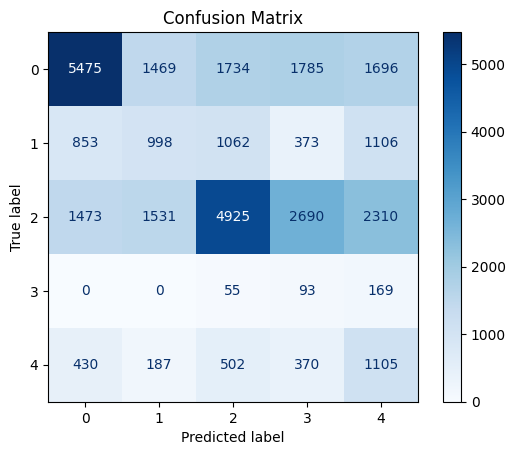

In [57]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, cohen_kappa_score, roc_auc_score, confusion_matrix

def evaluate_model(model, dataloader):
    # figure out where the model lives (cpu or cuda)
    device = next(model.parameters()).device
    model.eval()

    all_labels = []
    all_preds  = []
    all_probs  = []

    with torch.no_grad():
        for non_acc, acc, labels in dataloader:
            # move inputs to model's device
            non_acc = non_acc.to(device)
            acc     = acc.to(device)

            # forward
            y_hat = model(acc, non_acc)           # (seq_len, batch, C)
            y_hat = y_hat.permute(1, 0, 2)        # (batch, seq_len, C)
            B, T, C = y_hat.shape

            # flatten
            logits = y_hat.reshape(B*T, C)
            probs  = torch.softmax(logits, dim=1).cpu().numpy()
            preds  = probs.argmax(axis=1)
            labs   = labels.reshape(-1).numpy()

            # filter out padding (-1)
            mask = (labs != -1)
            all_labels.extend(labs[mask])
            all_preds.extend(preds[mask])
            all_probs.append(probs[mask])

    all_probs = np.concatenate(all_probs, axis=0)
    acc   = accuracy_score(all_labels, all_preds)
    kappa = cohen_kappa_score(all_labels, all_preds)
    auroc = roc_auc_score(all_labels, all_probs, multi_class='ovo', average='macro')
    cm    = confusion_matrix(all_labels, all_preds)
    return acc, kappa, auroc, cm

# Load and move your two best models to the same device:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

acc, kappa, auroc, cm = evaluate_model(model, test_loader)
#print(f"\n{name}:")
print(f"  Accuracy:          {acc:.4f}")
print(f"  Cohen’s kappa:     {kappa:.4f}")
print(f"  Macro AUROC (OVO): {auroc:.4f}")

# plot confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix")
plt.show()

# best_by_loss = ACCAwareSleepStager.load_from_checkpoint(loss_checkpoint.best_model_path).to(device)
# best_by_kappa = ACCAwareSleepStager.load_from_checkpoint(kappa_checkpoint.best_model_path).to(device)

# test_loader = DataLoader(test_dataset_mixed, batch_size=16, shuffle=False)

# for name, model in [("best_by_loss", best_by_loss),
#                     ("best_by_kappa", best_by_kappa)]:
#     acc, kappa, auroc, cm = evaluate_model(model, test_loader)
#     print(f"\n{name}:")
#     print(f"  Accuracy:          {acc:.4f}")
#     print(f"  Cohen’s kappa:     {kappa:.4f}")
#     print(f"  Macro AUROC (OVO): {auroc:.4f}")

#     # plot confusion matrix
#     from sklearn.metrics import ConfusionMatrixDisplay
#     import matplotlib.pyplot as plt

#     disp = ConfusionMatrixDisplay(cm)
#     disp.plot(cmap="Blues")
#     plt.title(f"Confusion Matrix — {name}")
#     plt.show()

### Ignore below

In [ ]:
#^These actually didnt perform very well in training
#Need to add test ability also
#should investigate training these params like 10 times and seeing if theyre truly good
#maybe re-optuna a few times and see all the best params it spits out 

In [71]:
best_cnn_output_channels = best_trial.params["cnn_output_channels"]
best_rnn_hidden_size = best_trial.params["rnn_hidden_size"]
best_pre_rnn_size = best_trial.params["pre_rnn_embedding_size"]
best_learning_rate = best_trial.params["learning_rate"]
best_hidden2_size =  best_trial.params["hidden_size2"]

best_dropout_embed = best_trial.params["dropout_embed"]
best_dropout_rnn = best_trial.params["dropout_rnn"]
#best_rnn_type = best_trial.params["RNN_type"]
best_acc_preprocess = best_trial.params["acc_preprocess"]
best_dropout_hidden2 = best_trial.params["dropout_hidden2"]
best_hidden2_size =  best_trial.params["hidden_size2"]
#learning_rate = 1e-3


In [14]:
# Train the acc aware model
wandb_logger = WandbLogger(project="GRU_TEST")
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='checkpoints/GRU_TEST/',
    filename='GRU-5dims-01_checkpoint',
    save_top_k=1,
    mode='max'
)
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=True,
    mode='max'
)
trainer = pl.Trainer(
    max_epochs=100,
    devices=1,
    accelerator='gpu',
    logger=wandb_logger,
    log_every_n_steps=1,
    precision="16-mixed",
    callbacks=[checkpoint_callback, early_stop_callback]
)
model = SleepStager(non_acc_dim = 5,
                        acc_preprocess = best_acc_preprocess,
                        RNN_type = 'GRU',
                        bidirectional = best_bidirectional,
                        dropout_embed = best_dropout_embed,
                        dropout_rnn = best_dropout_rnn,
                        dropout_hidden2 = best_dropout_hidden2,
    cnn_output_channels=best_cnn_output_channels,
    pre_rnn_embedding_size= best_pre_rnn_size,
                rnn_hidden_size= best_rnn_hidden_size,
                hidden_size2 = best_hidden2_size,
                lr = best_learning_rate,
                weight_tensor=weight_tensor.to(device),
                debug= False)

train_loader = DataLoader(train_dataset_mixed, batch_size=best_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset_mixed, batch_size=best_batch_size, shuffle=False)

trainer.fit(model, train_loader, val_loader)
wandb.finish()
# Load the best model
torch.save(model.state_dict(), f"/scratch/npr264/BioDeepL/project/models/042525_bestModel.pth")
# save best model


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/npr264/DeepLearning/project/checkpoints/GRU_TEST exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 164 K  | train
1 | embeddingLayer  | Linear               | 48     | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 30.0 K | train
5 | hidden2         | Linear               | 2.1 K  | train
6 | classifier      | Linear               | 165    | train
7 | criterio

Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 52.68it/s]torch.Size([4, 192000, 3])
                                                                           

/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 51/51 [00:01<00:00, 33.92it/s, v_num=ior8, train_loss_step=1.580]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 63.96it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 55.70it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 56.19it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 57.12it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 46.64it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 48.61it/s]torch.Size([4, 192000, 3])

Epoch 0: 100%|██████████| 51/51 [00:01<00:00, 30.53it/s, v_num=ior8, train_loss_step=1.580, val_loss=1.580, val_acc=0.279, val_cohen_kappa=0.0849, train_loss_epoch=1.610]

Metric val_loss improved. New best score: 1.583


Epoch 1: 100%|██████████| 51/51 [00:01<00:00, 34.98it/s, v_num=ior8, train_loss_step=1.600, val_loss=1.580, val_acc=0.279, val_cohen_kappa=0.0849, train_loss_epoch=1.610]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 69.26it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 58.14it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 51.48it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 48.64it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 51.06it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 52.69it/s]torch.Size([4, 192000, 3])

Epoch 2: 100%|██████████| 51/51 [00:01<00:00, 34.97it/s, v_num=ior8, train_loss_step=1.450, val_loss=1.57

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.583. Signaling Trainer to stop.


Epoch 5: 100%|██████████| 51/51 [00:01<00:00, 32.16it/s, v_num=ior8, train_loss_step=1.460, val_loss=1.540, val_acc=0.251, val_cohen_kappa=0.0877, train_loss_epoch=1.530]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▅▅▅▅▅▅▇▇▇▇▇▇▇███████
train_loss_epoch,█▅▃▂▁▁
train_loss_step,▅▅▅▅▆▅▅▅▄▃▅▄▅▅▄▅▃▁▄▅▄▆▃▄▆▁▆█▂▅▂▁▃▄▃▃▄▄▄▂
trainer/global_step,▁▁▁▁▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
val_acc,█▁▅▃▂▅
val_cohen_kappa,▇▁▆█▃▇
val_loss,█▇▂▁▃▄
epoch,5
train_loss_epoch,1.52939
train_loss_step,1.45748
trainer/global_step,305


NameError: name 'trial' is not defined

In [18]:
torch.save(model.state_dict(), f"/scratch/npr264/BioDeepL/project/models/042525_bestModel.pth")


In [16]:
wandb_logger = WandbLogger(project="GRU_TEST", name="test_eval_run")

trainer = pl.Trainer(
    logger=wandb_logger,
    accelerator="gpu",
    devices=1,
    precision="16-mixed",
)

trainer.test(model, dataloaders=test_loader)
wandb.finish()


Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MisconfigurationException: No `test_step()` method defined to run `Trainer.test`.